### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster)
from poc.functions import State_Timer
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-11-05T14:23:11.778 INFO iotfunctions.dbtables.__init__ Init FileModelStore


In [3]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./Weather.csv', 
                   dtype={"Snowfall":object, "PoorWeather":object, "SNF": object, "TSHDSBRSGF":object},
                   index_col=False, parse_dates=['Date'])

df_i.rename(columns={'Date': 'timestamp'}, inplace=True)

# drastic filtering
df_i = df_i[df_i['STA'] == 10001]

df_i['entity'] = df_i['STA'].astype(str)



# and sort it by timestamp
df_i = df_i[['entity','timestamp','Precip','MaxTemp','MinTemp','MeanTemp']].sort_values(by=['entity','timestamp'])


df_i = df_i.set_index(['entity','timestamp']).dropna()


df_i.head(8)


Precip    MaxTemp    MinTemp   MeanTemp
entity timestamp                                         
10001  1942-07-01  1.016  25.555556  22.222222  23.888889
       1942-07-02      0  28.888889  21.666667  25.555556
       1942-07-03   2.54  26.111111  22.222222  24.444444
       1942-07-04   2.54  26.666667  22.222222  24.444444
       1942-07-05      0  26.666667  21.666667  24.444444
       1942-07-06      0  26.666667  21.666667  24.444444
       1942-07-07      T  28.333333  22.777778  25.555556
       1942-07-08  3.556  26.666667  22.222222  24.444444

In [4]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = GBMForecaster(['MaxTemp'], ['MaxTemp'], ['MaxTemp_pred'],[24,25,31])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

EngineLogging.configure_console_logging(logging.INFO)
df_i.describe()


2020-11-05T14:23:19.981 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
lags [24, 25, 31]  lagged_features ['MaxTemp'] Train mode: True
2020-11-05T14:23:19.983 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-11-05T14:23:19.984 DEBUG iotfunctions.util.__init__ Starting trace
2020-11-05T14:23:19.985 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMForecaster_20201105132319
2020-11-05T14:23:19.986 DEBUG iotfunctions.util.__init__ auto_save None
2020-11-05T14:23:19.987 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-11-05T14:23:19.988 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-11-05T14:23:19.988 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMFORECASTER
Functions:
Granulari

lags [24, 25, 31]  lagged_features ['MaxTemp'] Train mode: False
['MaxTemp_24' 'MaxTemp_25' 'MaxTemp_31' '_DayOfWeekCos_' '_DayOfWeekSin_'
 '_DayOfYearCos_' '_DayOfYearSin_']
2020-11-05T14:23:35.286 INFO iotfunctions.base.get_models_for_training predicting target MaxTemp
2020-11-05T14:23:35.289 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.MaxTemp.10001 of size 1562757 bytes has been retrieved from filesystem
2020-11-05T14:23:35.365 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.MaxTemp.10001",
 "target": "MaxTemp",
 "features": [
  "MaxTemp_24",
  "MaxTemp_25",
  "MaxTemp_31",
  "_DayOfWeekCos_",
  "_DayOfWeekSin_",
  "_DayOfYearCos_",
  "_DayOfYearSin_"
 ],
 "estimator_name": "light_gradient_boosted_regressor",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 0.9944668187467975,
 "eval_metric_test": 0.6615773106865777,
 "trained_date": "2020-11-05T13:23:3

MaxTemp      MinTemp     MeanTemp  MaxTemp_pred
count  1150.000000  1150.000000  1150.000000   1150.000000
mean     30.518357    22.523188    26.526087     30.373166
std       2.500569     1.430077     1.776236      2.608658
min      21.111111    16.111111    20.555556     23.581144
25%      28.472222    21.666667    25.555556     28.413832
50%      31.111111    22.222222    26.666667     31.090970
75%      32.222222    23.333333    27.777778     32.464533
max      35.555556    27.777778    30.555556     35.298166

Text(0, 0.5, 'WWII Weather Data\n(predict max temp from min temp)')

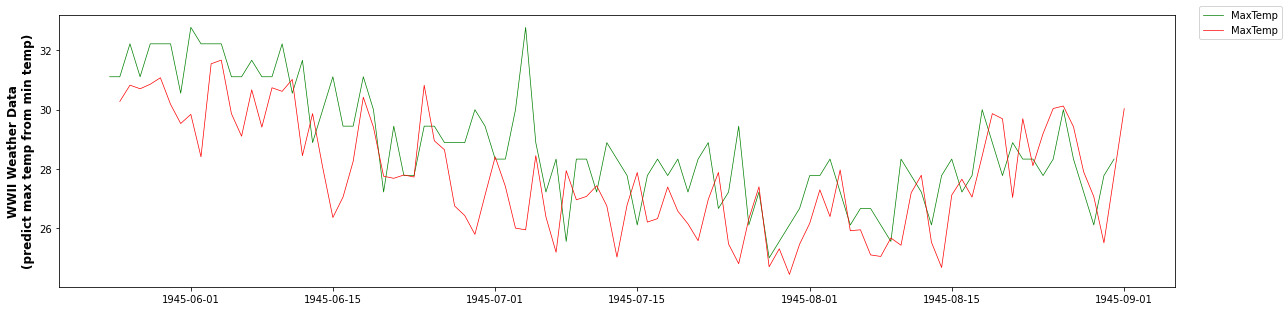

In [5]:
#
df_disp = df_i.tail(100)
plots = 1
fig, ax = plt.subplots(plots, 1, figsize=(20,5), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_disp.unstack(level=0).index, df_disp['MaxTemp'],linewidth=0.7,color='green',label='MaxTemp')
ax[cnt,0].plot(df_disp.unstack(level=0).index + pd.DateOffset(hours=24),
               df_disp['MaxTemp_pred'],linewidth=0.7,color='red',label='MaxTemp')

ax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt,0].set_ylabel('WWII Weather Data\n(predict max temp from min temp)',fontsize=12,weight="bold")

#df_i[['MaxTemp','__forecast__']].tail(100).plot(figsize=(10,3))
#df_i[['MaxTemp_pred']].tail(48).plot(figsize=(10,3))

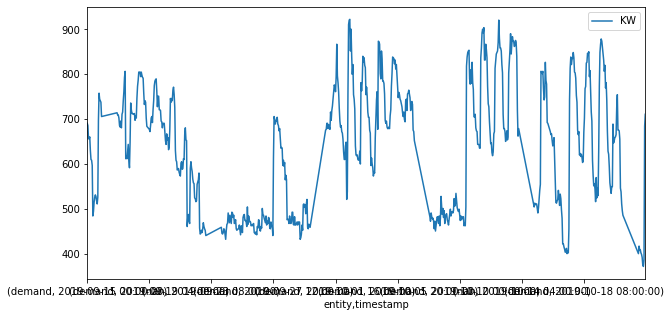

In [6]:
# load data
df_input = pd.read_csv('BP_DATA/IoTData.csv', parse_dates=['DATETIME'], comment='#')
df_input.rename(columns={'DATETIME': 'timestamp'}, inplace=True)
df_input['entity'] = 'demand'
#df_input = df_input.asfreq('H')
df_input.set_index('timestamp', inplace=True)

# fix blue Monday - Monday 9 and 10 am
df_input = df_input[(df_input.index.weekday != 0) | (df_input.index.hour > 10) & (df_input.index.hour < 9)].resample('1H').\
            interpolate().reset_index().set_index(['entity','timestamp'])

df_input[['KW']].head(900).plot(figsize=(10,5))

In [7]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = GBMForecaster(['KW', 'TEMP_AIR'], ['KW'], ['KW_forecast'],[24,48, 168])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_input = spsi.execute(df=df_input)

EngineLogging.configure_console_logging(logging.INFO)
df_input.describe()

2020-11-05T14:23:37.432 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
lags [24, 48, 168]  lagged_features ['KW', 'TEMP_AIR'] Train mode: True
2020-11-05T14:23:37.435 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-11-05T14:23:37.436 DEBUG iotfunctions.util.__init__ Starting trace
2020-11-05T14:23:37.438 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMForecaster_20201105132337
2020-11-05T14:23:37.439 DEBUG iotfunctions.util.__init__ auto_save None
2020-11-05T14:23:37.442 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-11-05T14:23:37.443 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-11-05T14:23:37.444 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMFORECASTER
Functions:
G

2020-11-05T14:23:54.811 INFO iotfunctions.metadata.predict predicted using model model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.KW.demand
2020-11-05T14:23:54.835 DEBUG iotfunctions.util.log_df_info After adding predictions for target KW ; df row count: 6993  ; index: { entity , timestamp }  ; columns: { TEMP_AIR , UMIDADE_REL , KW , KW2 , KW_24 , KW_48 , KW_168 , TEMP_AIR_24 , TEMP_AIR_48 , TEMP_AIR_168 , _DayOfWeekCos_ , _DayOfWeekSin_ , _DayOfYearCos_ , _DayOfYearSin_ , KW_forecast }
lags [24, 48, 168]  lagged_features ['KW', 'TEMP_AIR'] Train mode: False
['KW_24' 'KW_48' 'KW_168' 'TEMP_AIR_24' 'TEMP_AIR_48' 'TEMP_AIR_168'
 '_DayOfWeekCos_' '_DayOfWeekSin_' '_DayOfYearCos_' '_DayOfYearSin_']
2020-11-05T14:23:54.931 INFO iotfunctions.base.get_models_for_training predicting target KW
2020-11-05T14:23:54.934 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.KW.demand of size 1712669 bytes has been retrieved from filesystem
2020-11-05T14

TEMP_AIR  UMIDADE_REL           KW          KW2
count  8280.000000  8280.000000  8280.000000  8280.000000
mean     20.082017    69.152778   578.475841    57.847584
std       4.183426    15.922836   147.592446    14.759245
min       8.300000    15.000000    31.920001     3.192000
25%      17.156000    59.160000   467.040009    46.704001
50%      19.704000    74.000000   546.000000    54.600000
75%      22.600000    81.000000   678.719971    67.871997
max      35.100000    92.000000   944.160000    94.416000

In [8]:
#df_input[['KW','KW_forecast']].tail(26)

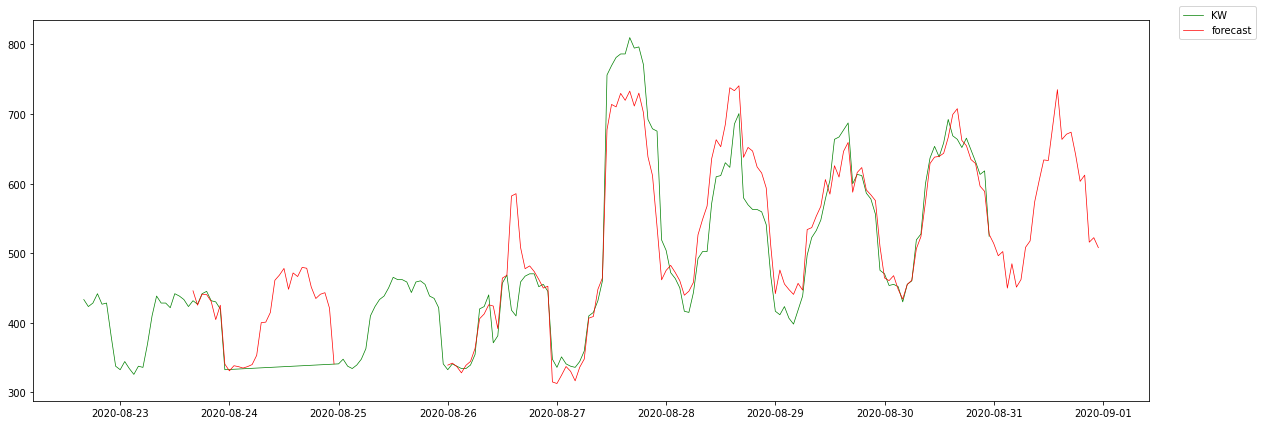

In [11]:
#
df_disp = df_input.tail(200)
df_fore = df_input.tail(200)
plots = 1
fig, ax = plt.subplots(plots, 1, figsize=(20,7), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_disp.unstack(level=0).index, df_disp['KW'],linewidth=0.7,color='green',label='KW')
#ax[cnt,0].plot(df_disp.unstack(level=0).index, df_disp['KW_forecast'],linewidth=0.7,color='blue',label='forecast')
ax[cnt,0].plot(df_disp.unstack(level=0).index + pd.DateOffset(hours=24), df_disp['KW_forecast'],linewidth=0.7,color='red',label='forecast')

ax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))
#ax[cnt,0].set_ylabel('WWII Weather Data\n(predict max temp from min temp)',fontsize=12,weight="bold")


In [6]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = FeatureBuilder(['MinTemp', 'MaxTemp'], 1, 'mean', ['MinTemp_1dm','MaxTemp_1dm'])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)


df_i.describe()

2020-11-02T16:56:11.370 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
FeatureBuilder ['MinTemp', 'MaxTemp'] ['MinTemp_1dm', 'MaxTemp_1dm'] 1 mean
2020-11-02T16:56:11.372 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-11-02T16:56:11.373 DEBUG iotfunctions.util.__init__ Starting trace
2020-11-02T16:56:11.374 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_FeatureBuilder_20201102155611
2020-11-02T16:56:11.377 DEBUG iotfunctions.util.__init__ auto_save None
2020-11-02T16:56:11.377 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-11-02T16:56:11.378 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-11-02T16:56:11.379 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_FEATUREBUILDER
Functi

MaxTemp      MinTemp     MeanTemp   MinTemp_1d   MaxTemp_1d  \
count  1157.000000  1157.000000  1157.000000  1156.000000  1156.000000   
mean     30.496975    22.520407    26.514933    22.520665    30.498847   
std       2.509494     1.426508     1.777196     1.427098     2.509772   
min      21.111111    16.111111    20.555556    16.111111    21.111111   
25%      28.333333    21.666667    25.000000    21.666667    28.333333   
50%      31.111111    22.222222    26.666667    22.222222    31.111111   
75%      32.222222    23.333333    27.777778    23.333333    32.222222   
max      35.555556    27.777778    30.555556    27.777778    35.555556   

       MinTemp_1dm  MaxTemp_1dm  
count  1156.000000  1156.000000  
mean     22.520665    30.498847  
std       1.427098     2.509772  
min      16.111111    21.111111  
25%      21.666667    28.333333  
50%      22.222222    31.111111  
75%      23.333333    32.222222  
max      27.777778    35.555556

In [7]:
df_i.head(10)

Precip    MaxTemp    MinTemp   MeanTemp  MinTemp_1d  \
entity timestamp                                                        
10001  1942-07-01  1.016  25.555556  22.222222  23.888889         NaN   
       1942-07-02      0  28.888889  21.666667  25.555556   22.222222   
       1942-07-03   2.54  26.111111  22.222222  24.444444   21.666667   
       1942-07-04   2.54  26.666667  22.222222  24.444444   22.222222   
       1942-07-05      0  26.666667  21.666667  24.444444   22.222222   
       1942-07-06      0  26.666667  21.666667  24.444444   21.666667   
       1942-07-07      T  28.333333  22.777778  25.555556   21.666667   
       1942-07-08  3.556  26.666667  22.222222  24.444444   22.777778   
       1942-07-09      T  27.222222  22.777778  25.000000   22.222222   
       1942-07-10  3.556  25.555556  21.666667  23.333333   22.777778   

                   MaxTemp_1d  MinTemp_1dm  MaxTemp_1dm  
entity timestamp                                         
10001  1942-07-01         NaN          NaN          NaN  
       1942-07-02   25.555556    22.222222    25.555556  
       1942-07-03   28.888889    21.666667    28.888889  
       1942-07-04   26.111111    22.222222    26.111111  
       1942-07-05   26.666667    22.222222    26.666667  
       1942-07-06   26.666667    21.666667    26.666667  
       1942-07-07   26.666667    21.666667    26.666667  
       1942-07-08   28.333333    22.777778    28.333333  
       1942-07-09   26.666667    22.222222    26.666667  
       1942-07-10   27.222222    22.777778    27.222222

In [4]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = State_Timer('MinTemp', 'meas_MinTemp')
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)


df_i.describe()

2020-11-02T12:09:31.797 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-11-02T12:09:31.797 DEBUG poc.functions.__init__ state_column= MinTemp  state_metric_name= meas_MinTemp 
2020-11-02T12:09:31.798 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-11-02T12:09:31.799 DEBUG iotfunctions.util.__init__ Starting trace
2020-11-02T12:09:31.799 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_State_Timer_20201102110931
2020-11-02T12:09:31.800 DEBUG iotfunctions.util.__init__ auto_save None
2020-11-02T12:09:31.800 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-11-02T12:09:31.801 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-11-02T12:09:31.801 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_EN

2020-11-02T12:09:31.833 DEBUG poc.functions.execute Get rows just for device 10001 --
2020-11-02T12:09:31.836 DEBUG poc.functions.execute      entity  timestamp Precip    MaxTemp    MinTemp   MeanTemp  22.22222222  \
0     10001 1942-07-01  1.016  25.555556  22.222222  23.888889            0   
1     10001 1942-07-02      0  28.888889  21.666667  25.555556            0   
2     10001 1942-07-03   2.54  26.111111  22.222222  24.444444            0   
3     10001 1942-07-04   2.54  26.666667  22.222222  24.444444            0   
4     10001 1942-07-05      0  26.666667  21.666667  24.444444            0   
...     ...        ...    ...        ...        ...        ...          ...   
1152  10001 1945-08-27      T  28.333333  22.777778  25.555556            0   
1153  10001 1945-08-28  13.97  27.222222  22.222222  24.444444            0   
1154  10001 1945-08-29  3.048  26.111111  22.222222  24.444444            0   
1155  10001 1945-08-30      T  27.777778  22.777778  25.555556          

2020-11-02T12:09:31.930 DEBUG poc.functions.execute Match  22.22222222 current time  1942-07-03 00:00:00 and last status time 1942-07-02 00:00:00
2020-11-02T12:09:31.931 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:31.932 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:31.935 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:31.936 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:31.936 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:31.937 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:31.937 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:31.937 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:31.938 DEBUG poc.functions.execute Che

2020-11-02T12:09:31.974 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:09:31.975 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:09:31.975 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:09:31.975 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:31.976 DEBUG poc.functions.execute Last status_timestamp 1942-07-05 00:00:00 
2020-11-02T12:09:31.976 DEBUG poc.functions.execute Row
2020-11-02T12:09:31.976 DEBUG poc.functions.execute ['10001', Timestamp('1942-07-06 00:00:00'), '0', 26.66666667, 21.66666667, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:31.977 DEBUG poc.functions.execute -------laststatus_timestamp 1942-07-05 00:00:00
2020-11-02T12:09:31.978 DEBUG poc.functions.execute Checking if current row  21.66666667 is

2020-11-02T12:09:32.025 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:09:32.025 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:32.026 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:32.027 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:32.027 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:32.028 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:32.028 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:09:32.029 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:32.029 DEBUG poc.functions.execute Checking if current row  22.22222222 is in s

2020-11-02T12:09:32.082 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.66666667
2020-11-02T12:09:32.082 DEBUG poc.functions.execute Match  21.66666667 current time  1942-07-11 00:00:00 and last status time 1942-07-10 00:00:00
2020-11-02T12:09:32.084 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:09:32.085 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:32.088 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:32.088 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:09:32.089 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:32.089 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:32.091 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:32.091 DEBUG poc.functions.execute Che

2020-11-02T12:09:32.130 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:09:32.130 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:09:32.131 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:09:32.131 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:32.132 DEBUG poc.functions.execute Last status_timestamp 1942-07-13 00:00:00 
2020-11-02T12:09:32.132 DEBUG poc.functions.execute Row
2020-11-02T12:09:32.132 DEBUG poc.functions.execute ['10001', Timestamp('1942-07-14 00:00:00'), '0', 26.11111111, 22.22222222, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:32.133 DEBUG poc.functions.execute -------laststatus_timestamp 1942-07-13 00:00:00
2020-11-02T12:09:32.133 DEBUG poc.functions.execute Checking if current row  22.22222222 is

2020-11-02T12:09:32.182 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.77777778
2020-11-02T12:09:32.183 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.33333333
2020-11-02T12:09:32.183 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.88888889
2020-11-02T12:09:32.183 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.22222222
2020-11-02T12:09:32.184 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.11111111
2020-11-02T12:09:32.185 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:09:32.185 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:09:32.185 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:09:32.186 DEBUG poc.functions.execute Checking if current row  21.11111111 is in s

2020-11-02T12:09:32.231 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.66666667
2020-11-02T12:09:32.232 DEBUG poc.functions.execute Match  21.66666667 current time  1942-07-19 00:00:00 and last status time 1942-07-18 00:00:00
2020-11-02T12:09:32.233 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:09:32.233 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:32.236 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:32.237 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:09:32.237 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:32.238 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:32.238 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:32.238 DEBUG poc.functions.execute Che

2020-11-02T12:09:32.280 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:09:32.280 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:09:32.281 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:32.282 DEBUG poc.functions.execute Last status_timestamp 1942-07-21 00:00:00 
2020-11-02T12:09:32.283 DEBUG poc.functions.execute Row
2020-11-02T12:09:32.283 DEBUG poc.functions.execute ['10001', Timestamp('1942-07-22 00:00:00'), 'T', 24.44444444, 21.11111111, 22.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:32.284 DEBUG poc.functions.execute -------laststatus_timestamp 1942-07-21 00:00:00
2020-11-02T12:09:32.284 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:09:32.285 DEBUG poc.functions.execute Checking if current row  21.11111111 is

2020-11-02T12:09:32.325 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 23.33333333
2020-11-02T12:09:32.326 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 23.88888889
2020-11-02T12:09:32.326 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 17.22222222
2020-11-02T12:09:32.326 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 16.11111111
2020-11-02T12:09:32.327 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 16.66666667
2020-11-02T12:09:32.327 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 18.33333333
2020-11-02T12:09:32.328 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 24.44444444
2020-11-02T12:09:32.328 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 25.0
2020-11-02T12:09:32.328 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 25

2020-11-02T12:09:32.366 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 22.77777778
2020-11-02T12:09:32.367 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 21.11111111
2020-11-02T12:09:32.367 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 20.0
2020-11-02T12:09:32.368 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 20.55555556
2020-11-02T12:09:32.368 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 18.88888889
2020-11-02T12:09:32.369 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 19.44444444
2020-11-02T12:09:32.369 DEBUG poc.functions.execute Match  19.44444444 current time  1942-07-27 00:00:00 and last status time 1942-07-26 00:00:00
2020-11-02T12:09:32.370 DEBUG poc.functions.execute mins 19.44444444
2020-11-02T12:09:32.370 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:32.374 DEBUG poc.functions.execute Che

2020-11-02T12:09:32.419 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 26.66666667
2020-11-02T12:09:32.421 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 26.11111111
2020-11-02T12:09:32.421 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 27.77777778
2020-11-02T12:09:32.422 DEBUG poc.functions.execute Last status_timestamp 1942-07-29 00:00:00 
2020-11-02T12:09:32.423 DEBUG poc.functions.execute Row
2020-11-02T12:09:32.423 DEBUG poc.functions.execute ['10001', Timestamp('1942-07-30 00:00:00'), '0', 27.22222222, 19.44444444, 23.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:32.424 DEBUG poc.functions.execute -------laststatus_timestamp 1942-07-29 00:00:00
2020-11-02T12:09:32.426 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 22.22222222
2020-11-02T12:09:32.427 DEBUG poc.functions.execute Checking if current row  19.44444444 is

2020-11-02T12:09:32.472 DEBUG poc.functions.execute Checking if current row  20.0 is in state 23.88888889
2020-11-02T12:09:32.473 DEBUG poc.functions.execute Checking if current row  20.0 is in state 17.22222222
2020-11-02T12:09:32.475 DEBUG poc.functions.execute Checking if current row  20.0 is in state 16.11111111
2020-11-02T12:09:32.475 DEBUG poc.functions.execute Checking if current row  20.0 is in state 16.66666667
2020-11-02T12:09:32.476 DEBUG poc.functions.execute Checking if current row  20.0 is in state 18.33333333
2020-11-02T12:09:32.476 DEBUG poc.functions.execute Checking if current row  20.0 is in state 24.44444444
2020-11-02T12:09:32.477 DEBUG poc.functions.execute Checking if current row  20.0 is in state 25.0
2020-11-02T12:09:32.477 DEBUG poc.functions.execute Checking if current row  20.0 is in state 25.55555556
2020-11-02T12:09:32.478 DEBUG poc.functions.execute Checking if current row  20.0 is in state 26.66666667
2020-11-02T12:09:32.478 DEBUG poc.functions.execute C

2020-11-02T12:09:32.516 DEBUG poc.functions.execute Match  21.11111111 current time  1942-08-04 00:00:00 and last status time 1942-08-03 00:00:00
2020-11-02T12:09:32.517 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:09:32.517 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:32.520 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:09:32.521 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:09:32.521 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:09:32.522 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 19.44444444
2020-11-02T12:09:32.522 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.77777778
2020-11-02T12:09:32.523 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.33333333
2020-11-02T12:09:32.523 DEBUG poc.functions.execute Che

2020-11-02T12:09:32.557 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:32.557 DEBUG poc.functions.execute Last status_timestamp 1942-08-06 00:00:00 
2020-11-02T12:09:32.558 DEBUG poc.functions.execute Row
2020-11-02T12:09:32.559 DEBUG poc.functions.execute ['10001', Timestamp('1942-08-07 00:00:00'), 'T', 24.44444444, 21.11111111, 22.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:32.559 DEBUG poc.functions.execute -------laststatus_timestamp 1942-08-06 00:00:00
2020-11-02T12:09:32.559 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:09:32.559 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.66666667
2020-11-02T12:09:32.560 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:09:32.560 DEBUG poc.functions.execute Checking if current row  21.11111111 is

2020-11-02T12:09:32.623 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:09:32.623 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.11111111
2020-11-02T12:09:32.624 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:09:32.624 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:09:32.624 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 24.44444444
2020-11-02T12:09:32.625 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.0
2020-11-02T12:09:32.625 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.55555556
2020-11-02T12:09:32.626 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26.66666667
2020-11-02T12:09:32.626 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26

2020-11-02T12:09:32.664 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.0
2020-11-02T12:09:32.665 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.55555556
2020-11-02T12:09:32.666 DEBUG poc.functions.execute Match  20.55555556 current time  1942-08-12 00:00:00 and last status time 1942-08-11 00:00:00
2020-11-02T12:09:32.666 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:09:32.666 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:32.671 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.88888889
2020-11-02T12:09:32.672 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 19.44444444
2020-11-02T12:09:32.674 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.77777778
2020-11-02T12:09:32.675 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:09:32.676 DEBUG poc.functions.execute Che

2020-11-02T12:09:32.722 DEBUG poc.functions.execute Last status_timestamp 1942-08-14 00:00:00 
2020-11-02T12:09:32.723 DEBUG poc.functions.execute Row
2020-11-02T12:09:32.724 DEBUG poc.functions.execute ['10001', Timestamp('1942-08-15 00:00:00'), '0.254', 25.55555556, 17.77777778, 21.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:32.724 DEBUG poc.functions.execute -------laststatus_timestamp 1942-08-14 00:00:00
2020-11-02T12:09:32.725 DEBUG poc.functions.execute Checking if current row  17.77777778 is in state 22.22222222
2020-11-02T12:09:32.725 DEBUG poc.functions.execute Checking if current row  17.77777778 is in state 21.66666667
2020-11-02T12:09:32.726 DEBUG poc.functions.execute Checking if current row  17.77777778 is in state 22.77777778
2020-11-02T12:09:32.727 DEBUG poc.functions.execute Checking if current row  17.77777778 is in state 21.11111111
2020-11-02T12:09:32.727 DEBUG poc.functions.execute Checking if current row  17.7777777

2020-11-02T12:09:32.778 DEBUG poc.functions.execute Checking if current row  20.0 is in state 16.66666667
2020-11-02T12:09:32.779 DEBUG poc.functions.execute Checking if current row  20.0 is in state 18.33333333
2020-11-02T12:09:32.779 DEBUG poc.functions.execute Checking if current row  20.0 is in state 24.44444444
2020-11-02T12:09:32.780 DEBUG poc.functions.execute Checking if current row  20.0 is in state 25.0
2020-11-02T12:09:32.781 DEBUG poc.functions.execute Checking if current row  20.0 is in state 25.55555556
2020-11-02T12:09:32.781 DEBUG poc.functions.execute Checking if current row  20.0 is in state 26.66666667
2020-11-02T12:09:32.782 DEBUG poc.functions.execute Checking if current row  20.0 is in state 26.11111111
2020-11-02T12:09:32.782 DEBUG poc.functions.execute Checking if current row  20.0 is in state 27.77777778
2020-11-02T12:09:32.783 DEBUG poc.functions.execute Last status_timestamp 1942-08-17 00:00:00 
2020-11-02T12:09:32.783 DEBUG poc.functions.execute Row
2020-11-

2020-11-02T12:09:32.825 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:09:32.825 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:32.828 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.88888889
2020-11-02T12:09:32.829 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 19.44444444
2020-11-02T12:09:32.829 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.77777778
2020-11-02T12:09:32.830 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:09:32.831 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:09:32.831 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:09:32.832 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.11111111
2020-11-02T12:09:32.832 DEBUG poc.functions.execute Checking if current row  20.5

2020-11-02T12:09:32.873 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.22222222
2020-11-02T12:09:32.874 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.66666667
2020-11-02T12:09:32.874 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.77777778
2020-11-02T12:09:32.875 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.11111111
2020-11-02T12:09:32.876 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.0
2020-11-02T12:09:32.876 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.55555556
2020-11-02T12:09:32.877 DEBUG poc.functions.execute Match  20.55555556 current time  1942-08-23 00:00:00 and last status time 1942-08-22 00:00:00
2020-11-02T12:09:32.878 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:09:32.879 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:32.883 DEBUG poc.functions.execute Che

2020-11-02T12:09:32.935 DEBUG poc.functions.execute Checking if current row  20.0 is in state 25.55555556
2020-11-02T12:09:32.936 DEBUG poc.functions.execute Checking if current row  20.0 is in state 26.66666667
2020-11-02T12:09:32.936 DEBUG poc.functions.execute Checking if current row  20.0 is in state 26.11111111
2020-11-02T12:09:32.937 DEBUG poc.functions.execute Checking if current row  20.0 is in state 27.77777778
2020-11-02T12:09:32.937 DEBUG poc.functions.execute Last status_timestamp 1942-08-25 00:00:00 
2020-11-02T12:09:32.938 DEBUG poc.functions.execute Row
2020-11-02T12:09:32.939 DEBUG poc.functions.execute ['10001', Timestamp('1942-08-26 00:00:00'), '0', 27.22222222, 20.55555556, 23.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:32.940 DEBUG poc.functions.execute -------laststatus_timestamp 1942-08-25 00:00:00
2020-11-02T12:09:32.940 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.22222222
2020-1

2020-11-02T12:09:32.999 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.77777778
2020-11-02T12:09:32.999 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:09:33.000 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:09:33.000 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:09:33.001 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.11111111
2020-11-02T12:09:33.002 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:09:33.003 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:09:33.004 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 24.44444444
2020-11-02T12:09:33.004 DEBUG poc.functions.execute Checking if current row  20.55555556 is in s

2020-11-02T12:09:33.060 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.66666667
2020-11-02T12:09:33.060 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:09:33.061 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:09:33.062 DEBUG poc.functions.execute Match  21.11111111 current time  1942-08-31 00:00:00 and last status time 1942-08-30 00:00:00
2020-11-02T12:09:33.064 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:09:33.065 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:33.070 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:09:33.071 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:09:33.072 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:09:33.072 DEBUG poc.functions.execute Che

2020-11-02T12:09:33.136 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:09:33.138 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:09:33.139 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:33.140 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:33.140 DEBUG poc.functions.execute Last status_timestamp 1942-09-02 00:00:00 
2020-11-02T12:09:33.141 DEBUG poc.functions.execute Row
2020-11-02T12:09:33.142 DEBUG poc.functions.execute ['10001', Timestamp('1942-09-03 00:00:00'), '1.778', 27.22222222, 21.11111111, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:33.143 DEBUG poc.functions.execute -------laststatus_timestamp 1942-09-02 00:00:00
2020-11-02T12:09:33.144 DEBUG poc.functions.execute Checking if current row  21.1111111

2020-11-02T12:09:33.220 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:09:33.221 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:33.222 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:33.222 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:33.223 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:33.224 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:33.224 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:09:33.226 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:33.227 DEBUG poc.functions.execute Checking if current row  22.22222222 is in s

2020-11-02T12:09:33.313 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.66666667
2020-11-02T12:09:33.314 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:09:33.315 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:09:33.316 DEBUG poc.functions.execute Match  21.11111111 current time  1942-09-08 00:00:00 and last status time 1942-09-07 00:00:00
2020-11-02T12:09:33.317 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:09:33.318 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:33.327 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:09:33.328 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:09:33.330 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:09:33.332 DEBUG poc.functions.execute Che

2020-11-02T12:09:33.426 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:09:33.427 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:33.427 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:33.429 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:09:33.430 DEBUG poc.functions.execute Last status_timestamp 1942-09-10 00:00:00 
2020-11-02T12:09:33.431 DEBUG poc.functions.execute Row
2020-11-02T12:09:33.435 DEBUG poc.functions.execute ['10001', Timestamp('1942-09-11 00:00:00'), '0', 26.11111111, 21.11111111, 23.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:33.436 DEBUG poc.functions.execute -------laststatus_timestamp 1942-09-10 00:00:00
2020-11-02T12:09:33.438 DEBUG poc.functions.execute Checking if current row  21.11111111 is

2020-11-02T12:09:33.563 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.77777778
2020-11-02T12:09:33.564 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:09:33.565 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.88888889
2020-11-02T12:09:33.568 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.22222222
2020-11-02T12:09:33.571 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.11111111
2020-11-02T12:09:33.572 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:09:33.574 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:09:33.575 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:09:33.576 DEBUG poc.functions.execute Checking if current row  21.66666667 is in s

2020-11-02T12:09:33.718 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.66666667
2020-11-02T12:09:33.721 DEBUG poc.functions.execute Match  21.66666667 current time  1942-09-16 00:00:00 and last status time 1942-09-15 00:00:00
2020-11-02T12:09:33.723 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:09:33.725 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:33.737 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:33.740 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:09:33.741 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:33.743 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:33.745 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:33.746 DEBUG poc.functions.execute Che

2020-11-02T12:09:33.885 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:09:33.887 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:33.891 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:33.894 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:09:33.895 DEBUG poc.functions.execute Last status_timestamp 1942-09-18 00:00:00 
2020-11-02T12:09:33.897 DEBUG poc.functions.execute Row
2020-11-02T12:09:33.899 DEBUG poc.functions.execute ['10001', Timestamp('1942-09-19 00:00:00'), '0', 34.44444444, 22.22222222, 28.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:33.900 DEBUG poc.functions.execute -------laststatus_timestamp 1942-09-18 00:00:00
2020-11-02T12:09:33.902 DEBUG poc.functions.execute Checking if current row  22.22222222 is

2020-11-02T12:09:34.036 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:09:34.037 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:34.038 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:34.040 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:34.042 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:34.043 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:34.048 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:09:34.049 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:34.050 DEBUG poc.functions.execute Checking if current row  22.22222222 is in s

2020-11-02T12:09:34.176 DEBUG poc.functions.execute Match  22.22222222 current time  1942-09-24 00:00:00 and last status time 1942-09-23 00:00:00
2020-11-02T12:09:34.177 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:34.178 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:34.191 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:34.193 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:34.195 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:34.196 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:34.197 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:34.199 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:34.201 DEBUG poc.functions.execute Che

2020-11-02T12:09:34.326 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:09:34.327 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:09:34.328 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:34.329 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:34.330 DEBUG poc.functions.execute Last status_timestamp 1942-09-26 00:00:00 
2020-11-02T12:09:34.335 DEBUG poc.functions.execute Row
2020-11-02T12:09:34.336 DEBUG poc.functions.execute ['10001', Timestamp('1942-09-27 00:00:00'), 'T', 31.66666667, 21.11111111, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:34.338 DEBUG poc.functions.execute -------laststatus_timestamp 1942-09-26 00:00:00
2020-11-02T12:09:34.344 DEBUG poc.functions.execute Checking if current row  21.11111111 is

2020-11-02T12:09:34.487 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:09:34.488 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:34.490 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:34.491 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:34.492 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:34.493 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:34.495 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:09:34.496 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:34.497 DEBUG poc.functions.execute Checking if current row  22.22222222 is in s

2020-11-02T12:09:34.617 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:09:34.618 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:09:34.620 DEBUG poc.functions.execute Match  22.77777778 current time  1942-10-02 00:00:00 and last status time 1942-10-01 00:00:00
2020-11-02T12:09:34.621 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:09:34.626 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:34.634 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:09:34.637 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:09:34.639 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:09:34.641 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:34.642 DEBUG poc.functions.execute Che

2020-11-02T12:09:34.763 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:09:34.764 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:34.766 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:34.768 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:09:34.769 DEBUG poc.functions.execute Last status_timestamp 1942-10-04 00:00:00 
2020-11-02T12:09:34.770 DEBUG poc.functions.execute Row
2020-11-02T12:09:34.771 DEBUG poc.functions.execute ['10001', Timestamp('1942-10-05 00:00:00'), '0', 31.11111111, 22.22222222, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:34.772 DEBUG poc.functions.execute -------laststatus_timestamp 1942-10-04 00:00:00
2020-11-02T12:09:34.774 DEBUG poc.functions.execute Checking if current row  22.22222222 is

2020-11-02T12:09:34.879 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:09:34.880 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:09:34.882 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:09:34.883 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:09:34.884 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:09:34.885 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:09:34.886 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:09:34.891 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:09:34.892 DEBUG poc.functions.execute Checking if current row  22.77777778 is in s

2020-11-02T12:09:35.020 DEBUG poc.functions.execute Match  22.22222222 current time  1942-10-10 00:00:00 and last status time 1942-10-09 00:00:00
2020-11-02T12:09:35.022 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:35.024 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:35.034 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:35.037 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:35.039 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:35.041 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:35.042 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:35.044 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:35.046 DEBUG poc.functions.execute Che

2020-11-02T12:09:35.186 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:09:35.187 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:35.196 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:35.198 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:09:35.199 DEBUG poc.functions.execute Last status_timestamp 1942-10-12 00:00:00 
2020-11-02T12:09:35.200 DEBUG poc.functions.execute Row
2020-11-02T12:09:35.202 DEBUG poc.functions.execute ['10001', Timestamp('1942-10-13 00:00:00'), 'T', 30.0, 22.77777778, 26.11111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:35.203 DEBUG poc.functions.execute -------laststatus_timestamp 1942-10-12 00:00:00
2020-11-02T12:09:35.205 DEBUG poc.functions.execute Checking if current row  22.77777778 is in sta

2020-11-02T12:09:35.342 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.77777778
2020-11-02T12:09:35.343 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.33333333
2020-11-02T12:09:35.344 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.88888889
2020-11-02T12:09:35.346 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.22222222
2020-11-02T12:09:35.349 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.11111111
2020-11-02T12:09:35.350 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:09:35.351 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:09:35.354 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:09:35.355 DEBUG poc.functions.execute Checking if current row  21.11111111 is in s

2020-11-02T12:09:35.460 DEBUG poc.functions.execute Match  22.22222222 current time  1942-10-18 00:00:00 and last status time 1942-10-17 00:00:00
2020-11-02T12:09:35.462 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:35.463 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:35.471 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:35.473 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:35.475 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:35.476 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:35.477 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:35.478 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:35.480 DEBUG poc.functions.execute Che

2020-11-02T12:09:35.606 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:09:35.607 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:09:35.611 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:35.612 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:35.615 DEBUG poc.functions.execute Last status_timestamp 1942-10-20 00:00:00 
2020-11-02T12:09:35.616 DEBUG poc.functions.execute Row
2020-11-02T12:09:35.618 DEBUG poc.functions.execute ['10001', Timestamp('1942-10-21 00:00:00'), '2.032', 28.88888889, 22.22222222, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:35.621 DEBUG poc.functions.execute -------laststatus_timestamp 1942-10-20 00:00:00
2020-11-02T12:09:35.623 DEBUG poc.functions.execute Checking if current row  22.2222222

2020-11-02T12:09:35.776 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:09:35.777 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:09:35.780 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:09:35.782 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:09:35.783 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:09:35.784 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:09:35.786 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:09:35.788 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:09:35.790 DEBUG poc.functions.execute Checking if current row  22.77777778 is in s

2020-11-02T12:09:35.926 DEBUG poc.functions.execute Match  22.22222222 current time  1942-10-26 00:00:00 and last status time 1942-10-25 00:00:00
2020-11-02T12:09:35.928 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:35.935 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:35.945 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:35.947 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:35.948 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:35.952 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:35.954 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:35.956 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:35.958 DEBUG poc.functions.execute Che

2020-11-02T12:09:36.108 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:09:36.109 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:09:36.110 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:36.111 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:36.112 DEBUG poc.functions.execute Last status_timestamp 1942-10-28 00:00:00 
2020-11-02T12:09:36.113 DEBUG poc.functions.execute Row
2020-11-02T12:09:36.115 DEBUG poc.functions.execute ['10001', Timestamp('1942-10-29 00:00:00'), '0', 32.22222222, 21.11111111, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:36.118 DEBUG poc.functions.execute -------laststatus_timestamp 1942-10-28 00:00:00
2020-11-02T12:09:36.119 DEBUG poc.functions.execute Checking if current row  21.11111111 is

2020-11-02T12:09:36.252 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.77777778
2020-11-02T12:09:36.254 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:09:36.255 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:09:36.256 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:09:36.258 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.11111111
2020-11-02T12:09:36.259 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:09:36.262 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:09:36.263 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 24.44444444
2020-11-02T12:09:36.264 DEBUG poc.functions.execute Checking if current row  20.55555556 is in s

2020-11-02T12:09:36.384 DEBUG poc.functions.execute Match  22.22222222 current time  1942-11-03 00:00:00 and last status time 1942-11-02 00:00:00
2020-11-02T12:09:36.386 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:36.388 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:36.398 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:36.400 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:36.402 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:36.404 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:36.405 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:36.406 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:36.408 DEBUG poc.functions.execute Che

2020-11-02T12:09:36.563 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:09:36.564 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:09:36.566 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:36.567 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:36.568 DEBUG poc.functions.execute Last status_timestamp 1942-11-05 00:00:00 
2020-11-02T12:09:36.570 DEBUG poc.functions.execute Row
2020-11-02T12:09:36.571 DEBUG poc.functions.execute ['10001', Timestamp('1942-11-06 00:00:00'), '0', 32.77777778, 22.22222222, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:36.573 DEBUG poc.functions.execute -------laststatus_timestamp 1942-11-05 00:00:00
2020-11-02T12:09:36.575 DEBUG poc.functions.execute Checking if current row  22.22222222 is

2020-11-02T12:09:36.728 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:09:36.730 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:09:36.731 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:09:36.732 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:09:36.734 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:09:36.735 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:09:36.736 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:09:36.738 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:09:36.741 DEBUG poc.functions.execute Checking if current row  22.77777778 is in s

2020-11-02T12:09:36.877 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:09:36.879 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:09:36.880 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:09:36.881 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:09:36.883 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:09:36.884 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:09:36.885 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:09:36.887 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.77777778
2020-11-02T12:09:36.888 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23

2020-11-02T12:09:37.025 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:09:37.026 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:09:37.027 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:37.028 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:09:37.030 DEBUG poc.functions.execute Last status_timestamp 1942-11-13 00:00:00 
2020-11-02T12:09:37.031 DEBUG poc.functions.execute Row
2020-11-02T12:09:37.032 DEBUG poc.functions.execute ['10001', Timestamp('1942-11-14 00:00:00'), '0', 32.22222222, 22.77777778, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:37.035 DEBUG poc.functions.execute -------laststatus_timestamp 1942-11-13 00:00:00
2020-11-02T12:09:37.036 DEBUG poc.functions.execute Checking if current row  22.77777778 is

2020-11-02T12:09:37.187 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:09:37.188 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:09:37.190 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:09:37.192 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:09:37.193 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:09:37.195 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:09:37.196 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:09:37.198 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:09:37.200 DEBUG poc.functions.execute Checking if current row  22.77777778 is in s

2020-11-02T12:09:37.322 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:09:37.323 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:09:37.325 DEBUG poc.functions.execute Match  22.77777778 current time  1942-11-19 00:00:00 and last status time 1942-11-18 00:00:00
2020-11-02T12:09:37.326 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:09:37.331 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:37.340 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:09:37.341 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:09:37.343 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:09:37.344 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:37.346 DEBUG poc.functions.execute Che

2020-11-02T12:09:37.489 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:09:37.491 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:09:37.492 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:37.493 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:09:37.496 DEBUG poc.functions.execute Last status_timestamp 1942-11-21 00:00:00 
2020-11-02T12:09:37.498 DEBUG poc.functions.execute Row
2020-11-02T12:09:37.499 DEBUG poc.functions.execute ['10001', Timestamp('1942-11-22 00:00:00'), '0', 31.66666667, 21.11111111, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:37.501 DEBUG poc.functions.execute -------laststatus_timestamp 1942-11-21 00:00:00
2020-11-02T12:09:37.502 DEBUG poc.functions.execute Checking if current row  21.11111111 is

2020-11-02T12:09:37.641 DEBUG poc.functions.execute Match  23.33333333 current time  1942-11-24 00:00:00 and last status time 1942-11-23 00:00:00
2020-11-02T12:09:37.642 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:09:37.644 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:37.654 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:09:37.655 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:09:37.657 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:09:37.658 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:09:37.660 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:09:37.664 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:09:37.665 DEBUG poc.functions.exec

2020-11-02T12:09:37.783 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.66666667
2020-11-02T12:09:37.785 DEBUG poc.functions.execute Match  21.66666667 current time  1942-11-27 00:00:00 and last status time 1942-11-26 00:00:00
2020-11-02T12:09:37.786 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:09:37.788 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:37.797 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:37.798 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:09:37.799 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:37.801 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:37.802 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:37.804 DEBUG poc.functions.execute Che

2020-11-02T12:09:37.939 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:09:37.941 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:09:37.942 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:37.944 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:09:37.945 DEBUG poc.functions.execute Last status_timestamp 1942-11-29 00:00:00 
2020-11-02T12:09:37.947 DEBUG poc.functions.execute Row
2020-11-02T12:09:37.948 DEBUG poc.functions.execute ['10001', Timestamp('1942-11-30 00:00:00'), 'T', 32.77777778, 23.33333333, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:37.950 DEBUG poc.functions.execute -------laststatus_timestamp 1942-11-29 00:00:00
2020-11-02T12:09:37.952 DEBUG poc.functions.execute Checking if current row  23.33333333 is

2020-11-02T12:09:38.088 DEBUG poc.functions.execute Match  23.33333333 current time  1942-12-02 00:00:00 and last status time 1942-12-01 00:00:00
2020-11-02T12:09:38.090 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:09:38.092 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:38.103 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:09:38.105 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:09:38.107 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:09:38.109 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:09:38.111 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:09:38.113 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:09:38.114 DEBUG poc.functions.exec

2020-11-02T12:09:38.248 DEBUG poc.functions.execute Match  22.22222222 current time  1942-12-05 00:00:00 and last status time 1942-12-04 00:00:00
2020-11-02T12:09:38.250 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:38.252 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:38.261 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:38.263 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:38.264 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:38.268 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:38.269 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:38.270 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:38.272 DEBUG poc.functions.execute Che

2020-11-02T12:09:38.402 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:09:38.404 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:09:38.406 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:09:38.407 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:38.408 DEBUG poc.functions.execute Last status_timestamp 1942-12-07 00:00:00 
2020-11-02T12:09:38.410 DEBUG poc.functions.execute Row
2020-11-02T12:09:38.412 DEBUG poc.functions.execute ['10001', Timestamp('1942-12-08 00:00:00'), '0', 32.22222222, 22.22222222, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:38.413 DEBUG poc.functions.execute -------laststatus_timestamp 1942-12-07 00:00:00
2020-11-02T12:09:38.414 DEBUG poc.functions.execute Checking if current row  22.22222222 is

2020-11-02T12:09:38.557 DEBUG poc.functions.execute Checking if current row  20.0 is in state 23.33333333
2020-11-02T12:09:38.558 DEBUG poc.functions.execute Checking if current row  20.0 is in state 23.88888889
2020-11-02T12:09:38.559 DEBUG poc.functions.execute Checking if current row  20.0 is in state 17.22222222
2020-11-02T12:09:38.561 DEBUG poc.functions.execute Checking if current row  20.0 is in state 16.11111111
2020-11-02T12:09:38.562 DEBUG poc.functions.execute Checking if current row  20.0 is in state 16.66666667
2020-11-02T12:09:38.564 DEBUG poc.functions.execute Checking if current row  20.0 is in state 18.33333333
2020-11-02T12:09:38.566 DEBUG poc.functions.execute Checking if current row  20.0 is in state 24.44444444
2020-11-02T12:09:38.568 DEBUG poc.functions.execute Checking if current row  20.0 is in state 25.0
2020-11-02T12:09:38.570 DEBUG poc.functions.execute Checking if current row  20.0 is in state 25.55555556
2020-11-02T12:09:38.571 DEBUG poc.functions.execute C

2020-11-02T12:09:38.728 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.55555556
2020-11-02T12:09:38.730 DEBUG poc.functions.execute Match  20.55555556 current time  1942-12-13 00:00:00 and last status time 1942-12-12 00:00:00
2020-11-02T12:09:38.732 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:09:38.733 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:38.743 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.88888889
2020-11-02T12:09:38.744 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 19.44444444
2020-11-02T12:09:38.746 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.77777778
2020-11-02T12:09:38.747 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:09:38.749 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:09:38.750 DEBUG poc.functions.exec

2020-11-02T12:09:38.892 DEBUG poc.functions.execute Last status_timestamp 1942-12-15 00:00:00 
2020-11-02T12:09:38.894 DEBUG poc.functions.execute Row
2020-11-02T12:09:38.896 DEBUG poc.functions.execute ['10001', Timestamp('1942-12-16 00:00:00'), '0', 30.55555556, 22.22222222, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:38.897 DEBUG poc.functions.execute -------laststatus_timestamp 1942-12-15 00:00:00
2020-11-02T12:09:38.899 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:09:38.901 DEBUG poc.functions.execute Match  22.22222222 current time  1942-12-16 00:00:00 and last status time 1942-12-15 00:00:00
2020-11-02T12:09:38.903 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:38.905 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:38.919 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:38.922 DEBUG poc.functions

2020-11-02T12:09:39.047 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:09:39.048 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:09:39.049 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:09:39.051 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:09:39.054 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:09:39.055 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:09:39.057 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:09:39.058 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:39.059 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27

2020-11-02T12:09:39.328 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 20.55555556
2020-11-02T12:09:39.331 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 18.88888889
2020-11-02T12:09:39.333 DEBUG poc.functions.execute Match  18.88888889 current time  1942-12-21 00:00:00 and last status time 1942-12-20 00:00:00
2020-11-02T12:09:39.344 DEBUG poc.functions.execute mins 18.88888889
2020-11-02T12:09:39.347 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:39.360 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 19.44444444
2020-11-02T12:09:39.363 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 17.77777778
2020-11-02T12:09:39.365 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 23.33333333
2020-11-02T12:09:39.367 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 23.88888889
2020-11-02T12:09:39.370 DEBUG poc.functions.exec

2020-11-02T12:09:39.517 DEBUG poc.functions.execute Last status_timestamp 1942-12-23 00:00:00 
2020-11-02T12:09:39.518 DEBUG poc.functions.execute Row
2020-11-02T12:09:39.520 DEBUG poc.functions.execute ['10001', Timestamp('1942-12-24 00:00:00'), '0', 32.22222222, 22.22222222, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:39.522 DEBUG poc.functions.execute -------laststatus_timestamp 1942-12-23 00:00:00
2020-11-02T12:09:39.523 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:09:39.525 DEBUG poc.functions.execute Match  22.22222222 current time  1942-12-24 00:00:00 and last status time 1942-12-23 00:00:00
2020-11-02T12:09:39.529 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:39.530 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:39.542 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:39.545 DEBUG poc.functions

2020-11-02T12:09:39.706 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.11111111
2020-11-02T12:09:39.708 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:09:39.710 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:09:39.713 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:09:39.714 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.0
2020-11-02T12:09:39.716 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:09:39.717 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:39.719 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:39.720 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27

2020-11-02T12:09:39.873 DEBUG poc.functions.execute Checking if current row  16.66666667 is in state 20.55555556
2020-11-02T12:09:39.875 DEBUG poc.functions.execute Checking if current row  16.66666667 is in state 18.88888889
2020-11-02T12:09:39.877 DEBUG poc.functions.execute Checking if current row  16.66666667 is in state 19.44444444
2020-11-02T12:09:39.878 DEBUG poc.functions.execute Checking if current row  16.66666667 is in state 17.77777778
2020-11-02T12:09:39.879 DEBUG poc.functions.execute Checking if current row  16.66666667 is in state 23.33333333
2020-11-02T12:09:39.881 DEBUG poc.functions.execute Checking if current row  16.66666667 is in state 23.88888889
2020-11-02T12:09:39.882 DEBUG poc.functions.execute Checking if current row  16.66666667 is in state 17.22222222
2020-11-02T12:09:39.883 DEBUG poc.functions.execute Checking if current row  16.66666667 is in state 16.11111111
2020-11-02T12:09:39.885 DEBUG poc.functions.execute Checking if current row  16.66666667 is in s

2020-11-02T12:09:40.043 DEBUG poc.functions.execute Last status_timestamp 1942-12-31 00:00:00 
2020-11-02T12:09:40.044 DEBUG poc.functions.execute Row
2020-11-02T12:09:40.046 DEBUG poc.functions.execute ['10001', Timestamp('1943-01-01 00:00:00'), '0', 31.11111111, 21.11111111, 26.11111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:40.048 DEBUG poc.functions.execute -------laststatus_timestamp 1942-12-31 00:00:00
2020-11-02T12:09:40.049 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:09:40.051 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.66666667
2020-11-02T12:09:40.053 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:09:40.054 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:09:40.057 DEBUG poc.functions.execute Match  21.11111111 current time  1943-0

2020-11-02T12:09:40.205 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.11111111
2020-11-02T12:09:40.206 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:09:40.207 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:09:40.209 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:09:40.210 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.0
2020-11-02T12:09:40.213 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:09:40.215 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:40.217 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:40.220 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27

2020-11-02T12:09:40.395 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:09:40.397 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:09:40.399 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:09:40.401 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 19.44444444
2020-11-02T12:09:40.402 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.77777778
2020-11-02T12:09:40.404 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.33333333
2020-11-02T12:09:40.408 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.88888889
2020-11-02T12:09:40.410 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.22222222
2020-11-02T12:09:40.411 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16

2020-11-02T12:09:40.558 DEBUG poc.functions.execute ['10001', Timestamp('1943-01-09 00:00:00'), '0', 30.55555556, 23.33333333, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:40.560 DEBUG poc.functions.execute -------laststatus_timestamp 1943-01-08 00:00:00
2020-11-02T12:09:40.561 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:09:40.565 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:09:40.566 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:09:40.568 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:09:40.569 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:09:40.571 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:09:40.573

2020-11-02T12:09:40.715 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:09:40.717 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:09:40.718 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:09:40.719 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:09:40.721 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:09:40.723 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:09:40.725 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:09:40.726 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:40.728 DEBUG poc.functions.execute Last status_timestamp 1943-01-11 00:00:00 
2020-11-

2020-11-02T12:09:40.908 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:40.910 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:40.913 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:40.914 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:09:40.915 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:09:40.916 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:40.919 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:40.920 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:40.922 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16

2020-11-02T12:09:41.052 DEBUG poc.functions.execute ['10001', Timestamp('1943-01-17 00:00:00'), '0', 31.11111111, 22.22222222, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:41.054 DEBUG poc.functions.execute -------laststatus_timestamp 1943-01-16 00:00:00
2020-11-02T12:09:41.056 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:09:41.057 DEBUG poc.functions.execute Match  22.22222222 current time  1943-01-17 00:00:00 and last status time 1943-01-16 00:00:00
2020-11-02T12:09:41.059 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:41.060 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:41.072 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:41.074 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:41.076 DEBUG poc.functions.execute Checking if current row  22.2

2020-11-02T12:09:41.206 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:09:41.207 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:09:41.209 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:09:41.211 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:09:41.212 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:09:41.215 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:09:41.216 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:09:41.217 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:09:41.219 DEBUG poc.functions.execute Last status_timestamp 1943-01-19 00:00:00 
2020-11-

2020-11-02T12:09:41.370 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:41.373 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:41.375 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:41.376 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:09:41.377 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:09:41.378 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:41.379 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:41.382 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:41.384 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16

2020-11-02T12:09:41.514 DEBUG poc.functions.execute ['10001', Timestamp('1943-01-25 00:00:00'), '3.556', 29.44444444, 21.66666667, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:41.516 DEBUG poc.functions.execute -------laststatus_timestamp 1943-01-24 00:00:00
2020-11-02T12:09:41.517 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.22222222
2020-11-02T12:09:41.519 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.66666667
2020-11-02T12:09:41.521 DEBUG poc.functions.execute Match  21.66666667 current time  1943-01-25 00:00:00 and last status time 1943-01-24 00:00:00
2020-11-02T12:09:41.522 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:09:41.524 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:41.533 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:41.535 DEBUG poc.functions.execute Checking if current row  

2020-11-02T12:09:41.660 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:09:41.662 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:09:41.663 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:09:41.665 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:09:41.666 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:41.667 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:09:41.670 DEBUG poc.functions.execute Last status_timestamp 1943-01-27 00:00:00 
2020-11-02T12:09:41.671 DEBUG poc.functions.execute Row
2020-11-02T12:09:41.672 DEBUG poc.functions.execute ['10001', Timestamp('1943-01-28 00:00:00'), '0', 31.11111111, 22.77777778, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

2020-11-02T12:09:41.803 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:41.805 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:09:41.806 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:09:41.807 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:41.808 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:41.809 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:41.811 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:41.813 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:41.818 DEBUG poc.functions.execute Checking if current row  22.22222222 is in s

2020-11-02T12:09:41.928 DEBUG poc.functions.execute -------laststatus_timestamp 1943-02-01 00:00:00
2020-11-02T12:09:41.929 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:09:41.931 DEBUG poc.functions.execute Match  22.22222222 current time  1943-02-02 00:00:00 and last status time 1943-02-01 00:00:00
2020-11-02T12:09:41.932 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:41.933 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:41.945 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:41.947 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:41.948 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:41.949 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:41.951 DEBUG poc.functions.execute Checking if curr

2020-11-02T12:09:42.056 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:42.057 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:09:42.058 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:09:42.059 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:09:42.060 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:42.061 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:42.062 DEBUG poc.functions.execute Last status_timestamp 1943-02-04 00:00:00 
2020-11-02T12:09:42.063 DEBUG poc.functions.execute Row
2020-11-02T12:09:42.064 DEBUG poc.functions.execute ['10001', Timestamp('1943-02-05 00:00:00'), '0', 31.11111111, 23.33333333, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

2020-11-02T12:09:42.183 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:42.184 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:09:42.186 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:09:42.187 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:09:42.188 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:09:42.189 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:09:42.190 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:09:42.191 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:09:42.196 DEBUG poc.functions.execute Checking if current row  22.77777778 is in s

2020-11-02T12:09:42.295 DEBUG poc.functions.execute -------laststatus_timestamp 1943-02-09 00:00:00
2020-11-02T12:09:42.296 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:09:42.297 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.66666667
2020-11-02T12:09:42.298 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.77777778
2020-11-02T12:09:42.299 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:09:42.300 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.0
2020-11-02T12:09:42.301 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.55555556
2020-11-02T12:09:42.302 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:09:42.303 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
202

2020-11-02T12:09:42.406 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:09:42.407 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:42.414 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:09:42.416 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.55555556
2020-11-02T12:09:42.417 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.66666667
2020-11-02T12:09:42.418 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.11111111
2020-11-02T12:09:42.421 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 27.77777778
2020-11-02T12:09:42.423 DEBUG poc.functions.execute Last status_timestamp 1943-02-12 00:00:00 
2020-11-02T12:09:42.425 DEBUG poc.functions.execute Row
2020-11-02T12:09:42.426 DEBUG poc.functions.execute ['10001', Timestamp('1943-02-13 00:00:00'), '0', 31.11111111, 23.88888889, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0,

2020-11-02T12:09:42.537 DEBUG poc.functions.execute Checking if current row  25.0 is in state 23.33333333
2020-11-02T12:09:42.538 DEBUG poc.functions.execute Checking if current row  25.0 is in state 23.88888889
2020-11-02T12:09:42.543 DEBUG poc.functions.execute Checking if current row  25.0 is in state 17.22222222
2020-11-02T12:09:42.544 DEBUG poc.functions.execute Checking if current row  25.0 is in state 16.11111111
2020-11-02T12:09:42.546 DEBUG poc.functions.execute Checking if current row  25.0 is in state 16.66666667
2020-11-02T12:09:42.547 DEBUG poc.functions.execute Checking if current row  25.0 is in state 18.33333333
2020-11-02T12:09:42.548 DEBUG poc.functions.execute Checking if current row  25.0 is in state 24.44444444
2020-11-02T12:09:42.549 DEBUG poc.functions.execute Checking if current row  25.0 is in state 25.0
2020-11-02T12:09:42.550 DEBUG poc.functions.execute Match  25.0 current time  1943-02-15 00:00:00 and last status time 1943-02-14 00:00:00
2020-11-02T12:09:42.

2020-11-02T12:09:42.666 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:09:42.668 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:09:42.669 DEBUG poc.functions.execute Match  22.77777778 current time  1943-02-18 00:00:00 and last status time 1943-02-17 00:00:00
2020-11-02T12:09:42.671 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:09:42.672 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:42.680 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:09:42.689 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:09:42.692 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:09:42.693 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:42.695 DEBUG poc.functions.execute Che

2020-11-02T12:09:42.798 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:09:42.801 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:09:42.802 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:42.803 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:09:42.805 DEBUG poc.functions.execute Last status_timestamp 1943-02-20 00:00:00 
2020-11-02T12:09:42.806 DEBUG poc.functions.execute Row
2020-11-02T12:09:42.809 DEBUG poc.functions.execute ['10001', Timestamp('1943-02-21 00:00:00'), '0.762', 31.66666667, 20.0, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:42.811 DEBUG poc.functions.execute -------laststatus_timestamp 1943-02-20 00:00:00
2020-11-02T12:09:42.813 DEBUG poc.functions.execute Checking if current row  20.0 is in state 

2020-11-02T12:09:42.965 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:09:42.966 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:42.978 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:09:42.980 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:09:42.981 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:09:42.985 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:09:42.986 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:09:42.989 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:09:42.992 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:09:42.994 DEBUG poc.functions.execute Checking if current row  23.33333333

2020-11-02T12:09:43.140 DEBUG poc.functions.execute Match  21.66666667 current time  1943-02-26 00:00:00 and last status time 1943-02-25 00:00:00
2020-11-02T12:09:43.144 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:09:43.146 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:43.154 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:43.156 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:09:43.159 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:43.161 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:43.162 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:43.164 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:09:43.167 DEBUG poc.functions.execute Che

2020-11-02T12:09:43.279 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:09:43.280 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:09:43.282 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:09:43.283 DEBUG poc.functions.execute Last status_timestamp 1943-02-28 00:00:00 
2020-11-02T12:09:43.284 DEBUG poc.functions.execute Row
2020-11-02T12:09:43.286 DEBUG poc.functions.execute ['10001', Timestamp('1943-03-01 00:00:00'), '0', 31.66666667, 23.33333333, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:43.291 DEBUG poc.functions.execute -------laststatus_timestamp 1943-02-28 00:00:00
2020-11-02T12:09:43.293 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:09:43.295 DEBUG poc.functions.execute Checking if current row  23.33333333 is

2020-11-02T12:09:43.425 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:09:43.427 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:43.436 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:09:43.438 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:09:43.440 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:09:43.441 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:09:43.442 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:09:43.443 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:09:43.444 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:09:43.445 DEBUG poc.functions.execute Checking if current row  23.33333333

2020-11-02T12:09:43.575 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.77777778
2020-11-02T12:09:43.576 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:09:43.577 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.0
2020-11-02T12:09:43.579 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.55555556
2020-11-02T12:09:43.583 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:09:43.585 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:09:43.586 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.77777778
2020-11-02T12:09:43.588 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.33333333
2020-11-02T12:09:43.589 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23

2020-11-02T12:09:43.734 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:09:43.737 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:09:43.738 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:09:43.740 DEBUG poc.functions.execute Last status_timestamp 1943-03-08 00:00:00 
2020-11-02T12:09:43.742 DEBUG poc.functions.execute Row
2020-11-02T12:09:43.743 DEBUG poc.functions.execute ['10001', Timestamp('1943-03-09 00:00:00'), 'T', 31.66666667, 23.88888889, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:43.745 DEBUG poc.functions.execute -------laststatus_timestamp 1943-03-08 00:00:00
2020-11-02T12:09:43.746 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:09:43.748 DEBUG poc.functions.execute Checking if current row  23.88888889 is

2020-11-02T12:09:43.884 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:09:43.886 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:09:43.887 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:09:43.892 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:09:43.893 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:09:43.895 DEBUG poc.functions.execute Match  24.44444444 current time  1943-03-11 00:00:00 and last status time 1943-03-10 00:00:00
2020-11-02T12:09:43.896 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:09:43.898 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:43.907 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:09:43.910 DEBUG poc.functions.execute Che

2020-11-02T12:09:44.067 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:44.069 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:44.081 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:44.082 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:44.084 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:44.085 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:44.087 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:44.089 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:44.091 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:09:44.096 DEBUG poc.functions.execute Checking if current row  22.22222222

2020-11-02T12:09:44.247 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:09:44.249 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:44.251 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:44.253 DEBUG poc.functions.execute Last status_timestamp 1943-03-16 00:00:00 
2020-11-02T12:09:44.254 DEBUG poc.functions.execute Row
2020-11-02T12:09:44.260 DEBUG poc.functions.execute ['10001', Timestamp('1943-03-17 00:00:00'), '0', 32.22222222, 22.22222222, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:44.262 DEBUG poc.functions.execute -------laststatus_timestamp 1943-03-16 00:00:00
2020-11-02T12:09:44.263 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:09:44.264 DEBUG poc.functions.execute Match  22.22222222 current time  1943-0

2020-11-02T12:09:44.429 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:09:44.432 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:44.442 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:09:44.444 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:09:44.445 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:09:44.449 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:09:44.451 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:09:44.453 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:09:44.455 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:09:44.456 DEBUG poc.functions.execute Checking if current row  23.33333333

2020-11-02T12:09:44.614 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:09:44.615 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:09:44.616 DEBUG poc.functions.execute Match  21.11111111 current time  1943-03-22 00:00:00 and last status time 1943-03-21 00:00:00
2020-11-02T12:09:44.618 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:09:44.619 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:44.628 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:09:44.630 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:09:44.631 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:09:44.633 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 19.44444444
2020-11-02T12:09:44.634 DEBUG poc.functions.execute Che

2020-11-02T12:09:44.776 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:09:44.778 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:09:44.780 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:44.781 DEBUG poc.functions.execute Last status_timestamp 1943-03-24 00:00:00 
2020-11-02T12:09:44.783 DEBUG poc.functions.execute Row
2020-11-02T12:09:44.784 DEBUG poc.functions.execute ['10001', Timestamp('1943-03-25 00:00:00'), '3.556', 29.44444444, 20.55555556, 25.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:44.785 DEBUG poc.functions.execute -------laststatus_timestamp 1943-03-24 00:00:00
2020-11-02T12:09:44.787 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.22222222
2020-11-02T12:09:44.789 DEBUG poc.functions.execute Checking if current row  20.55555556 is in

2020-11-02T12:09:44.933 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:09:44.934 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.88888889
2020-11-02T12:09:44.937 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.22222222
2020-11-02T12:09:44.938 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.11111111
2020-11-02T12:09:44.940 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:09:44.942 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:09:44.943 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:09:44.944 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:09:44.945 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25

2020-11-02T12:09:45.082 DEBUG poc.functions.execute Match  21.66666667 current time  1943-03-30 00:00:00 and last status time 1943-03-29 00:00:00
2020-11-02T12:09:45.084 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:09:45.086 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:45.098 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:45.104 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:09:45.106 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:45.108 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:45.110 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:45.112 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:09:45.113 DEBUG poc.functions.execute Che

2020-11-02T12:09:45.238 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:09:45.239 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:09:45.240 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:45.241 DEBUG poc.functions.execute Last status_timestamp 1943-04-01 00:00:00 
2020-11-02T12:09:45.242 DEBUG poc.functions.execute Row
2020-11-02T12:09:45.243 DEBUG poc.functions.execute ['10001', Timestamp('1943-04-02 00:00:00'), '0.762', 30.0, 21.66666667, 26.11111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:45.244 DEBUG poc.functions.execute -------laststatus_timestamp 1943-04-01 00:00:00
2020-11-02T12:09:45.246 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.22222222
2020-11-02T12:09:45.250 DEBUG poc.functions.execute Checking if current row  21.66666667 is in

2020-11-02T12:09:45.384 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:45.386 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:45.387 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:45.388 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:45.389 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:45.391 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:09:45.392 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:45.396 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:09:45.397 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25

2020-11-02T12:09:45.510 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:45.511 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:45.521 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:45.522 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:45.523 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:45.524 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:45.526 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:45.527 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:45.528 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:09:45.529 DEBUG poc.functions.execute Checking if current row  22.22222222

2020-11-02T12:09:45.639 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:09:45.640 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:45.641 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:09:45.644 DEBUG poc.functions.execute Last status_timestamp 1943-04-09 00:00:00 
2020-11-02T12:09:45.645 DEBUG poc.functions.execute Row
2020-11-02T12:09:45.646 DEBUG poc.functions.execute ['10001', Timestamp('1943-04-10 00:00:00'), '0', 31.11111111, 23.33333333, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:45.648 DEBUG poc.functions.execute -------laststatus_timestamp 1943-04-09 00:00:00
2020-11-02T12:09:45.649 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:09:45.650 DEBUG poc.functions.execute Checking if current row  23.33333333 is

2020-11-02T12:09:45.771 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:45.772 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:45.774 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:45.775 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:45.776 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:45.777 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:09:45.778 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:45.779 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:09:45.780 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25

2020-11-02T12:09:45.886 DEBUG poc.functions.execute Match  21.66666667 current time  1943-04-15 00:00:00 and last status time 1943-04-14 00:00:00
2020-11-02T12:09:45.887 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:09:45.889 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:45.896 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:45.897 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:09:45.898 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:45.899 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:45.900 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:45.901 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:09:45.902 DEBUG poc.functions.execute Che

2020-11-02T12:09:45.986 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:09:45.987 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:09:45.989 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:09:45.990 DEBUG poc.functions.execute Last status_timestamp 1943-04-17 00:00:00 
2020-11-02T12:09:45.991 DEBUG poc.functions.execute Row
2020-11-02T12:09:45.993 DEBUG poc.functions.execute ['10001', Timestamp('1943-04-18 00:00:00'), 'T', 31.11111111, 23.88888889, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:45.994 DEBUG poc.functions.execute -------laststatus_timestamp 1943-04-17 00:00:00
2020-11-02T12:09:45.995 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:09:45.996 DEBUG poc.functions.execute Checking if current row  23.88888889 is

2020-11-02T12:09:46.094 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:09:46.095 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:09:46.096 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:09:46.096 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:09:46.097 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:09:46.101 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:09:46.102 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:09:46.103 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:09:46.104 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25

2020-11-02T12:09:46.185 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 22.77777778
2020-11-02T12:09:46.187 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 21.11111111
2020-11-02T12:09:46.188 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 20.0
2020-11-02T12:09:46.189 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 20.55555556
2020-11-02T12:09:46.190 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 18.88888889
2020-11-02T12:09:46.191 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 19.44444444
2020-11-02T12:09:46.192 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 17.77777778
2020-11-02T12:09:46.193 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 23.33333333
2020-11-02T12:09:46.194 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 23

2020-11-02T12:09:46.296 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.66666667
2020-11-02T12:09:46.297 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.11111111
2020-11-02T12:09:46.298 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 27.77777778
2020-11-02T12:09:46.299 DEBUG poc.functions.execute Last status_timestamp 1943-04-25 00:00:00 
2020-11-02T12:09:46.301 DEBUG poc.functions.execute Row
2020-11-02T12:09:46.302 DEBUG poc.functions.execute ['10001', Timestamp('1943-04-26 00:00:00'), '4.064', 30.0, 22.77777778, 26.11111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:46.303 DEBUG poc.functions.execute -------laststatus_timestamp 1943-04-25 00:00:00
2020-11-02T12:09:46.304 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:09:46.305 DEBUG poc.functions.execute Checking if current row  22.77777778 is in

2020-11-02T12:09:46.418 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:09:46.419 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:09:46.421 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:09:46.422 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:09:46.423 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:09:46.424 DEBUG poc.functions.execute Match  24.44444444 current time  1943-04-28 00:00:00 and last status time 1943-04-27 00:00:00
2020-11-02T12:09:46.425 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:09:46.428 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:46.438 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:09:46.440 DEBUG poc.functions.execute Che

2020-11-02T12:09:46.542 DEBUG poc.functions.execute Checking if current row  20.0 is in state 22.77777778
2020-11-02T12:09:46.543 DEBUG poc.functions.execute Checking if current row  20.0 is in state 21.11111111
2020-11-02T12:09:46.546 DEBUG poc.functions.execute Checking if current row  20.0 is in state 20.0
2020-11-02T12:09:46.547 DEBUG poc.functions.execute Match  20.0 current time  1943-05-01 00:00:00 and last status time 1943-04-30 00:00:00
2020-11-02T12:09:46.548 DEBUG poc.functions.execute mins 20.0
2020-11-02T12:09:46.550 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:46.557 DEBUG poc.functions.execute Checking if current row  20.0 is in state 20.55555556
2020-11-02T12:09:46.558 DEBUG poc.functions.execute Checking if current row  20.0 is in state 18.88888889
2020-11-02T12:09:46.559 DEBUG poc.functions.execute Checking if current row  20.0 is in state 19.44444444
2020-11-02T12:09:46.560 DEBUG poc.functions.execute Checking if current row  20.0 is in state 17.77777778
2020-

2020-11-02T12:09:46.663 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:46.664 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:46.665 DEBUG poc.functions.execute Last status_timestamp 1943-05-03 00:00:00 
2020-11-02T12:09:46.667 DEBUG poc.functions.execute Row
2020-11-02T12:09:46.674 DEBUG poc.functions.execute ['10001', Timestamp('1943-05-04 00:00:00'), '0', 31.66666667, 20.55555556, 26.11111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:46.676 DEBUG poc.functions.execute -------laststatus_timestamp 1943-05-03 00:00:00
2020-11-02T12:09:46.677 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.22222222
2020-11-02T12:09:46.680 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.66666667
2020-11-02T12:09:46.682 DEBUG poc.functions.execute Checking if current row  20.55555556 is

2020-11-02T12:09:46.822 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:09:46.824 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:09:46.825 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:09:46.827 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:09:46.829 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:09:46.833 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:09:46.835 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:09:46.837 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:09:46.838 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26

2020-11-02T12:09:46.972 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 21.11111111
2020-11-02T12:09:46.973 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.0
2020-11-02T12:09:46.975 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.55555556
2020-11-02T12:09:46.976 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.88888889
2020-11-02T12:09:46.978 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 19.44444444
2020-11-02T12:09:46.979 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.77777778
2020-11-02T12:09:46.981 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.33333333
2020-11-02T12:09:46.982 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.88888889
2020-11-02T12:09:46.986 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17

2020-11-02T12:09:47.137 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:47.139 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:09:47.140 DEBUG poc.functions.execute Last status_timestamp 1943-05-11 00:00:00 
2020-11-02T12:09:47.141 DEBUG poc.functions.execute Row
2020-11-02T12:09:47.143 DEBUG poc.functions.execute ['10001', Timestamp('1943-05-12 00:00:00'), '10.668', 31.11111111, 22.77777778, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:47.144 DEBUG poc.functions.execute -------laststatus_timestamp 1943-05-11 00:00:00
2020-11-02T12:09:47.147 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:09:47.149 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:09:47.150 DEBUG poc.functions.execute Checking if current row  22.777777

2020-11-02T12:09:47.290 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:47.291 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:47.292 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:47.293 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:47.296 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:09:47.297 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:47.299 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:09:47.301 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:09:47.302 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26

2020-11-02T12:09:47.424 DEBUG poc.functions.execute Match  22.77777778 current time  1943-05-17 00:00:00 and last status time 1943-05-16 00:00:00
2020-11-02T12:09:47.425 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:09:47.426 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:47.434 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:09:47.435 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:09:47.436 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:09:47.437 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:47.439 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:09:47.440 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:09:47.441 DEBUG poc.functions.execute Che

2020-11-02T12:09:47.584 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:47.585 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:47.586 DEBUG poc.functions.execute Last status_timestamp 1943-05-19 00:00:00 
2020-11-02T12:09:47.587 DEBUG poc.functions.execute Row
2020-11-02T12:09:47.588 DEBUG poc.functions.execute ['10001', Timestamp('1943-05-20 00:00:00'), '0', 30.55555556, 23.33333333, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:47.590 DEBUG poc.functions.execute -------laststatus_timestamp 1943-05-19 00:00:00
2020-11-02T12:09:47.591 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:09:47.594 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:09:47.595 DEBUG poc.functions.execute Checking if current row  23.33333333 is

2020-11-02T12:09:47.718 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:09:47.719 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:09:47.720 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.11111111
2020-11-02T12:09:47.721 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:09:47.723 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:09:47.726 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 24.44444444
2020-11-02T12:09:47.727 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.0
2020-11-02T12:09:47.728 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.55555556
2020-11-02T12:09:47.729 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26

2020-11-02T12:09:47.838 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:47.852 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:47.853 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:47.854 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:47.856 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:47.857 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:47.858 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:47.859 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:09:47.861 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:09:47.862 DEBUG poc.functions.

2020-11-02T12:09:47.968 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:47.970 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:47.971 DEBUG poc.functions.execute Last status_timestamp 1943-05-27 00:00:00 
2020-11-02T12:09:47.972 DEBUG poc.functions.execute Row
2020-11-02T12:09:47.973 DEBUG poc.functions.execute ['10001', Timestamp('1943-05-28 00:00:00'), '0.254', 29.44444444, 22.77777778, 26.11111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:47.975 DEBUG poc.functions.execute -------laststatus_timestamp 1943-05-27 00:00:00
2020-11-02T12:09:47.976 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:09:47.977 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:09:47.978 DEBUG poc.functions.execute Checking if current row  22.7777777

2020-11-02T12:09:48.088 DEBUG poc.functions.execute Checking if current row  20.0 is in state 17.22222222
2020-11-02T12:09:48.089 DEBUG poc.functions.execute Checking if current row  20.0 is in state 16.11111111
2020-11-02T12:09:48.090 DEBUG poc.functions.execute Checking if current row  20.0 is in state 16.66666667
2020-11-02T12:09:48.091 DEBUG poc.functions.execute Checking if current row  20.0 is in state 18.33333333
2020-11-02T12:09:48.093 DEBUG poc.functions.execute Checking if current row  20.0 is in state 24.44444444
2020-11-02T12:09:48.094 DEBUG poc.functions.execute Checking if current row  20.0 is in state 25.0
2020-11-02T12:09:48.096 DEBUG poc.functions.execute Checking if current row  20.0 is in state 25.55555556
2020-11-02T12:09:48.097 DEBUG poc.functions.execute Checking if current row  20.0 is in state 26.66666667
2020-11-02T12:09:48.098 DEBUG poc.functions.execute Checking if current row  20.0 is in state 26.11111111
2020-11-02T12:09:48.100 DEBUG poc.functions.execute C

2020-11-02T12:09:48.204 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:48.211 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:09:48.213 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:09:48.217 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:09:48.218 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:48.220 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:09:48.221 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:09:48.224 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:09:48.225 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:09:48.226 DEBUG poc.functions.

2020-11-02T12:09:48.354 DEBUG poc.functions.execute ['10001', Timestamp('1943-06-05 00:00:00'), '0', 30.55555556, 20.55555556, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:48.355 DEBUG poc.functions.execute -------laststatus_timestamp 1943-06-04 00:00:00
2020-11-02T12:09:48.356 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.22222222
2020-11-02T12:09:48.357 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.66666667
2020-11-02T12:09:48.359 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.77777778
2020-11-02T12:09:48.360 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.11111111
2020-11-02T12:09:48.361 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.0
2020-11-02T12:09:48.362 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.55555556
2020-11-02T12:09:48.363

2020-11-02T12:09:48.455 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:09:48.457 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:09:48.458 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:09:48.459 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:09:48.462 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:09:48.463 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:09:48.464 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:48.465 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:09:48.466 DEBUG poc.functions.execute Last status_timestamp 1943-06-07 00:00:00 
2020-11-

2020-11-02T12:09:48.561 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:48.562 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:48.562 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:48.564 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:09:48.566 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.77777778
2020-11-02T12:09:48.567 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:09:48.569 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.88888889
2020-11-02T12:09:48.569 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.22222222
2020-11-02T12:09:48.570 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16

2020-11-02T12:09:48.656 DEBUG poc.functions.execute ['10001', Timestamp('1943-06-13 00:00:00'), 'T', 30.0, 22.77777778, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:48.657 DEBUG poc.functions.execute -------laststatus_timestamp 1943-06-12 00:00:00
2020-11-02T12:09:48.658 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:09:48.659 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:09:48.660 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:09:48.661 DEBUG poc.functions.execute Match  22.77777778 current time  1943-06-13 00:00:00 and last status time 1943-06-12 00:00:00
2020-11-02T12:09:48.662 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:09:48.662 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:48.671 DEBUG poc.functions.execute Checking if current row  22.77777778

2020-11-02T12:09:48.756 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:09:48.757 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:09:48.759 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:09:48.760 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:09:48.761 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:09:48.762 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:09:48.763 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:09:48.764 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:48.765 DEBUG poc.functions.execute Last status_timestamp 1943-06-15 00:00:00 
2020-11-

2020-11-02T12:09:48.860 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:48.861 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:48.862 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:48.863 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:09:48.864 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.77777778
2020-11-02T12:09:48.865 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:09:48.865 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.88888889
2020-11-02T12:09:48.867 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.22222222
2020-11-02T12:09:48.869 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16

2020-11-02T12:09:48.959 DEBUG poc.functions.execute ['10001', Timestamp('1943-06-21 00:00:00'), '0.254', 27.77777778, 21.66666667, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:48.960 DEBUG poc.functions.execute -------laststatus_timestamp 1943-06-20 00:00:00
2020-11-02T12:09:48.961 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.22222222
2020-11-02T12:09:48.962 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.66666667
2020-11-02T12:09:48.963 DEBUG poc.functions.execute Match  21.66666667 current time  1943-06-21 00:00:00 and last status time 1943-06-20 00:00:00
2020-11-02T12:09:48.964 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:09:48.965 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:48.972 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:48.973 DEBUG poc.functions.execute Checking if current row  

2020-11-02T12:09:49.059 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:09:49.060 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:09:49.061 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:09:49.062 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.0
2020-11-02T12:09:49.063 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:09:49.064 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:49.065 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:49.066 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:09:49.067 DEBUG poc.functions.execute Last status_timestamp 1943-06-23 00:00:00 
2020-11-

2020-11-02T12:09:49.190 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:09:49.191 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:09:49.194 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:49.195 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:09:49.196 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:09:49.198 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:09:49.199 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:09:49.200 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:09:49.202 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16

2020-11-02T12:09:49.301 DEBUG poc.functions.execute ['10001', Timestamp('1943-06-29 00:00:00'), 'T', 28.33333333, 22.22222222, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:49.302 DEBUG poc.functions.execute -------laststatus_timestamp 1943-06-28 00:00:00
2020-11-02T12:09:49.303 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:09:49.305 DEBUG poc.functions.execute Match  22.22222222 current time  1943-06-29 00:00:00 and last status time 1943-06-28 00:00:00
2020-11-02T12:09:49.306 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:49.308 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:49.315 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:49.317 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:49.319 DEBUG poc.functions.execute Checking if current row  22.2

2020-11-02T12:09:49.422 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:09:49.423 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:09:49.424 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:09:49.427 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:09:49.428 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:09:49.429 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:09:49.430 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:09:49.432 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:49.432 DEBUG poc.functions.execute Last status_timestamp 1943-07-01 00:00:00 
2020-11-

2020-11-02T12:09:49.537 DEBUG poc.functions.execute Match  20.55555556 current time  1943-07-04 00:00:00 and last status time 1943-07-03 00:00:00
2020-11-02T12:09:49.538 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:09:49.540 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:49.547 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.88888889
2020-11-02T12:09:49.549 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 19.44444444
2020-11-02T12:09:49.550 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.77777778
2020-11-02T12:09:49.553 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:09:49.555 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:09:49.556 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:09:49.558 DEBUG poc.functions.exec

2020-11-02T12:09:49.668 DEBUG poc.functions.execute Row
2020-11-02T12:09:49.669 DEBUG poc.functions.execute ['10001', Timestamp('1943-07-07 00:00:00'), '0.508', 26.66666667, 22.22222222, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:49.671 DEBUG poc.functions.execute -------laststatus_timestamp 1943-07-06 00:00:00
2020-11-02T12:09:49.672 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:09:49.674 DEBUG poc.functions.execute Match  22.22222222 current time  1943-07-07 00:00:00 and last status time 1943-07-06 00:00:00
2020-11-02T12:09:49.675 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:49.676 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:49.686 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:49.688 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:49.6

2020-11-02T12:09:49.794 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:09:49.795 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:09:49.796 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:09:49.798 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.0
2020-11-02T12:09:49.799 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:09:49.800 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:49.801 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:49.803 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:09:49.804 DEBUG poc.functions.execute Last status_timestamp 1943-07-09 00:00:00 
2020-11-

2020-11-02T12:09:49.909 DEBUG poc.functions.execute Match  20.55555556 current time  1943-07-12 00:00:00 and last status time 1943-07-11 00:00:00
2020-11-02T12:09:49.910 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:09:49.911 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:49.920 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.88888889
2020-11-02T12:09:49.922 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 19.44444444
2020-11-02T12:09:49.924 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.77777778
2020-11-02T12:09:49.925 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:09:49.926 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:09:49.927 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:09:49.928 DEBUG poc.functions.exec

2020-11-02T12:09:50.038 DEBUG poc.functions.execute Row
2020-11-02T12:09:50.040 DEBUG poc.functions.execute ['10001', Timestamp('1943-07-15 00:00:00'), '0.254', 26.11111111, 20.55555556, 23.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:50.044 DEBUG poc.functions.execute -------laststatus_timestamp 1943-07-14 00:00:00
2020-11-02T12:09:50.045 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.22222222
2020-11-02T12:09:50.047 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.66666667
2020-11-02T12:09:50.049 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.77777778
2020-11-02T12:09:50.050 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.11111111
2020-11-02T12:09:50.052 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.0
2020-11-02T12:09:50.056 DEBUG poc.functions.execute Checking if current row 

2020-11-02T12:09:50.184 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:09:50.185 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:09:50.187 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 24.44444444
2020-11-02T12:09:50.189 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.0
2020-11-02T12:09:50.191 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.55555556
2020-11-02T12:09:50.193 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26.66666667
2020-11-02T12:09:50.194 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26.11111111
2020-11-02T12:09:50.196 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 27.77777778
2020-11-02T12:09:50.202 DEBUG poc.functions.execute Last status_timestamp 1943-07-17 00:00:00 
2020-11-

2020-11-02T12:09:50.345 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:50.358 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:09:50.359 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:09:50.364 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:09:50.365 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 19.44444444
2020-11-02T12:09:50.366 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.77777778
2020-11-02T12:09:50.367 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.33333333
2020-11-02T12:09:50.370 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.88888889
2020-11-02T12:09:50.372 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.22222222
2020-11-02T12:09:50.374 DEBUG poc.functions.

2020-11-02T12:09:50.498 DEBUG poc.functions.execute Row
2020-11-02T12:09:50.499 DEBUG poc.functions.execute ['10001', Timestamp('1943-07-23 00:00:00'), '0', 26.66666667, 20.55555556, 23.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:50.503 DEBUG poc.functions.execute -------laststatus_timestamp 1943-07-22 00:00:00
2020-11-02T12:09:50.505 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.22222222
2020-11-02T12:09:50.506 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.66666667
2020-11-02T12:09:50.508 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.77777778
2020-11-02T12:09:50.510 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.11111111
2020-11-02T12:09:50.511 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.0
2020-11-02T12:09:50.512 DEBUG poc.functions.execute Checking if current row  20.

2020-11-02T12:09:50.650 DEBUG poc.functions.execute Checking if current row  20.0 is in state 18.33333333
2020-11-02T12:09:50.651 DEBUG poc.functions.execute Checking if current row  20.0 is in state 24.44444444
2020-11-02T12:09:50.653 DEBUG poc.functions.execute Checking if current row  20.0 is in state 25.0
2020-11-02T12:09:50.655 DEBUG poc.functions.execute Checking if current row  20.0 is in state 25.55555556
2020-11-02T12:09:50.656 DEBUG poc.functions.execute Checking if current row  20.0 is in state 26.66666667
2020-11-02T12:09:50.657 DEBUG poc.functions.execute Checking if current row  20.0 is in state 26.11111111
2020-11-02T12:09:50.658 DEBUG poc.functions.execute Checking if current row  20.0 is in state 27.77777778
2020-11-02T12:09:50.659 DEBUG poc.functions.execute Last status_timestamp 1943-07-25 00:00:00 
2020-11-02T12:09:50.660 DEBUG poc.functions.execute Row
2020-11-02T12:09:50.662 DEBUG poc.functions.execute ['10001', Timestamp('1943-07-26 00:00:00'), 'T', 25.0, 21.1111

2020-11-02T12:09:50.804 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:50.806 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:50.807 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:09:50.808 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.77777778
2020-11-02T12:09:50.809 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:09:50.811 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.88888889
2020-11-02T12:09:50.812 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.22222222
2020-11-02T12:09:50.813 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.11111111
2020-11-02T12:09:50.814 DEBUG poc.functions.execute Checking if current row  21.66666667 is in s

2020-11-02T12:09:50.969 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:09:50.970 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.66666667
2020-11-02T12:09:50.972 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:09:50.974 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:09:50.978 DEBUG poc.functions.execute Match  21.11111111 current time  1943-07-31 00:00:00 and last status time 1943-07-30 00:00:00
2020-11-02T12:09:50.979 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:09:50.981 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:50.990 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:09:50.992 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:09:50.994 DEBUG poc.functions.execute Che

2020-11-02T12:09:51.148 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 25.0
2020-11-02T12:09:51.151 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 25.55555556
2020-11-02T12:09:51.153 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 26.66666667
2020-11-02T12:09:51.155 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 26.11111111
2020-11-02T12:09:51.156 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 27.77777778
2020-11-02T12:09:51.157 DEBUG poc.functions.execute Last status_timestamp 1943-08-02 00:00:00 
2020-11-02T12:09:51.159 DEBUG poc.functions.execute Row
2020-11-02T12:09:51.161 DEBUG poc.functions.execute ['10001', Timestamp('1943-08-03 00:00:00'), '0', 24.44444444, 20.0, 22.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:51.162 DEBUG poc.functions.execute -------laststatus_timestamp 1943-08-02 0

2020-11-02T12:09:51.289 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:09:51.290 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:09:51.291 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:09:51.292 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.11111111
2020-11-02T12:09:51.294 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:09:51.295 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:09:51.296 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 24.44444444
2020-11-02T12:09:51.298 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.0
2020-11-02T12:09:51.299 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25

2020-11-02T12:09:51.420 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:09:51.422 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:09:51.423 DEBUG poc.functions.execute Match  21.11111111 current time  1943-08-08 00:00:00 and last status time 1943-08-07 00:00:00
2020-11-02T12:09:51.424 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:09:51.425 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:51.434 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:09:51.436 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:09:51.437 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:09:51.441 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 19.44444444
2020-11-02T12:09:51.442 DEBUG poc.functions.execute Che

2020-11-02T12:09:51.569 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:09:51.579 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:09:51.580 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:51.583 DEBUG poc.functions.execute Last status_timestamp 1943-08-10 00:00:00 
2020-11-02T12:09:51.586 DEBUG poc.functions.execute Row
2020-11-02T12:09:51.587 DEBUG poc.functions.execute ['10001', Timestamp('1943-08-11 00:00:00'), '0', 25.55555556, 19.44444444, 22.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:51.590 DEBUG poc.functions.execute -------laststatus_timestamp 1943-08-10 00:00:00
2020-11-02T12:09:51.593 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 22.22222222
2020-11-02T12:09:51.594 DEBUG poc.functions.execute Checking if current row  19.44444444 is

2020-11-02T12:09:51.745 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:09:51.748 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:09:51.749 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.11111111
2020-11-02T12:09:51.751 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:09:51.752 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:09:51.755 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 24.44444444
2020-11-02T12:09:51.756 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.0
2020-11-02T12:09:51.758 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.55555556
2020-11-02T12:09:51.759 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26

2020-11-02T12:09:51.891 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:51.894 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:09:51.895 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:51.897 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:51.899 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:51.901 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:09:51.903 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.77777778
2020-11-02T12:09:51.905 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:09:51.906 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23

2020-11-02T12:09:52.025 DEBUG poc.functions.execute Checking if current row  18.88888889 is in state 27.77777778
2020-11-02T12:09:52.026 DEBUG poc.functions.execute Last status_timestamp 1943-08-18 00:00:00 
2020-11-02T12:09:52.029 DEBUG poc.functions.execute Row
2020-11-02T12:09:52.030 DEBUG poc.functions.execute ['10001', Timestamp('1943-08-19 00:00:00'), '0', 27.77777778, 20.55555556, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:52.032 DEBUG poc.functions.execute -------laststatus_timestamp 1943-08-18 00:00:00
2020-11-02T12:09:52.033 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.22222222
2020-11-02T12:09:52.034 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.66666667
2020-11-02T12:09:52.036 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.77777778
2020-11-02T12:09:52.037 DEBUG poc.functions.execute Checking if current row  20.55555556 is

2020-11-02T12:09:52.183 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.22222222
2020-11-02T12:09:52.185 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.11111111
2020-11-02T12:09:52.188 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:09:52.190 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:09:52.192 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:09:52.194 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.0
2020-11-02T12:09:52.195 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:09:52.197 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:52.199 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26

2020-11-02T12:09:52.326 DEBUG poc.functions.execute Match  21.11111111 current time  1943-08-24 00:00:00 and last status time 1943-08-23 00:00:00
2020-11-02T12:09:52.328 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:09:52.329 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:52.341 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:09:52.343 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:09:52.344 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:09:52.345 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 19.44444444
2020-11-02T12:09:52.346 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.77777778
2020-11-02T12:09:52.347 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.33333333
2020-11-02T12:09:52.349 DEBUG poc.functions.execute Che

2020-11-02T12:09:52.494 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:09:52.496 DEBUG poc.functions.execute Last status_timestamp 1943-08-26 00:00:00 
2020-11-02T12:09:52.499 DEBUG poc.functions.execute Row
2020-11-02T12:09:52.500 DEBUG poc.functions.execute ['10001', Timestamp('1943-08-27 00:00:00'), '0.508', 25.55555556, 20.0, 22.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:52.501 DEBUG poc.functions.execute -------laststatus_timestamp 1943-08-26 00:00:00
2020-11-02T12:09:52.503 DEBUG poc.functions.execute Checking if current row  20.0 is in state 22.22222222
2020-11-02T12:09:52.505 DEBUG poc.functions.execute Checking if current row  20.0 is in state 21.66666667
2020-11-02T12:09:52.506 DEBUG poc.functions.execute Checking if current row  20.0 is in state 22.77777778
2020-11-02T12:09:52.508 DEBUG poc.functions.execute Checking if current row  20.0 is in state 21.11111111
2020-11-0

2020-11-02T12:09:52.647 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.11111111
2020-11-02T12:09:52.648 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:09:52.649 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:09:52.650 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:09:52.652 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.0
2020-11-02T12:09:52.654 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:09:52.657 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:52.658 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:52.659 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27

2020-11-02T12:09:52.784 DEBUG poc.functions.execute mins 20.0
2020-11-02T12:09:52.786 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:52.797 DEBUG poc.functions.execute Checking if current row  20.0 is in state 20.55555556
2020-11-02T12:09:52.804 DEBUG poc.functions.execute Checking if current row  20.0 is in state 18.88888889
2020-11-02T12:09:52.806 DEBUG poc.functions.execute Checking if current row  20.0 is in state 19.44444444
2020-11-02T12:09:52.807 DEBUG poc.functions.execute Checking if current row  20.0 is in state 17.77777778
2020-11-02T12:09:52.809 DEBUG poc.functions.execute Checking if current row  20.0 is in state 23.33333333
2020-11-02T12:09:52.810 DEBUG poc.functions.execute Checking if current row  20.0 is in state 23.88888889
2020-11-02T12:09:52.811 DEBUG poc.functions.execute Checking if current row  20.0 is in state 17.22222222
2020-11-02T12:09:52.813 DEBUG poc.functions.execute Checking if current row  20.0 is in state 16.11111111
2020-11-02T12:09:52.814 DEBUG p

2020-11-02T12:09:52.981 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.22222222
2020-11-02T12:09:52.982 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.66666667
2020-11-02T12:09:52.984 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.77777778
2020-11-02T12:09:52.988 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.11111111
2020-11-02T12:09:52.990 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.0
2020-11-02T12:09:52.993 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.55555556
2020-11-02T12:09:52.994 DEBUG poc.functions.execute Match  20.55555556 current time  1943-09-04 00:00:00 and last status time 1943-09-03 00:00:00
2020-11-02T12:09:52.996 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:09:53.000 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:53.010 DEBUG poc.functions.execute Che

2020-11-02T12:09:53.162 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.0
2020-11-02T12:09:53.164 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:09:53.165 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:53.166 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:53.167 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:09:53.168 DEBUG poc.functions.execute Last status_timestamp 1943-09-06 00:00:00 
2020-11-02T12:09:53.170 DEBUG poc.functions.execute Row
2020-11-02T12:09:53.173 DEBUG poc.functions.execute ['10001', Timestamp('1943-09-07 00:00:00'), 'T', 27.22222222, 18.33333333, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:53.174 DEBUG poc.functions.execute -------laststatus_timestamp 1943-

2020-11-02T12:09:53.321 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 19.44444444
2020-11-02T12:09:53.322 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.77777778
2020-11-02T12:09:53.323 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:09:53.325 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:09:53.326 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:09:53.328 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.11111111
2020-11-02T12:09:53.329 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:09:53.331 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:09:53.332 DEBUG poc.functions.execute Checking if current row  20.55555556 is in s

2020-11-02T12:09:53.452 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:53.453 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:53.462 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:53.464 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:53.467 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:53.470 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:53.471 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:53.473 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:53.474 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:09:53.476 DEBUG poc.functions.execute Checking if current row  22.22222222

2020-11-02T12:09:53.592 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:53.593 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:53.595 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:09:53.596 DEBUG poc.functions.execute Last status_timestamp 1943-09-14 00:00:00 
2020-11-02T12:09:53.600 DEBUG poc.functions.execute Row
2020-11-02T12:09:53.601 DEBUG poc.functions.execute ['10001', Timestamp('1943-09-15 00:00:00'), 'T', 26.66666667, 21.11111111, 23.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:53.602 DEBUG poc.functions.execute -------laststatus_timestamp 1943-09-14 00:00:00
2020-11-02T12:09:53.604 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:09:53.605 DEBUG poc.functions.execute Checking if current row  21.11111111 is

2020-11-02T12:09:53.778 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:09:53.780 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:09:53.781 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:09:53.782 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.11111111
2020-11-02T12:09:53.784 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:09:53.785 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:09:53.786 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 24.44444444
2020-11-02T12:09:53.787 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.0
2020-11-02T12:09:53.789 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25

2020-11-02T12:09:53.937 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.77777778
2020-11-02T12:09:53.938 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.11111111
2020-11-02T12:09:53.940 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.0
2020-11-02T12:09:53.941 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.55555556
2020-11-02T12:09:53.943 DEBUG poc.functions.execute Match  20.55555556 current time  1943-09-20 00:00:00 and last status time 1943-09-19 00:00:00
2020-11-02T12:09:53.945 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:09:53.950 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:53.960 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.88888889
2020-11-02T12:09:53.963 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 19.44444444
2020-11-02T12:09:53.964 DEBUG poc.functions.execute Che

2020-11-02T12:09:54.096 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:54.097 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:54.100 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:09:54.102 DEBUG poc.functions.execute Last status_timestamp 1943-09-22 00:00:00 
2020-11-02T12:09:54.103 DEBUG poc.functions.execute Row
2020-11-02T12:09:54.105 DEBUG poc.functions.execute ['10001', Timestamp('1943-09-23 00:00:00'), 'T', 28.33333333, 22.22222222, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:54.106 DEBUG poc.functions.execute -------laststatus_timestamp 1943-09-22 00:00:00
2020-11-02T12:09:54.108 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:09:54.109 DEBUG poc.functions.execute Match  22.22222222 current time  1943-0

2020-11-02T12:09:54.225 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.33333333
2020-11-02T12:09:54.226 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.88888889
2020-11-02T12:09:54.227 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.22222222
2020-11-02T12:09:54.228 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.11111111
2020-11-02T12:09:54.230 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:09:54.231 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:09:54.232 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:09:54.233 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.0
2020-11-02T12:09:54.235 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25

2020-11-02T12:09:54.335 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:09:54.336 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:09:54.337 DEBUG poc.functions.execute Match  21.11111111 current time  1943-09-28 00:00:00 and last status time 1943-09-27 00:00:00
2020-11-02T12:09:54.338 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:09:54.339 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:54.346 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:09:54.347 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:09:54.348 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:09:54.349 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 19.44444444
2020-11-02T12:09:54.351 DEBUG poc.functions.execute Che

2020-11-02T12:09:54.443 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:09:54.444 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:54.445 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:54.446 DEBUG poc.functions.execute Last status_timestamp 1943-09-30 00:00:00 
2020-11-02T12:09:54.447 DEBUG poc.functions.execute Row
2020-11-02T12:09:54.448 DEBUG poc.functions.execute ['10001', Timestamp('1943-10-01 00:00:00'), 'T', 28.33333333, 22.22222222, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:54.449 DEBUG poc.functions.execute -------laststatus_timestamp 1943-09-30 00:00:00
2020-11-02T12:09:54.450 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:09:54.451 DEBUG poc.functions.execute Match  22.22222222 current time  1943-1

2020-11-02T12:09:54.558 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.33333333
2020-11-02T12:09:54.559 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.88888889
2020-11-02T12:09:54.560 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.22222222
2020-11-02T12:09:54.561 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.11111111
2020-11-02T12:09:54.562 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:09:54.564 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:09:54.565 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:09:54.566 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.0
2020-11-02T12:09:54.567 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25

2020-11-02T12:09:54.676 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.77777778
2020-11-02T12:09:54.677 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.11111111
2020-11-02T12:09:54.680 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.0
2020-11-02T12:09:54.681 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.55555556
2020-11-02T12:09:54.682 DEBUG poc.functions.execute Match  20.55555556 current time  1943-10-06 00:00:00 and last status time 1943-10-05 00:00:00
2020-11-02T12:09:54.683 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:09:54.684 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:54.692 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.88888889
2020-11-02T12:09:54.693 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 19.44444444
2020-11-02T12:09:54.694 DEBUG poc.functions.execute Che

2020-11-02T12:09:54.811 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:09:54.812 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:54.814 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:54.815 DEBUG poc.functions.execute Last status_timestamp 1943-10-08 00:00:00 
2020-11-02T12:09:54.817 DEBUG poc.functions.execute Row
2020-11-02T12:09:54.821 DEBUG poc.functions.execute ['10001', Timestamp('1943-10-09 00:00:00'), 'T', 30.55555556, 22.77777778, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:54.822 DEBUG poc.functions.execute -------laststatus_timestamp 1943-10-08 00:00:00
2020-11-02T12:09:54.824 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:09:54.825 DEBUG poc.functions.execute Checking if current row  22.77777778 is

2020-11-02T12:09:54.944 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:09:54.945 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.88888889
2020-11-02T12:09:54.946 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.22222222
2020-11-02T12:09:54.947 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.11111111
2020-11-02T12:09:54.948 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:09:54.949 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:09:54.950 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:09:54.951 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:09:54.952 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25

2020-11-02T12:09:55.061 DEBUG poc.functions.execute Match  21.66666667 current time  1943-10-14 00:00:00 and last status time 1943-10-13 00:00:00
2020-11-02T12:09:55.063 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:09:55.064 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:55.073 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:55.074 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:09:55.075 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:55.076 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:55.078 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:55.080 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:09:55.081 DEBUG poc.functions.execute Che

2020-11-02T12:09:55.176 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:09:55.177 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:09:55.179 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:09:55.180 DEBUG poc.functions.execute Last status_timestamp 1943-10-16 00:00:00 
2020-11-02T12:09:55.181 DEBUG poc.functions.execute Row
2020-11-02T12:09:55.183 DEBUG poc.functions.execute ['10001', Timestamp('1943-10-17 00:00:00'), '0.254', 32.22222222, 22.22222222, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:55.184 DEBUG poc.functions.execute -------laststatus_timestamp 1943-10-16 00:00:00
2020-11-02T12:09:55.191 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:09:55.193 DEBUG poc.functions.execute Match  22.22222222 current time  19

2020-11-02T12:09:55.335 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:09:55.337 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:09:55.338 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:09:55.339 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:09:55.342 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:09:55.343 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:09:55.346 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:09:55.347 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:09:55.348 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25

2020-11-02T12:09:55.451 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:55.453 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:55.460 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:55.461 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:55.462 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:55.463 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:55.469 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:55.470 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:55.471 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:09:55.473 DEBUG poc.functions.execute Checking if current row  22.22222222

2020-11-02T12:09:55.574 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:09:55.575 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:55.576 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:55.577 DEBUG poc.functions.execute Last status_timestamp 1943-10-24 00:00:00 
2020-11-02T12:09:55.578 DEBUG poc.functions.execute Row
2020-11-02T12:09:55.579 DEBUG poc.functions.execute ['10001', Timestamp('1943-10-25 00:00:00'), '6.604', 30.0, 23.88888889, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:55.580 DEBUG poc.functions.execute -------laststatus_timestamp 1943-10-24 00:00:00
2020-11-02T12:09:55.581 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:09:55.582 DEBUG poc.functions.execute Checking if current row  23.88888889 is in

2020-11-02T12:09:55.695 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:55.696 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:55.697 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:55.698 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:55.700 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:55.701 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:09:55.702 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:55.703 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:09:55.704 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25

2020-11-02T12:09:55.813 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:09:55.814 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:09:55.816 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:09:55.817 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:09:55.818 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:09:55.819 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:09:55.820 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.77777778
2020-11-02T12:09:55.821 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:09:55.822 DEBUG poc.functions.execute Match  23.33333333 current time  1943-10-30 00:00:0

2020-11-02T12:09:55.930 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:09:55.931 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:55.932 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:09:55.933 DEBUG poc.functions.execute Last status_timestamp 1943-11-01 00:00:00 
2020-11-02T12:09:55.937 DEBUG poc.functions.execute Row
2020-11-02T12:09:55.938 DEBUG poc.functions.execute ['10001', Timestamp('1943-11-02 00:00:00'), '0', 31.66666667, 23.88888889, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:55.939 DEBUG poc.functions.execute -------laststatus_timestamp 1943-11-01 00:00:00
2020-11-02T12:09:55.940 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:09:55.941 DEBUG poc.functions.execute Checking if current row  23.88888889 is

2020-11-02T12:09:56.028 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:09:56.031 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:09:56.031 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:09:56.032 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:09:56.033 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:09:56.034 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:09:56.035 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:09:56.036 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:09:56.037 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25

2020-11-02T12:09:56.130 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:09:56.131 DEBUG poc.functions.execute Match  22.77777778 current time  1943-11-07 00:00:00 and last status time 1943-11-06 00:00:00
2020-11-02T12:09:56.132 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:09:56.133 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:56.144 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:09:56.145 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:09:56.146 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:09:56.148 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:56.149 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:09:56.150 DEBUG poc.functions.execute Che

2020-11-02T12:09:56.244 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:09:56.245 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:56.246 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:09:56.247 DEBUG poc.functions.execute Last status_timestamp 1943-11-09 00:00:00 
2020-11-02T12:09:56.248 DEBUG poc.functions.execute Row
2020-11-02T12:09:56.249 DEBUG poc.functions.execute ['10001', Timestamp('1943-11-10 00:00:00'), '0', 31.66666667, 23.33333333, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:56.252 DEBUG poc.functions.execute -------laststatus_timestamp 1943-11-09 00:00:00
2020-11-02T12:09:56.253 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:09:56.254 DEBUG poc.functions.execute Checking if current row  23.33333333 is

2020-11-02T12:09:56.359 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:09:56.360 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.88888889
2020-11-02T12:09:56.363 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.22222222
2020-11-02T12:09:56.364 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.11111111
2020-11-02T12:09:56.365 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:09:56.366 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:09:56.368 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:09:56.370 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:09:56.371 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25

2020-11-02T12:09:56.469 DEBUG poc.functions.execute Match  21.66666667 current time  1943-11-15 00:00:00 and last status time 1943-11-14 00:00:00
2020-11-02T12:09:56.470 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:09:56.473 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:56.481 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:09:56.482 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:09:56.483 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:09:56.484 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:09:56.485 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:09:56.487 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:09:56.488 DEBUG poc.functions.execute Che

2020-11-02T12:09:56.582 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:09:56.582 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:09:56.583 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:09:56.584 DEBUG poc.functions.execute Last status_timestamp 1943-11-17 00:00:00 
2020-11-02T12:09:56.585 DEBUG poc.functions.execute Row
2020-11-02T12:09:56.586 DEBUG poc.functions.execute ['10001', Timestamp('1943-11-18 00:00:00'), '0', 31.11111111, 22.22222222, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:56.587 DEBUG poc.functions.execute -------laststatus_timestamp 1943-11-17 00:00:00
2020-11-02T12:09:56.588 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:09:56.589 DEBUG poc.functions.execute Match  22.22222222 current time  1943-1

2020-11-02T12:09:56.689 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:09:56.690 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:56.697 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:09:56.700 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:09:56.701 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:09:56.702 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:09:56.704 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:09:56.705 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:09:56.707 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:09:56.710 DEBUG poc.functions.execute Checking if current row  23.33333333

2020-11-02T12:09:56.817 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:09:56.819 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:09:56.820 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:09:56.821 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:09:56.823 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:09:56.825 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:09:56.826 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.77777778
2020-11-02T12:09:56.828 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:09:56.829 DEBUG poc.functions.execute Match  23.33333333 current time  1943-11-23 00:00:0

2020-11-02T12:09:56.948 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:09:56.949 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:09:56.950 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:09:56.953 DEBUG poc.functions.execute Last status_timestamp 1943-11-25 00:00:00 
2020-11-02T12:09:56.954 DEBUG poc.functions.execute Row
2020-11-02T12:09:56.956 DEBUG poc.functions.execute ['10001', Timestamp('1943-11-26 00:00:00'), '0', 32.77777778, 23.33333333, 28.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:56.957 DEBUG poc.functions.execute -------laststatus_timestamp 1943-11-25 00:00:00
2020-11-02T12:09:56.958 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:09:56.959 DEBUG poc.functions.execute Checking if current row  23.33333333 is

2020-11-02T12:09:57.080 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:09:57.081 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.88888889
2020-11-02T12:09:57.083 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.22222222
2020-11-02T12:09:57.084 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.11111111
2020-11-02T12:09:57.085 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:09:57.087 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:09:57.088 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:09:57.089 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:09:57.090 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25

2020-11-02T12:09:57.193 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:09:57.194 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:57.212 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:09:57.213 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:09:57.215 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:09:57.216 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:09:57.217 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:09:57.219 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:09:57.220 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:09:57.221 DEBUG poc.functions.execute Checking if current row  22.22222222

2020-11-02T12:09:57.347 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:09:57.348 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:09:57.349 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:09:57.355 DEBUG poc.functions.execute Last status_timestamp 1943-12-03 00:00:00 
2020-11-02T12:09:57.358 DEBUG poc.functions.execute Row
2020-11-02T12:09:57.360 DEBUG poc.functions.execute ['10001', Timestamp('1943-12-04 00:00:00'), '0', 32.22222222, 24.44444444, 28.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:57.361 DEBUG poc.functions.execute -------laststatus_timestamp 1943-12-03 00:00:00
2020-11-02T12:09:57.363 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.22222222
2020-11-02T12:09:57.364 DEBUG poc.functions.execute Checking if current row  24.44444444 is

2020-11-02T12:09:57.491 DEBUG poc.functions.execute Match  23.88888889 current time  1943-12-06 00:00:00 and last status time 1943-12-05 00:00:00
2020-11-02T12:09:57.493 DEBUG poc.functions.execute mins 23.88888889
2020-11-02T12:09:57.494 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:57.504 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.22222222
2020-11-02T12:09:57.505 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.11111111
2020-11-02T12:09:57.507 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.66666667
2020-11-02T12:09:57.508 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.33333333
2020-11-02T12:09:57.510 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 24.44444444
2020-11-02T12:09:57.512 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.0
2020-11-02T12:09:57.513 DEBUG poc.functions.execute Che

2020-11-02T12:09:57.637 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:09:57.642 DEBUG poc.functions.execute Match  22.77777778 current time  1943-12-09 00:00:00 and last status time 1943-12-08 00:00:00
2020-11-02T12:09:57.643 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:09:57.645 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:57.656 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:09:57.658 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:09:57.659 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:09:57.661 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:57.663 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:09:57.664 DEBUG poc.functions.execute Che

2020-11-02T12:09:57.787 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:09:57.788 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:09:57.794 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:09:57.795 DEBUG poc.functions.execute Last status_timestamp 1943-12-11 00:00:00 
2020-11-02T12:09:57.796 DEBUG poc.functions.execute Row
2020-11-02T12:09:57.797 DEBUG poc.functions.execute ['10001', Timestamp('1943-12-12 00:00:00'), '0', 32.77777778, 23.33333333, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:57.798 DEBUG poc.functions.execute -------laststatus_timestamp 1943-12-11 00:00:00
2020-11-02T12:09:57.801 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:09:57.802 DEBUG poc.functions.execute Checking if current row  23.33333333 is

2020-11-02T12:09:57.917 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:09:57.918 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:57.926 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:09:57.927 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:09:57.928 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:09:57.929 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:09:57.931 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:09:57.932 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:09:57.933 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:09:57.934 DEBUG poc.functions.execute Checking if current row  23.33333333

2020-11-02T12:09:58.065 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:09:58.066 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:09:58.068 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:09:58.069 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:09:58.071 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:09:58.076 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:09:58.077 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.77777778
2020-11-02T12:09:58.078 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:09:58.080 DEBUG poc.functions.execute Match  23.33333333 current time  1943-12-17 00:00:0

2020-11-02T12:09:58.198 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:09:58.199 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:09:58.200 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:09:58.201 DEBUG poc.functions.execute Last status_timestamp 1943-12-19 00:00:00 
2020-11-02T12:09:58.202 DEBUG poc.functions.execute Row
2020-11-02T12:09:58.203 DEBUG poc.functions.execute ['10001', Timestamp('1943-12-20 00:00:00'), '0', 32.77777778, 23.88888889, 28.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:58.205 DEBUG poc.functions.execute -------laststatus_timestamp 1943-12-19 00:00:00
2020-11-02T12:09:58.210 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:09:58.212 DEBUG poc.functions.execute Checking if current row  23.88888889 is

2020-11-02T12:09:58.320 DEBUG poc.functions.execute Match  23.88888889 current time  1943-12-22 00:00:00 and last status time 1943-12-21 00:00:00
2020-11-02T12:09:58.321 DEBUG poc.functions.execute mins 23.88888889
2020-11-02T12:09:58.322 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:58.329 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.22222222
2020-11-02T12:09:58.334 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.11111111
2020-11-02T12:09:58.335 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.66666667
2020-11-02T12:09:58.340 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.33333333
2020-11-02T12:09:58.342 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 24.44444444
2020-11-02T12:09:58.343 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.0
2020-11-02T12:09:58.344 DEBUG poc.functions.execute Che

2020-11-02T12:09:58.447 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:09:58.450 DEBUG poc.functions.execute Match  22.77777778 current time  1943-12-25 00:00:00 and last status time 1943-12-24 00:00:00
2020-11-02T12:09:58.451 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:09:58.452 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:58.460 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:09:58.461 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:09:58.463 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:09:58.464 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:58.465 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:09:58.466 DEBUG poc.functions.execute Che

2020-11-02T12:09:58.566 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:09:58.567 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:09:58.568 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:09:58.571 DEBUG poc.functions.execute Last status_timestamp 1943-12-27 00:00:00 
2020-11-02T12:09:58.572 DEBUG poc.functions.execute Row
2020-11-02T12:09:58.573 DEBUG poc.functions.execute ['10001', Timestamp('1943-12-28 00:00:00'), 'T', 31.66666667, 23.88888889, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:58.575 DEBUG poc.functions.execute -------laststatus_timestamp 1943-12-27 00:00:00
2020-11-02T12:09:58.576 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:09:58.577 DEBUG poc.functions.execute Checking if current row  23.88888889 is

2020-11-02T12:09:58.692 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:58.693 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:58.694 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:58.695 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:58.696 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:58.697 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:09:58.698 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:58.700 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:09:58.701 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25

2020-11-02T12:09:58.800 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:09:58.801 DEBUG poc.functions.execute Match  22.77777778 current time  1944-01-02 00:00:00 and last status time 1944-01-01 00:00:00
2020-11-02T12:09:58.803 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:09:58.807 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:58.814 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:09:58.815 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:09:58.816 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:09:58.817 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:58.821 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:09:58.823 DEBUG poc.functions.execute Che

2020-11-02T12:09:58.915 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:09:58.916 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:09:58.917 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:09:58.918 DEBUG poc.functions.execute Last status_timestamp 1944-01-04 00:00:00 
2020-11-02T12:09:58.919 DEBUG poc.functions.execute Row
2020-11-02T12:09:58.920 DEBUG poc.functions.execute ['10001', Timestamp('1944-01-05 00:00:00'), '0', 31.11111111, 23.33333333, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:58.921 DEBUG poc.functions.execute -------laststatus_timestamp 1944-01-04 00:00:00
2020-11-02T12:09:58.922 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:09:58.923 DEBUG poc.functions.execute Checking if current row  23.33333333 is

2020-11-02T12:09:59.049 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:59.050 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:59.052 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:59.054 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:59.058 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:59.060 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:09:59.062 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:59.064 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:09:59.066 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25

2020-11-02T12:09:59.196 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:09:59.198 DEBUG poc.functions.execute Match  22.77777778 current time  1944-01-10 00:00:00 and last status time 1944-01-09 00:00:00
2020-11-02T12:09:59.200 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:09:59.201 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:59.209 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:09:59.210 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:09:59.211 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:09:59.212 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:09:59.213 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:09:59.214 DEBUG poc.functions.execute Che

2020-11-02T12:09:59.324 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.66666667
2020-11-02T12:09:59.326 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.11111111
2020-11-02T12:09:59.327 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 27.77777778
2020-11-02T12:09:59.329 DEBUG poc.functions.execute Last status_timestamp 1944-01-12 00:00:00 
2020-11-02T12:09:59.330 DEBUG poc.functions.execute Row
2020-11-02T12:09:59.332 DEBUG poc.functions.execute ['10001', Timestamp('1944-01-13 00:00:00'), '0.762', 30.0, 23.33333333, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:59.334 DEBUG poc.functions.execute -------laststatus_timestamp 1944-01-12 00:00:00
2020-11-02T12:09:59.335 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:09:59.336 DEBUG poc.functions.execute Checking if current row  23.33333333 is in

2020-11-02T12:09:59.458 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:09:59.459 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:09:59.460 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:09:59.461 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:09:59.462 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:09:59.463 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:09:59.464 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:09:59.465 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:09:59.466 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25

2020-11-02T12:09:59.560 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:09:59.561 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:09:59.562 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:09:59.563 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:09:59.565 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:09:59.567 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:09:59.568 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.77777778
2020-11-02T12:09:59.569 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:09:59.570 DEBUG poc.functions.execute Match  23.33333333 current time  1944-01-18 00:00:0

2020-11-02T12:09:59.668 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:09:59.670 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:09:59.671 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:09:59.673 DEBUG poc.functions.execute Last status_timestamp 1944-01-20 00:00:00 
2020-11-02T12:09:59.674 DEBUG poc.functions.execute Row
2020-11-02T12:09:59.674 DEBUG poc.functions.execute ['10001', Timestamp('1944-01-21 00:00:00'), '0', 32.22222222, 24.44444444, 28.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:09:59.676 DEBUG poc.functions.execute -------laststatus_timestamp 1944-01-20 00:00:00
2020-11-02T12:09:59.677 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.22222222
2020-11-02T12:09:59.678 DEBUG poc.functions.execute Checking if current row  24.44444444 is

2020-11-02T12:09:59.772 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:09:59.773 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:59.780 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:09:59.782 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:09:59.782 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:09:59.783 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:09:59.784 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:09:59.785 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:09:59.786 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:09:59.787 DEBUG poc.functions.execute Checking if current row  23.33333333

2020-11-02T12:09:59.882 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:09:59.883 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:09:59.884 DEBUG poc.functions.execute Match  21.11111111 current time  1944-01-26 00:00:00 and last status time 1944-01-25 00:00:00
2020-11-02T12:09:59.885 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:09:59.886 DEBUG poc.functions.execute 1440.0
2020-11-02T12:09:59.894 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:09:59.895 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:09:59.896 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:09:59.901 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 19.44444444
2020-11-02T12:09:59.903 DEBUG poc.functions.execute Che

2020-11-02T12:09:59.995 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:09:59.995 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:09:59.996 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:09:59.997 DEBUG poc.functions.execute Last status_timestamp 1944-01-28 00:00:00 
2020-11-02T12:09:59.998 DEBUG poc.functions.execute Row
2020-11-02T12:09:59.999 DEBUG poc.functions.execute ['10001', Timestamp('1944-01-29 00:00:00'), '0', 31.11111111, 24.44444444, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:00.000 DEBUG poc.functions.execute -------laststatus_timestamp 1944-01-28 00:00:00
2020-11-02T12:10:00.002 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.22222222
2020-11-02T12:10:00.003 DEBUG poc.functions.execute Checking if current row  24.44444444 is

2020-11-02T12:10:00.097 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:00.098 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:00.105 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:00.107 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:00.108 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:00.109 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:00.111 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:00.112 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:10:00.114 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:00.115 DEBUG poc.functions.execute Checking if current row  23.33333333

2020-11-02T12:10:00.257 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.77777778
2020-11-02T12:10:00.259 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.11111111
2020-11-02T12:10:00.260 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.0
2020-11-02T12:10:00.263 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.55555556
2020-11-02T12:10:00.265 DEBUG poc.functions.execute Match  20.55555556 current time  1944-02-04 00:00:00 and last status time 1944-02-03 00:00:00
2020-11-02T12:10:00.266 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:10:00.268 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:00.276 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.88888889
2020-11-02T12:10:00.277 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 19.44444444
2020-11-02T12:10:00.278 DEBUG poc.functions.execute Che

2020-11-02T12:10:00.381 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:10:00.383 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:10:00.384 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:10:00.389 DEBUG poc.functions.execute Last status_timestamp 1944-02-06 00:00:00 
2020-11-02T12:10:00.390 DEBUG poc.functions.execute Row
2020-11-02T12:10:00.391 DEBUG poc.functions.execute ['10001', Timestamp('1944-02-07 00:00:00'), '0', 32.22222222, 24.44444444, 28.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:00.392 DEBUG poc.functions.execute -------laststatus_timestamp 1944-02-06 00:00:00
2020-11-02T12:10:00.394 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.22222222
2020-11-02T12:10:00.396 DEBUG poc.functions.execute Checking if current row  24.44444444 is

2020-11-02T12:10:00.503 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:00.504 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:00.511 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:00.513 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:00.514 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:00.515 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:00.516 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:00.517 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:10:00.518 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:00.519 DEBUG poc.functions.execute Checking if current row  23.33333333

2020-11-02T12:10:00.614 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.0
2020-11-02T12:10:00.615 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.55555556
2020-11-02T12:10:00.616 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.88888889
2020-11-02T12:10:00.617 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 19.44444444
2020-11-02T12:10:00.618 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.77777778
2020-11-02T12:10:00.619 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.33333333
2020-11-02T12:10:00.620 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.88888889
2020-11-02T12:10:00.621 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:10:00.622 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16

2020-11-02T12:10:00.735 DEBUG poc.functions.execute Last status_timestamp 1944-02-14 00:00:00 
2020-11-02T12:10:00.736 DEBUG poc.functions.execute Row
2020-11-02T12:10:00.737 DEBUG poc.functions.execute ['10001', Timestamp('1944-02-15 00:00:00'), '17.272', 31.66666667, 22.77777778, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:00.738 DEBUG poc.functions.execute -------laststatus_timestamp 1944-02-14 00:00:00
2020-11-02T12:10:00.739 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:00.740 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:10:00.741 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:00.742 DEBUG poc.functions.execute Match  22.77777778 current time  1944-02-15 00:00:00 and last status time 1944-02-14 00:00:00
2020-11-02T12:10:00.744 DEBUG poc.functions.execute m

2020-11-02T12:10:00.863 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:10:00.864 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:10:00.865 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:10:00.866 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:10:00.867 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:10:00.869 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:10:00.872 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:10:00.873 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:10:00.874 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27

2020-11-02T12:10:00.964 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.55555556
2020-11-02T12:10:00.965 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.88888889
2020-11-02T12:10:00.966 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 19.44444444
2020-11-02T12:10:00.967 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.77777778
2020-11-02T12:10:00.968 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.33333333
2020-11-02T12:10:00.969 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.88888889
2020-11-02T12:10:00.970 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:10:00.973 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:10:00.974 DEBUG poc.functions.execute Checking if current row  24.44444444 is in s

2020-11-02T12:10:01.075 DEBUG poc.functions.execute Last status_timestamp 1944-02-22 00:00:00 
2020-11-02T12:10:01.076 DEBUG poc.functions.execute Row
2020-11-02T12:10:01.078 DEBUG poc.functions.execute ['10001', Timestamp('1944-02-23 00:00:00'), '0', 31.66666667, 23.88888889, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:01.079 DEBUG poc.functions.execute -------laststatus_timestamp 1944-02-22 00:00:00
2020-11-02T12:10:01.080 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:10:01.081 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.66666667
2020-11-02T12:10:01.084 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.77777778
2020-11-02T12:10:01.086 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:10:01.087 DEBUG poc.functions.execute Checking if current row  23.88888889 is

2020-11-02T12:10:01.193 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:10:01.194 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:01.194 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:01.195 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:01.199 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:01.200 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:01.201 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:01.202 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:01.204 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27

2020-11-02T12:10:01.304 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:01.305 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:01.306 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:01.307 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:01.308 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:01.309 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:01.310 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:01.311 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:01.312 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17

2020-11-02T12:10:01.423 DEBUG poc.functions.execute Last status_timestamp 1944-03-01 00:00:00 
2020-11-02T12:10:01.424 DEBUG poc.functions.execute Row
2020-11-02T12:10:01.425 DEBUG poc.functions.execute ['10001', Timestamp('1944-03-02 00:00:00'), '33.528', 32.77777778, 23.33333333, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:01.426 DEBUG poc.functions.execute -------laststatus_timestamp 1944-03-01 00:00:00
2020-11-02T12:10:01.430 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:10:01.431 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:10:01.432 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:10:01.433 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:10:01.434 DEBUG poc.functions.execute Checking if current row  23.333333

2020-11-02T12:10:01.544 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:01.547 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:01.548 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:01.549 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:10:01.550 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:01.551 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:10:01.552 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:01.554 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:01.555 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27

2020-11-02T12:10:01.678 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:01.679 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:01.680 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:01.681 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:01.682 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:01.682 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:01.683 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:01.684 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:01.685 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17

2020-11-02T12:10:01.782 DEBUG poc.functions.execute Last status_timestamp 1944-03-09 00:00:00 
2020-11-02T12:10:01.784 DEBUG poc.functions.execute Row
2020-11-02T12:10:01.785 DEBUG poc.functions.execute ['10001', Timestamp('1944-03-10 00:00:00'), '0', 32.22222222, 23.88888889, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:01.786 DEBUG poc.functions.execute -------laststatus_timestamp 1944-03-09 00:00:00
2020-11-02T12:10:01.788 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:10:01.791 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.66666667
2020-11-02T12:10:01.792 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.77777778
2020-11-02T12:10:01.793 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:10:01.795 DEBUG poc.functions.execute Checking if current row  23.88888889 is

2020-11-02T12:10:01.909 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.11111111
2020-11-02T12:10:01.911 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.66666667
2020-11-02T12:10:01.912 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.33333333
2020-11-02T12:10:01.913 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 24.44444444
2020-11-02T12:10:01.915 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.0
2020-11-02T12:10:01.916 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.55555556
2020-11-02T12:10:01.917 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:10:01.918 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:10:01.919 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27

2020-11-02T12:10:02.020 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:10:02.021 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:10:02.022 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:10:02.023 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.77777778
2020-11-02T12:10:02.024 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:10:02.025 DEBUG poc.functions.execute Match  23.33333333 current time  1944-03-15 00:00:00 and last status time 1944-03-14 00:00:00
2020-11-02T12:10:02.027 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:02.028 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:02.041 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:02.043 DEBUG poc.functions.exec

2020-11-02T12:10:02.142 DEBUG poc.functions.execute Last status_timestamp 1944-03-17 00:00:00 
2020-11-02T12:10:02.142 DEBUG poc.functions.execute Row
2020-11-02T12:10:02.145 DEBUG poc.functions.execute ['10001', Timestamp('1944-03-18 00:00:00'), '0', 33.33333333, 19.44444444, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:02.146 DEBUG poc.functions.execute -------laststatus_timestamp 1944-03-17 00:00:00
2020-11-02T12:10:02.147 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 22.22222222
2020-11-02T12:10:02.149 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 21.66666667
2020-11-02T12:10:02.149 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 22.77777778
2020-11-02T12:10:02.150 DEBUG poc.functions.execute Checking if current row  19.44444444 is in state 21.11111111
2020-11-02T12:10:02.151 DEBUG poc.functions.execute Checking if current row  19.44444444 is

2020-11-02T12:10:02.258 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:10:02.259 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:02.260 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:02.261 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:02.262 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:02.263 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:02.265 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:02.266 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:02.267 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27

2020-11-02T12:10:02.360 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.55555556
2020-11-02T12:10:02.361 DEBUG poc.functions.execute Match  20.55555556 current time  1944-03-23 00:00:00 and last status time 1944-03-22 00:00:00
2020-11-02T12:10:02.362 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:10:02.363 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:02.370 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.88888889
2020-11-02T12:10:02.371 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 19.44444444
2020-11-02T12:10:02.379 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.77777778
2020-11-02T12:10:02.380 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:10:02.381 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:10:02.382 DEBUG poc.functions.exec

2020-11-02T12:10:02.479 DEBUG poc.functions.execute Last status_timestamp 1944-03-25 00:00:00 
2020-11-02T12:10:02.481 DEBUG poc.functions.execute Row
2020-11-02T12:10:02.482 DEBUG poc.functions.execute ['10001', Timestamp('1944-03-26 00:00:00'), 'T', 31.66666667, 22.77777778, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:02.484 DEBUG poc.functions.execute -------laststatus_timestamp 1944-03-25 00:00:00
2020-11-02T12:10:02.486 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:02.487 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:10:02.488 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:02.489 DEBUG poc.functions.execute Match  22.77777778 current time  1944-03-26 00:00:00 and last status time 1944-03-25 00:00:00
2020-11-02T12:10:02.491 DEBUG poc.functions.execute mins 2

2020-11-02T12:10:02.604 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:02.607 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:02.608 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:02.609 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:10:02.610 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:02.611 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:10:02.612 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:02.613 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:02.614 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27

2020-11-02T12:10:02.722 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.55555556
2020-11-02T12:10:02.723 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:02.724 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:02.726 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.77777778
2020-11-02T12:10:02.727 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.33333333
2020-11-02T12:10:02.729 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.88888889
2020-11-02T12:10:02.730 DEBUG poc.functions.execute Match  23.88888889 current time  1944-03-31 00:00:00 and last status time 1944-03-30 00:00:00
2020-11-02T12:10:02.732 DEBUG poc.functions.execute mins 23.88888889
2020-11-02T12:10:02.733 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:02.740 DEBUG poc.functions.exec

2020-11-02T12:10:02.846 DEBUG poc.functions.execute Last status_timestamp 1944-04-02 00:00:00 
2020-11-02T12:10:02.847 DEBUG poc.functions.execute Row
2020-11-02T12:10:02.848 DEBUG poc.functions.execute ['10001', Timestamp('1944-04-03 00:00:00'), '0', 32.77777778, 23.33333333, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:02.849 DEBUG poc.functions.execute -------laststatus_timestamp 1944-04-02 00:00:00
2020-11-02T12:10:02.851 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:10:02.852 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:10:02.855 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:10:02.856 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:10:02.858 DEBUG poc.functions.execute Checking if current row  23.33333333 is

2020-11-02T12:10:02.960 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:10:02.962 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:02.964 DEBUG poc.functions.execute Match  24.44444444 current time  1944-04-05 00:00:00 and last status time 1944-04-04 00:00:00
2020-11-02T12:10:02.966 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:10:02.967 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:02.975 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:10:02.978 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.55555556
2020-11-02T12:10:02.980 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.66666667
2020-11-02T12:10:02.981 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.11111111
2020-11-02T12:10:02.982 DEBUG poc.functions.execute Che

2020-11-02T12:10:03.097 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.55555556
2020-11-02T12:10:03.099 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:03.100 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:03.102 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.77777778
2020-11-02T12:10:03.108 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.33333333
2020-11-02T12:10:03.110 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.88888889
2020-11-02T12:10:03.112 DEBUG poc.functions.execute Match  23.88888889 current time  1944-04-08 00:00:00 and last status time 1944-04-07 00:00:00
2020-11-02T12:10:03.114 DEBUG poc.functions.execute mins 23.88888889
2020-11-02T12:10:03.115 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:03.125 DEBUG poc.functions.exec

2020-11-02T12:10:03.242 DEBUG poc.functions.execute Last status_timestamp 1944-04-10 00:00:00 
2020-11-02T12:10:03.243 DEBUG poc.functions.execute Row
2020-11-02T12:10:03.245 DEBUG poc.functions.execute ['10001', Timestamp('1944-04-11 00:00:00'), '0', 33.88888889, 23.33333333, 28.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:03.247 DEBUG poc.functions.execute -------laststatus_timestamp 1944-04-10 00:00:00
2020-11-02T12:10:03.248 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:10:03.249 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:10:03.251 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:10:03.252 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:10:03.253 DEBUG poc.functions.execute Checking if current row  23.33333333 is

2020-11-02T12:10:03.360 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:10:03.361 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:03.362 DEBUG poc.functions.execute Match  24.44444444 current time  1944-04-13 00:00:00 and last status time 1944-04-12 00:00:00
2020-11-02T12:10:03.363 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:10:03.364 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:03.375 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:10:03.377 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.55555556
2020-11-02T12:10:03.378 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.66666667
2020-11-02T12:10:03.379 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.11111111
2020-11-02T12:10:03.381 DEBUG poc.functions.execute Che

2020-11-02T12:10:03.492 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 19.44444444
2020-11-02T12:10:03.493 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 17.77777778
2020-11-02T12:10:03.495 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 23.33333333
2020-11-02T12:10:03.496 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 23.88888889
2020-11-02T12:10:03.497 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 17.22222222
2020-11-02T12:10:03.498 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 16.11111111
2020-11-02T12:10:03.499 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 16.66666667
2020-11-02T12:10:03.500 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 18.33333333
2020-11-02T12:10:03.502 DEBUG poc.functions.execute Checking if current row  25.55555556 is in s

2020-11-02T12:10:03.624 DEBUG poc.functions.execute -------laststatus_timestamp 1944-04-18 00:00:00
2020-11-02T12:10:03.625 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:10:03.626 DEBUG poc.functions.execute Match  22.22222222 current time  1944-04-19 00:00:00 and last status time 1944-04-18 00:00:00
2020-11-02T12:10:03.628 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:03.629 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:03.637 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:03.638 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:03.641 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:03.642 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:03.643 DEBUG poc.functions.execute Checking if curr

2020-11-02T12:10:03.741 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:03.749 DEBUG poc.functions.execute Checking if current row  25.0 is in state 25.55555556
2020-11-02T12:10:03.751 DEBUG poc.functions.execute Checking if current row  25.0 is in state 26.66666667
2020-11-02T12:10:03.752 DEBUG poc.functions.execute Checking if current row  25.0 is in state 26.11111111
2020-11-02T12:10:03.753 DEBUG poc.functions.execute Checking if current row  25.0 is in state 27.77777778
2020-11-02T12:10:03.754 DEBUG poc.functions.execute Last status_timestamp 1944-04-21 00:00:00 
2020-11-02T12:10:03.755 DEBUG poc.functions.execute Row
2020-11-02T12:10:03.756 DEBUG poc.functions.execute ['10001', Timestamp('1944-04-22 00:00:00'), '0', 33.33333333, 26.66666667, 30.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:03.757 DEBUG poc.functions.execute -------laststatus_timestamp 1944-04-21 00:00:00
2020-11-02T12:10:03.761 DEBUG poc.functions.execute Checking if cur

2020-11-02T12:10:03.904 DEBUG poc.functions.execute Match  23.33333333 current time  1944-04-24 00:00:00 and last status time 1944-04-23 00:00:00
2020-11-02T12:10:03.906 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:03.908 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:03.917 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:03.919 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:03.921 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:03.922 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:03.924 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:03.925 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:10:03.927 DEBUG poc.functions.exec

2020-11-02T12:10:04.048 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 21.66666667
2020-11-02T12:10:04.050 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.77777778
2020-11-02T12:10:04.051 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 21.11111111
2020-11-02T12:10:04.053 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.0
2020-11-02T12:10:04.054 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.55555556
2020-11-02T12:10:04.055 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.88888889
2020-11-02T12:10:04.056 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 19.44444444
2020-11-02T12:10:04.057 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.77777778
2020-11-02T12:10:04.058 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23

2020-11-02T12:10:04.204 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.55555556
2020-11-02T12:10:04.205 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:10:04.206 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:10:04.208 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:10:04.209 DEBUG poc.functions.execute Last status_timestamp 1944-04-29 00:00:00 
2020-11-02T12:10:04.210 DEBUG poc.functions.execute Row
2020-11-02T12:10:04.212 DEBUG poc.functions.execute ['10001', Timestamp('1944-04-30 00:00:00'), '0', 32.77777778, 23.88888889, 28.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:04.213 DEBUG poc.functions.execute -------laststatus_timestamp 1944-04-29 00:00:00
2020-11-02T12:10:04.214 DEBUG poc.functions.execute Checking if current row  23.88888889 is

2020-11-02T12:10:04.340 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:04.343 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:04.345 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:04.346 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:04.347 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:10:04.348 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:04.349 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:04.352 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:04.353 DEBUG poc.functions.execute Checking if current row  22.22222222 is in s

2020-11-02T12:10:04.458 DEBUG poc.functions.execute Checking if current row  26.66666667 is in state 21.66666667
2020-11-02T12:10:04.459 DEBUG poc.functions.execute Checking if current row  26.66666667 is in state 22.77777778
2020-11-02T12:10:04.460 DEBUG poc.functions.execute Checking if current row  26.66666667 is in state 21.11111111
2020-11-02T12:10:04.461 DEBUG poc.functions.execute Checking if current row  26.66666667 is in state 20.0
2020-11-02T12:10:04.462 DEBUG poc.functions.execute Checking if current row  26.66666667 is in state 20.55555556
2020-11-02T12:10:04.463 DEBUG poc.functions.execute Checking if current row  26.66666667 is in state 18.88888889
2020-11-02T12:10:04.465 DEBUG poc.functions.execute Checking if current row  26.66666667 is in state 19.44444444
2020-11-02T12:10:04.466 DEBUG poc.functions.execute Checking if current row  26.66666667 is in state 17.77777778
2020-11-02T12:10:04.467 DEBUG poc.functions.execute Checking if current row  26.66666667 is in state 23

2020-11-02T12:10:04.615 DEBUG poc.functions.execute mins 25.55555556
2020-11-02T12:10:04.617 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:04.624 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 26.66666667
2020-11-02T12:10:04.626 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 26.11111111
2020-11-02T12:10:04.627 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 27.77777778
2020-11-02T12:10:04.628 DEBUG poc.functions.execute Last status_timestamp 1944-05-07 00:00:00 
2020-11-02T12:10:04.629 DEBUG poc.functions.execute Row
2020-11-02T12:10:04.631 DEBUG poc.functions.execute ['10001', Timestamp('1944-05-08 00:00:00'), '0', 34.44444444, 25.55555556, 30.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:04.632 DEBUG poc.functions.execute -------laststatus_timestamp 1944-05-07 00:00:00
2020-11-02T12:10:04.634 DEBUG poc.functions.execute Checking if current row  25.555

2020-11-02T12:10:04.745 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.88888889
2020-11-02T12:10:04.746 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:10:04.747 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:10:04.748 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:10:04.749 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:10:04.750 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:04.751 DEBUG poc.functions.execute Match  24.44444444 current time  1944-05-10 00:00:00 and last status time 1944-05-09 00:00:00
2020-11-02T12:10:04.752 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:10:04.753 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:04.764 DEBUG poc.functions.exec

2020-11-02T12:10:04.860 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 21.66666667
2020-11-02T12:10:04.862 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 22.77777778
2020-11-02T12:10:04.863 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 21.11111111
2020-11-02T12:10:04.863 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 20.0
2020-11-02T12:10:04.865 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 20.55555556
2020-11-02T12:10:04.866 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 18.88888889
2020-11-02T12:10:04.866 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 19.44444444
2020-11-02T12:10:04.867 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 17.77777778
2020-11-02T12:10:04.868 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 23

2020-11-02T12:10:04.964 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:10:04.964 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:10:04.965 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:10:04.967 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:10:04.968 DEBUG poc.functions.execute Last status_timestamp 1944-05-15 00:00:00 
2020-11-02T12:10:04.969 DEBUG poc.functions.execute Row
2020-11-02T12:10:04.970 DEBUG poc.functions.execute ['10001', Timestamp('1944-05-16 00:00:00'), '9.144', 27.77777778, 21.11111111, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:04.972 DEBUG poc.functions.execute -------laststatus_timestamp 1944-05-15 00:00:00
2020-11-02T12:10:04.973 DEBUG poc.functions.execute Checking if current row  21.1111111

2020-11-02T12:10:05.060 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.88888889
2020-11-02T12:10:05.063 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:10:05.064 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:10:05.064 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:10:05.065 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:10:05.066 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:05.068 DEBUG poc.functions.execute Match  24.44444444 current time  1944-05-18 00:00:00 and last status time 1944-05-17 00:00:00
2020-11-02T12:10:05.070 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:10:05.071 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:05.079 DEBUG poc.functions.exec

2020-11-02T12:10:05.177 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.77777778
2020-11-02T12:10:05.179 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:10:05.179 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.0
2020-11-02T12:10:05.181 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.55555556
2020-11-02T12:10:05.182 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:05.183 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:05.184 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.77777778
2020-11-02T12:10:05.184 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.33333333
2020-11-02T12:10:05.186 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23

2020-11-02T12:10:05.289 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:10:05.290 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:10:05.290 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:10:05.291 DEBUG poc.functions.execute Last status_timestamp 1944-05-23 00:00:00 
2020-11-02T12:10:05.294 DEBUG poc.functions.execute Row
2020-11-02T12:10:05.296 DEBUG poc.functions.execute ['10001', Timestamp('1944-05-24 00:00:00'), '0', 32.77777778, 24.44444444, 28.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:05.297 DEBUG poc.functions.execute -------laststatus_timestamp 1944-05-23 00:00:00
2020-11-02T12:10:05.298 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.22222222
2020-11-02T12:10:05.300 DEBUG poc.functions.execute Checking if current row  24.44444444 is

2020-11-02T12:10:05.412 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:10:05.413 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:10:05.414 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:10:05.415 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:10:05.416 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:10:05.417 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:10:05.419 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:10:05.420 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:10:05.421 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25

2020-11-02T12:10:05.520 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:05.523 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:05.530 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:05.532 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:05.533 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:05.535 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:05.537 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:05.538 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:05.539 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:05.540 DEBUG poc.functions.execute Checking if current row  22.22222222

2020-11-02T12:10:05.638 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:10:05.639 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:10:05.640 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:10:05.642 DEBUG poc.functions.execute Last status_timestamp 1944-05-31 00:00:00 
2020-11-02T12:10:05.645 DEBUG poc.functions.execute Row
2020-11-02T12:10:05.646 DEBUG poc.functions.execute ['10001', Timestamp('1944-06-01 00:00:00'), '0', 32.22222222, 22.77777778, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:05.647 DEBUG poc.functions.execute -------laststatus_timestamp 1944-05-31 00:00:00
2020-11-02T12:10:05.648 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:05.649 DEBUG poc.functions.execute Checking if current row  22.77777778 is

2020-11-02T12:10:05.754 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:10:05.755 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:10:05.759 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:10:05.761 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:10:05.762 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:05.763 DEBUG poc.functions.execute Match  24.44444444 current time  1944-06-03 00:00:00 and last status time 1944-06-02 00:00:00
2020-11-02T12:10:05.764 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:10:05.765 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:05.773 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:10:05.774 DEBUG poc.functions.execute Che

2020-11-02T12:10:05.877 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.77777778
2020-11-02T12:10:05.878 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:10:05.879 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.0
2020-11-02T12:10:05.880 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.55555556
2020-11-02T12:10:05.881 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:05.882 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:05.883 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.77777778
2020-11-02T12:10:05.884 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.33333333
2020-11-02T12:10:05.892 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23

2020-11-02T12:10:06.003 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:10:06.004 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:10:06.006 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:10:06.008 DEBUG poc.functions.execute Last status_timestamp 1944-06-08 00:00:00 
2020-11-02T12:10:06.009 DEBUG poc.functions.execute Row
2020-11-02T12:10:06.010 DEBUG poc.functions.execute ['10001', Timestamp('1944-06-09 00:00:00'), '13.462', 31.66666667, 21.11111111, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:06.011 DEBUG poc.functions.execute -------laststatus_timestamp 1944-06-08 00:00:00
2020-11-02T12:10:06.013 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:10:06.014 DEBUG poc.functions.execute Checking if current row  21.111111

2020-11-02T12:10:06.110 DEBUG poc.functions.execute Match  23.88888889 current time  1944-06-11 00:00:00 and last status time 1944-06-10 00:00:00
2020-11-02T12:10:06.111 DEBUG poc.functions.execute mins 23.88888889
2020-11-02T12:10:06.112 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:06.120 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.22222222
2020-11-02T12:10:06.121 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.11111111
2020-11-02T12:10:06.122 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.66666667
2020-11-02T12:10:06.123 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.33333333
2020-11-02T12:10:06.125 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 24.44444444
2020-11-02T12:10:06.126 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.0
2020-11-02T12:10:06.127 DEBUG poc.functions.execute Che

2020-11-02T12:10:06.223 DEBUG poc.functions.execute Match  21.66666667 current time  1944-06-14 00:00:00 and last status time 1944-06-13 00:00:00
2020-11-02T12:10:06.225 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:10:06.226 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:06.234 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:10:06.235 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:10:06.236 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:10:06.237 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:10:06.238 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:10:06.239 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:10:06.240 DEBUG poc.functions.execute Che

2020-11-02T12:10:06.345 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:06.346 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:06.348 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:10:06.349 DEBUG poc.functions.execute Last status_timestamp 1944-06-16 00:00:00 
2020-11-02T12:10:06.351 DEBUG poc.functions.execute Row
2020-11-02T12:10:06.353 DEBUG poc.functions.execute ['10001', Timestamp('1944-06-17 00:00:00'), '146.304', 25.55555556, 22.77777778, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:06.354 DEBUG poc.functions.execute -------laststatus_timestamp 1944-06-16 00:00:00
2020-11-02T12:10:06.356 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:06.357 DEBUG poc.functions.execute Checking if current row  22.77777

2020-11-02T12:10:06.501 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:06.503 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:06.505 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:06.506 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:10:06.507 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:06.508 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:06.509 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:06.510 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:06.513 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25

2020-11-02T12:10:06.624 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:06.625 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:06.633 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:06.635 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:06.636 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:06.637 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:06.638 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:06.640 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:06.641 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:06.642 DEBUG poc.functions.execute Checking if current row  22.22222222

2020-11-02T12:10:06.760 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:06.761 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:06.762 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:10:06.764 DEBUG poc.functions.execute Last status_timestamp 1944-06-24 00:00:00 
2020-11-02T12:10:06.765 DEBUG poc.functions.execute Row
2020-11-02T12:10:06.766 DEBUG poc.functions.execute ['10001', Timestamp('1944-06-25 00:00:00'), 'T', 30.0, 23.88888889, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:06.768 DEBUG poc.functions.execute -------laststatus_timestamp 1944-06-24 00:00:00
2020-11-02T12:10:06.769 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:10:06.770 DEBUG poc.functions.execute Checking if current row  23.88888889 is in sta

2020-11-02T12:10:06.894 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:06.895 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:06.907 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:06.908 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:06.909 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:06.911 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:06.912 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:06.913 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:10:06.917 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:06.918 DEBUG poc.functions.execute Checking if current row  23.33333333

2020-11-02T12:10:07.024 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:07.025 DEBUG poc.functions.execute Match  22.77777778 current time  1944-06-30 00:00:00 and last status time 1944-06-29 00:00:00
2020-11-02T12:10:07.026 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:10:07.027 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:07.035 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:10:07.044 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:10:07.046 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:10:07.048 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:10:07.050 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:10:07.052 DEBUG poc.functions.execute Che

2020-11-02T12:10:07.172 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:07.175 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:07.177 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:10:07.178 DEBUG poc.functions.execute Last status_timestamp 1944-07-02 00:00:00 
2020-11-02T12:10:07.179 DEBUG poc.functions.execute Row
2020-11-02T12:10:07.180 DEBUG poc.functions.execute ['10001', Timestamp('1944-07-03 00:00:00'), '120.904', 29.44444444, 21.66666667, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:07.182 DEBUG poc.functions.execute -------laststatus_timestamp 1944-07-02 00:00:00
2020-11-02T12:10:07.182 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.22222222
2020-11-02T12:10:07.184 DEBUG poc.functions.execute Checking if current row  21.66666

2020-11-02T12:10:07.338 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:07.344 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:07.345 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:07.347 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:10:07.348 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:07.350 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:07.352 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:07.353 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:07.355 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25

2020-11-02T12:10:07.490 DEBUG poc.functions.execute Match  21.66666667 current time  1944-07-08 00:00:00 and last status time 1944-07-07 00:00:00
2020-11-02T12:10:07.491 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:10:07.493 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:07.501 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:10:07.502 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:10:07.503 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:10:07.505 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:10:07.506 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:10:07.507 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:10:07.508 DEBUG poc.functions.execute Che

2020-11-02T12:10:07.606 DEBUG poc.functions.execute Checking if current row  20.0 is in state 26.11111111
2020-11-02T12:10:07.607 DEBUG poc.functions.execute Checking if current row  20.0 is in state 27.77777778
2020-11-02T12:10:07.608 DEBUG poc.functions.execute Last status_timestamp 1944-07-10 00:00:00 
2020-11-02T12:10:07.609 DEBUG poc.functions.execute Row
2020-11-02T12:10:07.609 DEBUG poc.functions.execute ['10001', Timestamp('1944-07-11 00:00:00'), '0.508', 27.22222222, 20.0, 23.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:07.610 DEBUG poc.functions.execute -------laststatus_timestamp 1944-07-10 00:00:00
2020-11-02T12:10:07.611 DEBUG poc.functions.execute Checking if current row  20.0 is in state 22.22222222
2020-11-02T12:10:07.612 DEBUG poc.functions.execute Checking if current row  20.0 is in state 21.66666667
2020-11-02T12:10:07.615 DEBUG poc.functions.execute Checking if current row  20.0 is in state 22.77777778
2020-11-02T12:10

2020-11-02T12:10:07.720 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:07.721 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:07.722 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:07.723 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:10:07.724 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:07.728 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:10:07.729 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:07.730 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:07.731 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27

2020-11-02T12:10:07.836 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:10:07.837 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:10:07.838 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:10:07.839 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:10:07.840 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:10:07.841 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.77777778
2020-11-02T12:10:07.842 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:10:07.843 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.88888889
2020-11-02T12:10:07.844 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17

2020-11-02T12:10:07.947 DEBUG poc.functions.execute Last status_timestamp 1944-07-18 00:00:00 
2020-11-02T12:10:07.948 DEBUG poc.functions.execute Row
2020-11-02T12:10:07.950 DEBUG poc.functions.execute ['10001', Timestamp('1944-07-19 00:00:00'), '0', 30.0, 21.66666667, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:07.951 DEBUG poc.functions.execute -------laststatus_timestamp 1944-07-18 00:00:00
2020-11-02T12:10:07.953 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.22222222
2020-11-02T12:10:07.954 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.66666667
2020-11-02T12:10:07.955 DEBUG poc.functions.execute Match  21.66666667 current time  1944-07-19 00:00:00 and last status time 1944-07-18 00:00:00
2020-11-02T12:10:07.956 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:10:07.957 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:07.964 DEBUG poc.functions.execut

2020-11-02T12:10:08.066 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.11111111
2020-11-02T12:10:08.066 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:10:08.067 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:10:08.068 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:10:08.070 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:10:08.073 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:10:08.074 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:10:08.075 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:10:08.077 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27

2020-11-02T12:10:08.177 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.11111111
2020-11-02T12:10:08.178 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.0
2020-11-02T12:10:08.179 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 20.55555556
2020-11-02T12:10:08.180 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.88888889
2020-11-02T12:10:08.181 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:10:08.182 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.77777778
2020-11-02T12:10:08.183 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:10:08.185 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.88888889
2020-11-02T12:10:08.187 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17

2020-11-02T12:10:08.284 DEBUG poc.functions.execute Last status_timestamp 1944-07-26 00:00:00 
2020-11-02T12:10:08.284 DEBUG poc.functions.execute Row
2020-11-02T12:10:08.287 DEBUG poc.functions.execute ['10001', Timestamp('1944-07-27 00:00:00'), '0.254', 28.33333333, 22.77777778, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:08.288 DEBUG poc.functions.execute -------laststatus_timestamp 1944-07-26 00:00:00
2020-11-02T12:10:08.290 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:08.290 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:10:08.291 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:08.292 DEBUG poc.functions.execute Match  22.77777778 current time  1944-07-27 00:00:00 and last status time 1944-07-26 00:00:00
2020-11-02T12:10:08.294 DEBUG poc.functions.execute mi

2020-11-02T12:10:08.431 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:10:08.432 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:08.433 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:08.434 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:08.435 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:08.436 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:08.437 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:08.438 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:08.439 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27

2020-11-02T12:10:08.540 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:08.541 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:08.542 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:08.543 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:08.545 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:08.546 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:08.548 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:08.549 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:08.550 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17

2020-11-02T12:10:08.648 DEBUG poc.functions.execute Last status_timestamp 1944-08-03 00:00:00 
2020-11-02T12:10:08.649 DEBUG poc.functions.execute Row
2020-11-02T12:10:08.650 DEBUG poc.functions.execute ['10001', Timestamp('1944-08-04 00:00:00'), '0', 27.22222222, 21.66666667, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:08.651 DEBUG poc.functions.execute -------laststatus_timestamp 1944-08-03 00:00:00
2020-11-02T12:10:08.652 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.22222222
2020-11-02T12:10:08.654 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.66666667
2020-11-02T12:10:08.655 DEBUG poc.functions.execute Match  21.66666667 current time  1944-08-04 00:00:00 and last status time 1944-08-03 00:00:00
2020-11-02T12:10:08.656 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:10:08.657 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:08.664 DEBUG poc.functions

2020-11-02T12:10:08.774 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.11111111
2020-11-02T12:10:08.775 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:10:08.776 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:10:08.777 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 24.44444444
2020-11-02T12:10:08.778 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.0
2020-11-02T12:10:08.779 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.55555556
2020-11-02T12:10:08.780 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26.66666667
2020-11-02T12:10:08.781 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26.11111111
2020-11-02T12:10:08.782 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 27

2020-11-02T12:10:08.876 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:10:08.878 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:08.885 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:10:08.887 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:10:08.888 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:10:08.889 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 19.44444444
2020-11-02T12:10:08.891 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.77777778
2020-11-02T12:10:08.896 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.33333333
2020-11-02T12:10:08.898 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.88888889
2020-11-02T12:10:08.899 DEBUG poc.functions.execute Checking if current row  21.11111111

2020-11-02T12:10:08.995 DEBUG poc.functions.execute Last status_timestamp 1944-08-11 00:00:00 
2020-11-02T12:10:08.996 DEBUG poc.functions.execute Row
2020-11-02T12:10:08.997 DEBUG poc.functions.execute ['10001', Timestamp('1944-08-12 00:00:00'), 'T', 29.44444444, 21.11111111, 26.11111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:08.998 DEBUG poc.functions.execute -------laststatus_timestamp 1944-08-11 00:00:00
2020-11-02T12:10:09.000 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:10:09.001 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.66666667
2020-11-02T12:10:09.002 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:10:09.003 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:10:09.004 DEBUG poc.functions.execute Match  21.11111111 current time  1944-0

2020-11-02T12:10:09.095 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.11111111
2020-11-02T12:10:09.096 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:10:09.096 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:10:09.097 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:10:09.098 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:10:09.101 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:10:09.102 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:10:09.102 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:10:09.103 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27

2020-11-02T12:10:09.190 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:10:09.191 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:09.198 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.0
2020-11-02T12:10:09.199 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 20.55555556
2020-11-02T12:10:09.199 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.88888889
2020-11-02T12:10:09.201 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 19.44444444
2020-11-02T12:10:09.202 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 17.77777778
2020-11-02T12:10:09.203 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.33333333
2020-11-02T12:10:09.204 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 23.88888889
2020-11-02T12:10:09.205 DEBUG poc.functions.execute Checking if current row  21.11111111

2020-11-02T12:10:09.291 DEBUG poc.functions.execute Last status_timestamp 1944-08-19 00:00:00 
2020-11-02T12:10:09.292 DEBUG poc.functions.execute Row
2020-11-02T12:10:09.294 DEBUG poc.functions.execute ['10001', Timestamp('1944-08-20 00:00:00'), 'T', 26.66666667, 21.11111111, 23.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:09.295 DEBUG poc.functions.execute -------laststatus_timestamp 1944-08-19 00:00:00
2020-11-02T12:10:09.296 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:10:09.297 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.66666667
2020-11-02T12:10:09.298 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:10:09.299 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:10:09.300 DEBUG poc.functions.execute Match  21.11111111 current time  1944-0

2020-11-02T12:10:09.403 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.11111111
2020-11-02T12:10:09.404 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:10:09.405 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:10:09.406 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 24.44444444
2020-11-02T12:10:09.407 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.0
2020-11-02T12:10:09.408 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.55555556
2020-11-02T12:10:09.409 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26.66666667
2020-11-02T12:10:09.410 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26.11111111
2020-11-02T12:10:09.411 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 27

2020-11-02T12:10:09.506 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:09.513 DEBUG poc.functions.execute Checking if current row  20.0 is in state 20.55555556
2020-11-02T12:10:09.514 DEBUG poc.functions.execute Checking if current row  20.0 is in state 18.88888889
2020-11-02T12:10:09.515 DEBUG poc.functions.execute Checking if current row  20.0 is in state 19.44444444
2020-11-02T12:10:09.516 DEBUG poc.functions.execute Checking if current row  20.0 is in state 17.77777778
2020-11-02T12:10:09.517 DEBUG poc.functions.execute Checking if current row  20.0 is in state 23.33333333
2020-11-02T12:10:09.517 DEBUG poc.functions.execute Checking if current row  20.0 is in state 23.88888889
2020-11-02T12:10:09.518 DEBUG poc.functions.execute Checking if current row  20.0 is in state 17.22222222
2020-11-02T12:10:09.519 DEBUG poc.functions.execute Checking if current row  20.0 is in state 16.11111111
2020-11-02T12:10:09.520 DEBUG poc.functions.execute Checking if current row  20.0 is in state

2020-11-02T12:10:09.610 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.22222222
2020-11-02T12:10:09.610 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.66666667
2020-11-02T12:10:09.611 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.77777778
2020-11-02T12:10:09.612 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.11111111
2020-11-02T12:10:09.613 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.0
2020-11-02T12:10:09.614 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.55555556
2020-11-02T12:10:09.615 DEBUG poc.functions.execute Match  20.55555556 current time  1944-08-28 00:00:00 and last status time 1944-08-27 00:00:00
2020-11-02T12:10:09.616 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:10:09.617 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:09.623 DEBUG poc.functions.execute Che

2020-11-02T12:10:09.717 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:09.718 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:09.719 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:09.720 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:09.721 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:10:09.722 DEBUG poc.functions.execute Last status_timestamp 1944-08-30 00:00:00 
2020-11-02T12:10:09.723 DEBUG poc.functions.execute Row
2020-11-02T12:10:09.723 DEBUG poc.functions.execute ['10001', Timestamp('1944-08-31 00:00:00'), '0.508', 26.66666667, 21.66666667, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:09.726 DEBUG poc.functions.execute -------laststatus_timestamp 1

2020-11-02T12:10:09.824 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:09.825 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:09.826 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:09.826 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:09.829 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:09.830 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:10:09.831 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:09.832 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:09.833 DEBUG poc.functions.execute Checking if current row  22.22222222 is in s

2020-11-02T12:10:09.930 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:09.931 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:10:09.932 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:09.933 DEBUG poc.functions.execute Match  22.77777778 current time  1944-09-05 00:00:00 and last status time 1944-09-04 00:00:00
2020-11-02T12:10:09.934 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:10:09.935 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:09.942 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:10:09.943 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:10:09.944 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:10:09.946 DEBUG poc.functions.execute Che

2020-11-02T12:10:10.037 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:10:10.038 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:10:10.039 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:10:10.040 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:10:10.041 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:10:10.042 DEBUG poc.functions.execute Last status_timestamp 1944-09-07 00:00:00 
2020-11-02T12:10:10.042 DEBUG poc.functions.execute Row
2020-11-02T12:10:10.043 DEBUG poc.functions.execute ['10001', Timestamp('1944-09-08 00:00:00'), '0.762', 27.77777778, 21.66666667, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:10.044 DEBUG poc.functions.execute -------laststatus_timestamp 1

2020-11-02T12:10:10.139 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 19.44444444
2020-11-02T12:10:10.140 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.77777778
2020-11-02T12:10:10.141 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.33333333
2020-11-02T12:10:10.142 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 23.88888889
2020-11-02T12:10:10.143 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 17.22222222
2020-11-02T12:10:10.146 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.11111111
2020-11-02T12:10:10.147 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:10:10.148 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:10:10.149 DEBUG poc.functions.execute Checking if current row  21.66666667 is in s

2020-11-02T12:10:10.233 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:10:10.234 DEBUG poc.functions.execute Match  22.22222222 current time  1944-09-13 00:00:00 and last status time 1944-09-12 00:00:00
2020-11-02T12:10:10.236 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:10.237 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:10.244 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:10.245 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:10.246 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:10.247 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:10.248 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:10.249 DEBUG poc.functions.execute Che

2020-11-02T12:10:10.334 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:10:10.336 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:10:10.337 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:10:10.338 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:10:10.339 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:10:10.340 DEBUG poc.functions.execute Last status_timestamp 1944-09-15 00:00:00 
2020-11-02T12:10:10.341 DEBUG poc.functions.execute Row
2020-11-02T12:10:10.342 DEBUG poc.functions.execute ['10001', Timestamp('1944-09-16 00:00:00'), '0', 27.22222222, 22.22222222, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:10.343 DEBUG poc.functions.execute -------laststatus_timestamp 1944-

2020-11-02T12:10:10.437 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:10.438 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:10.439 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:10.439 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:10.440 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:10.441 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:10:10.442 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:10.443 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:10.443 DEBUG poc.functions.execute Checking if current row  22.22222222 is in s

2020-11-02T12:10:10.532 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:10:10.533 DEBUG poc.functions.execute Match  22.22222222 current time  1944-09-21 00:00:00 and last status time 1944-09-20 00:00:00
2020-11-02T12:10:10.534 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:10.536 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:10.542 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:10.544 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:10.545 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:10.545 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:10.546 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:10.547 DEBUG poc.functions.execute Che

2020-11-02T12:10:10.637 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:10.638 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:10.639 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:10.640 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:10.641 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:10:10.643 DEBUG poc.functions.execute Last status_timestamp 1944-09-23 00:00:00 
2020-11-02T12:10:10.645 DEBUG poc.functions.execute Row
2020-11-02T12:10:10.646 DEBUG poc.functions.execute ['10001', Timestamp('1944-09-24 00:00:00'), '0', 30.0, 22.22222222, 26.11111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:10.647 DEBUG poc.functions.execute -------laststatus_timestamp 1944-09-23 0

2020-11-02T12:10:10.732 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:10:10.734 DEBUG poc.functions.execute Match  23.33333333 current time  1944-09-26 00:00:00 and last status time 1944-09-25 00:00:00
2020-11-02T12:10:10.735 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:10.736 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:10.747 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:10.749 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:10.750 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:10.751 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:10.754 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:10.755 DEBUG poc.functions.exec

2020-11-02T12:10:10.850 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:10:10.851 DEBUG poc.functions.execute Match  22.22222222 current time  1944-09-29 00:00:00 and last status time 1944-09-28 00:00:00
2020-11-02T12:10:10.854 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:10.855 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:10.864 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:10.866 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:10.867 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:10.869 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:10.871 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:10.872 DEBUG poc.functions.execute Che

2020-11-02T12:10:10.978 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:10:10.979 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:10:10.980 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:10:10.982 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:10:10.983 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:10:10.985 DEBUG poc.functions.execute Last status_timestamp 1944-10-01 00:00:00 
2020-11-02T12:10:10.989 DEBUG poc.functions.execute Row
2020-11-02T12:10:10.991 DEBUG poc.functions.execute ['10001', Timestamp('1944-10-02 00:00:00'), 'T', 28.88888889, 22.22222222, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:10.992 DEBUG poc.functions.execute -------laststatus_timestamp 1944-

2020-11-02T12:10:11.093 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:10:11.094 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:10:11.095 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:10:11.096 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:10:11.097 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:10:11.098 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:10:11.102 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:10:11.104 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:10:11.105 DEBUG poc.functions.execute Checking if current row  22.77777778 is in s

2020-11-02T12:10:11.196 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:10:11.198 DEBUG poc.functions.execute Match  22.22222222 current time  1944-10-07 00:00:00 and last status time 1944-10-06 00:00:00
2020-11-02T12:10:11.198 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:11.199 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:11.207 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:11.208 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:11.209 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:11.210 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:11.211 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:11.212 DEBUG poc.functions.execute Che

2020-11-02T12:10:11.308 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:11.309 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:11.310 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:11.314 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:11.315 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:10:11.316 DEBUG poc.functions.execute Last status_timestamp 1944-10-09 00:00:00 
2020-11-02T12:10:11.317 DEBUG poc.functions.execute Row
2020-11-02T12:10:11.318 DEBUG poc.functions.execute ['10001', Timestamp('1944-10-10 00:00:00'), 'T', 32.22222222, 22.77777778, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:11.319 DEBUG poc.functions.execute -------laststatus_timestamp 1944-

2020-11-02T12:10:11.428 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:11.429 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:11.430 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:11.431 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:11.432 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:11.433 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:10:11.437 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:11.439 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:11.440 DEBUG poc.functions.execute Checking if current row  22.22222222 is in s

2020-11-02T12:10:11.539 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:11.543 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:10:11.545 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:11.546 DEBUG poc.functions.execute Match  22.77777778 current time  1944-10-15 00:00:00 and last status time 1944-10-14 00:00:00
2020-11-02T12:10:11.547 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:10:11.548 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:11.558 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:10:11.560 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:10:11.562 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:10:11.564 DEBUG poc.functions.execute Che

2020-11-02T12:10:11.674 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:10:11.676 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:10:11.677 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:10:11.678 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:10:11.679 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:10:11.680 DEBUG poc.functions.execute Last status_timestamp 1944-10-17 00:00:00 
2020-11-02T12:10:11.682 DEBUG poc.functions.execute Row
2020-11-02T12:10:11.682 DEBUG poc.functions.execute ['10001', Timestamp('1944-10-18 00:00:00'), '0', 32.22222222, 23.33333333, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:11.683 DEBUG poc.functions.execute -------laststatus_timestamp 1944-

2020-11-02T12:10:11.791 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:10:11.793 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:10:11.794 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:10:11.795 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:10:11.796 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:10:11.797 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:10:11.798 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:10:11.799 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:10:11.802 DEBUG poc.functions.execute Checking if current row  22.77777778 is in s

2020-11-02T12:10:11.903 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:11.906 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:10:11.906 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:11.907 DEBUG poc.functions.execute Match  22.77777778 current time  1944-10-23 00:00:00 and last status time 1944-10-22 00:00:00
2020-11-02T12:10:11.909 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:10:11.910 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:11.921 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.11111111
2020-11-02T12:10:11.923 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:10:11.924 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:10:11.926 DEBUG poc.functions.execute Che

2020-11-02T12:10:12.028 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:12.029 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:10:12.031 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:12.032 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:12.033 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:10:12.034 DEBUG poc.functions.execute Last status_timestamp 1944-10-25 00:00:00 
2020-11-02T12:10:12.034 DEBUG poc.functions.execute Row
2020-11-02T12:10:12.038 DEBUG poc.functions.execute ['10001', Timestamp('1944-10-26 00:00:00'), '0', 31.66666667, 23.33333333, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:12.039 DEBUG poc.functions.execute -------laststatus_timestamp 1944-

2020-11-02T12:10:12.144 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:10:12.145 DEBUG poc.functions.execute Match  23.33333333 current time  1944-10-28 00:00:00 and last status time 1944-10-27 00:00:00
2020-11-02T12:10:12.146 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:12.147 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:12.154 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:12.156 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:12.157 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:12.158 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:12.159 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:12.160 DEBUG poc.functions.exec

2020-11-02T12:10:12.256 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.22222222
2020-11-02T12:10:12.257 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.66666667
2020-11-02T12:10:12.258 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 22.77777778
2020-11-02T12:10:12.259 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 21.11111111
2020-11-02T12:10:12.262 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.0
2020-11-02T12:10:12.263 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 20.55555556
2020-11-02T12:10:12.264 DEBUG poc.functions.execute Match  20.55555556 current time  1944-10-31 00:00:00 and last status time 1944-10-30 00:00:00
2020-11-02T12:10:12.266 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:10:12.267 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:12.273 DEBUG poc.functions.execute Che

2020-11-02T12:10:12.372 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:12.373 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:10:12.374 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:12.375 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:12.376 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:10:12.380 DEBUG poc.functions.execute Last status_timestamp 1944-11-02 00:00:00 
2020-11-02T12:10:12.382 DEBUG poc.functions.execute Row
2020-11-02T12:10:12.394 DEBUG poc.functions.execute ['10001', Timestamp('1944-11-03 00:00:00'), '0', 32.22222222, 23.88888889, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:12.397 DEBUG poc.functions.execute -------laststatus_timestamp 1944-

2020-11-02T12:10:12.541 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:10:12.543 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:10:12.544 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:10:12.545 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:10:12.547 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:10:12.548 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:10:12.549 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:10:12.552 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:10:12.553 DEBUG poc.functions.execute Checking if current row  22.77777778 is in s

2020-11-02T12:10:12.656 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:10:12.657 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:10:12.659 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:10:12.660 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:10:12.662 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:10:12.664 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:10:12.665 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:10:12.666 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:10:12.668 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17

2020-11-02T12:10:12.804 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.0
2020-11-02T12:10:12.806 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.55555556
2020-11-02T12:10:12.807 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:10:12.809 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:10:12.810 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:10:12.812 DEBUG poc.functions.execute Last status_timestamp 1944-11-10 00:00:00 
2020-11-02T12:10:12.813 DEBUG poc.functions.execute Row
2020-11-02T12:10:12.815 DEBUG poc.functions.execute ['10001', Timestamp('1944-11-11 00:00:00'), '0', 32.22222222, 22.77777778, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:12.816 DEBUG poc.functions.execute -------laststatus_timestamp 1944-

2020-11-02T12:10:13.024 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:10:13.025 DEBUG poc.functions.execute Match  23.33333333 current time  1944-11-13 00:00:00 and last status time 1944-11-12 00:00:00
2020-11-02T12:10:13.027 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:13.029 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:13.042 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:13.044 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:13.046 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:13.048 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:13.049 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:13.051 DEBUG poc.functions.exec

2020-11-02T12:10:13.208 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:10:13.209 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.66666667
2020-11-02T12:10:13.211 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.77777778
2020-11-02T12:10:13.212 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:10:13.213 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.0
2020-11-02T12:10:13.215 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.55555556
2020-11-02T12:10:13.216 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:13.218 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:13.219 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17

2020-11-02T12:10:13.358 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:13.360 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:10:13.361 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:13.362 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:13.364 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:10:13.367 DEBUG poc.functions.execute Last status_timestamp 1944-11-18 00:00:00 
2020-11-02T12:10:13.369 DEBUG poc.functions.execute Row
2020-11-02T12:10:13.371 DEBUG poc.functions.execute ['10001', Timestamp('1944-11-19 00:00:00'), '0', 32.77777778, 23.88888889, 28.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:13.373 DEBUG poc.functions.execute -------laststatus_timestamp 1944-

2020-11-02T12:10:13.514 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:10:13.516 DEBUG poc.functions.execute Match  23.33333333 current time  1944-11-21 00:00:00 and last status time 1944-11-20 00:00:00
2020-11-02T12:10:13.517 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:13.519 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:13.528 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:13.533 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:13.535 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:13.537 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:13.538 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:13.540 DEBUG poc.functions.exec

2020-11-02T12:10:13.660 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:10:13.661 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:10:13.664 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:10:13.666 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:10:13.667 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:10:13.668 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:10:13.670 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:10:13.671 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:10:13.672 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17

2020-11-02T12:10:13.800 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:13.801 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:10:13.802 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:13.804 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:13.806 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:10:13.807 DEBUG poc.functions.execute Last status_timestamp 1944-11-26 00:00:00 
2020-11-02T12:10:13.811 DEBUG poc.functions.execute Row
2020-11-02T12:10:13.813 DEBUG poc.functions.execute ['10001', Timestamp('1944-11-27 00:00:00'), '0', 32.77777778, 23.33333333, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:13.815 DEBUG poc.functions.execute -------laststatus_timestamp 1944-

2020-11-02T12:10:13.952 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:10:13.953 DEBUG poc.functions.execute Match  23.33333333 current time  1944-11-29 00:00:00 and last status time 1944-11-28 00:00:00
2020-11-02T12:10:13.955 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:13.956 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:13.965 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:13.967 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:13.969 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:13.971 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:13.973 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:13.975 DEBUG poc.functions.exec

2020-11-02T12:10:14.101 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:10:14.102 DEBUG poc.functions.execute Match  22.22222222 current time  1944-12-02 00:00:00 and last status time 1944-12-01 00:00:00
2020-11-02T12:10:14.104 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:14.105 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:14.113 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:14.114 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:14.116 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:14.117 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:14.118 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:14.120 DEBUG poc.functions.execute Che

2020-11-02T12:10:14.246 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.0
2020-11-02T12:10:14.248 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.55555556
2020-11-02T12:10:14.249 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:10:14.250 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:10:14.251 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:10:14.252 DEBUG poc.functions.execute Last status_timestamp 1944-12-04 00:00:00 
2020-11-02T12:10:14.254 DEBUG poc.functions.execute Row
2020-11-02T12:10:14.255 DEBUG poc.functions.execute ['10001', Timestamp('1944-12-05 00:00:00'), '0', 32.77777778, 23.33333333, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:14.256 DEBUG poc.functions.execute -------laststatus_timestamp 1944-

2020-11-02T12:10:14.390 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.33333333
2020-11-02T12:10:14.392 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.88888889
2020-11-02T12:10:14.393 DEBUG poc.functions.execute Match  23.88888889 current time  1944-12-07 00:00:00 and last status time 1944-12-06 00:00:00
2020-11-02T12:10:14.395 DEBUG poc.functions.execute mins 23.88888889
2020-11-02T12:10:14.397 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:14.410 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.22222222
2020-11-02T12:10:14.412 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.11111111
2020-11-02T12:10:14.414 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.66666667
2020-11-02T12:10:14.415 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.33333333
2020-11-02T12:10:14.417 DEBUG poc.functions.exec

2020-11-02T12:10:14.563 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:10:14.565 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.66666667
2020-11-02T12:10:14.566 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.77777778
2020-11-02T12:10:14.572 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:10:14.573 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.0
2020-11-02T12:10:14.575 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.55555556
2020-11-02T12:10:14.577 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:14.578 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:14.579 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17

2020-11-02T12:10:14.704 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:14.718 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:10:14.720 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.55555556
2020-11-02T12:10:14.721 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.66666667
2020-11-02T12:10:14.723 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.11111111
2020-11-02T12:10:14.724 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 27.77777778
2020-11-02T12:10:14.725 DEBUG poc.functions.execute Last status_timestamp 1944-12-12 00:00:00 
2020-11-02T12:10:14.727 DEBUG poc.functions.execute Row
2020-11-02T12:10:14.728 DEBUG poc.functions.execute ['10001', Timestamp('1944-12-13 00:00:00'), '0', 33.33333333, 24.44444444, 28.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:14.729 DE

2020-11-02T12:10:14.853 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.33333333
2020-11-02T12:10:14.855 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.88888889
2020-11-02T12:10:14.856 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:10:14.858 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:10:14.865 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:10:14.866 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:10:14.868 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:14.869 DEBUG poc.functions.execute Match  24.44444444 current time  1944-12-15 00:00:00 and last status time 1944-12-14 00:00:00
2020-11-02T12:10:14.870 DEBUG poc.functions.execute mins 24.444

2020-11-02T12:10:14.993 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:10:14.994 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:10:14.999 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:10:15.000 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:10:15.001 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:10:15.002 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:10:15.003 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:10:15.004 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:10:15.006 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17

2020-11-02T12:10:15.124 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:10:15.126 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:10:15.127 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:10:15.128 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:10:15.129 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:10:15.131 DEBUG poc.functions.execute Last status_timestamp 1944-12-20 00:00:00 
2020-11-02T12:10:15.132 DEBUG poc.functions.execute Row
2020-11-02T12:10:15.133 DEBUG poc.functions.execute ['10001', Timestamp('1944-12-21 00:00:00'), '0', 32.77777778, 22.77777778, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:15.134 DEBUG poc.functions.execute -------laststatus_timestamp 1944-

2020-11-02T12:10:15.274 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.33333333
2020-11-02T12:10:15.275 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.88888889
2020-11-02T12:10:15.277 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:10:15.278 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:10:15.280 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:10:15.284 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:10:15.286 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:15.287 DEBUG poc.functions.execute Match  24.44444444 current time  1944-12-23 00:00:00 and last status time 1944-12-22 00:00:00
2020-11-02T12:10:15.290 DEBUG poc.functions.execute mins 24.444

2020-11-02T12:10:15.411 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.22222222
2020-11-02T12:10:15.412 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 21.66666667
2020-11-02T12:10:15.413 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.77777778
2020-11-02T12:10:15.414 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 21.11111111
2020-11-02T12:10:15.415 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.0
2020-11-02T12:10:15.416 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.55555556
2020-11-02T12:10:15.417 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.88888889
2020-11-02T12:10:15.418 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 19.44444444
2020-11-02T12:10:15.419 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17

2020-11-02T12:10:15.507 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:15.514 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:10:15.515 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.55555556
2020-11-02T12:10:15.516 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.66666667
2020-11-02T12:10:15.517 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.11111111
2020-11-02T12:10:15.518 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 27.77777778
2020-11-02T12:10:15.519 DEBUG poc.functions.execute Last status_timestamp 1944-12-28 00:00:00 
2020-11-02T12:10:15.520 DEBUG poc.functions.execute Row
2020-11-02T12:10:15.521 DEBUG poc.functions.execute ['10001', Timestamp('1944-12-29 00:00:00'), '0', 32.77777778, 25.0, 28.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:15.535 DEBUG poc

2020-11-02T12:10:15.631 DEBUG poc.functions.execute Match  23.33333333 current time  1944-12-31 00:00:00 and last status time 1944-12-30 00:00:00
2020-11-02T12:10:15.633 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:15.634 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:15.640 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:15.642 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:15.643 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:15.644 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:15.645 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:15.646 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:10:15.647 DEBUG poc.functions.exec

2020-11-02T12:10:15.749 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 21.66666667
2020-11-02T12:10:15.750 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.77777778
2020-11-02T12:10:15.751 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 21.11111111
2020-11-02T12:10:15.752 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.0
2020-11-02T12:10:15.753 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.55555556
2020-11-02T12:10:15.756 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.88888889
2020-11-02T12:10:15.757 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 19.44444444
2020-11-02T12:10:15.758 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.77777778
2020-11-02T12:10:15.760 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23

2020-11-02T12:10:15.872 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:15.873 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:15.874 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:15.874 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:10:15.876 DEBUG poc.functions.execute Last status_timestamp 1945-01-05 00:00:00 
2020-11-02T12:10:15.877 DEBUG poc.functions.execute Row
2020-11-02T12:10:15.879 DEBUG poc.functions.execute ['10001', Timestamp('1945-01-06 00:00:00'), '0', 32.22222222, 23.33333333, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:15.880 DEBUG poc.functions.execute -------laststatus_timestamp 1945-01-05 00:00:00
2020-11-02T12:10:15.881 DEBUG poc.functions.execute Checking if current row  23.33333333 is

2020-11-02T12:10:15.974 DEBUG poc.functions.execute mins 23.88888889
2020-11-02T12:10:15.980 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:15.990 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.22222222
2020-11-02T12:10:15.991 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.11111111
2020-11-02T12:10:15.993 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.66666667
2020-11-02T12:10:15.994 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.33333333
2020-11-02T12:10:15.995 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 24.44444444
2020-11-02T12:10:15.996 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.0
2020-11-02T12:10:15.997 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.55555556
2020-11-02T12:10:15.998 DEBUG poc.functions.execute Checking if current row  23.88888889

2020-11-02T12:10:16.095 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:16.104 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:16.106 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:16.107 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:16.108 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:16.109 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:16.110 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:16.111 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:16.112 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:16.113 DEBUG poc.functions.

2020-11-02T12:10:16.236 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:16.237 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:10:16.238 DEBUG poc.functions.execute Last status_timestamp 1945-01-13 00:00:00 
2020-11-02T12:10:16.239 DEBUG poc.functions.execute Row
2020-11-02T12:10:16.241 DEBUG poc.functions.execute ['10001', Timestamp('1945-01-14 00:00:00'), '0', 30.0, 23.33333333, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:16.242 DEBUG poc.functions.execute -------laststatus_timestamp 1945-01-13 00:00:00
2020-11-02T12:10:16.243 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:10:16.244 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:10:16.245 DEBUG poc.functions.execute Checking if current row  23.33333333 is in sta

2020-11-02T12:10:16.342 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:10:16.343 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:10:16.347 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:10:16.348 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:16.349 DEBUG poc.functions.execute Match  24.44444444 current time  1945-01-16 00:00:00 and last status time 1945-01-15 00:00:00
2020-11-02T12:10:16.350 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:10:16.351 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:16.360 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:10:16.362 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.55555556
2020-11-02T12:10:16.363 DEBUG poc.functions.execute Che

2020-11-02T12:10:16.453 DEBUG poc.functions.execute Checking if current row  25.0 is in state 21.11111111
2020-11-02T12:10:16.454 DEBUG poc.functions.execute Checking if current row  25.0 is in state 20.0
2020-11-02T12:10:16.456 DEBUG poc.functions.execute Checking if current row  25.0 is in state 20.55555556
2020-11-02T12:10:16.456 DEBUG poc.functions.execute Checking if current row  25.0 is in state 18.88888889
2020-11-02T12:10:16.458 DEBUG poc.functions.execute Checking if current row  25.0 is in state 19.44444444
2020-11-02T12:10:16.458 DEBUG poc.functions.execute Checking if current row  25.0 is in state 17.77777778
2020-11-02T12:10:16.460 DEBUG poc.functions.execute Checking if current row  25.0 is in state 23.33333333
2020-11-02T12:10:16.462 DEBUG poc.functions.execute Checking if current row  25.0 is in state 23.88888889
2020-11-02T12:10:16.463 DEBUG poc.functions.execute Checking if current row  25.0 is in state 17.22222222
2020-11-02T12:10:16.464 DEBUG poc.functions.execute C

2020-11-02T12:10:16.561 DEBUG poc.functions.execute Row
2020-11-02T12:10:16.564 DEBUG poc.functions.execute ['10001', Timestamp('1945-01-22 00:00:00'), '0', 32.22222222, 24.44444444, 28.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:16.565 DEBUG poc.functions.execute -------laststatus_timestamp 1945-01-21 00:00:00
2020-11-02T12:10:16.566 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.22222222
2020-11-02T12:10:16.567 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 21.66666667
2020-11-02T12:10:16.569 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.77777778
2020-11-02T12:10:16.570 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 21.11111111
2020-11-02T12:10:16.571 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.0
2020-11-02T12:10:16.572 DEBUG poc.functions.execute Checking if current row  24.

2020-11-02T12:10:16.718 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:16.719 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:10:16.722 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:16.723 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:10:16.724 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:16.725 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:16.726 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:10:16.728 DEBUG poc.functions.execute Last status_timestamp 1945-01-24 00:00:00 
2020-11-02T12:10:16.729 DEBUG poc.functions.execute Row
2020-11-02T12:10:16.731 DEBUG poc.functions.execute ['10001', Tim

2020-11-02T12:10:16.828 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 19.44444444
2020-11-02T12:10:16.829 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.77777778
2020-11-02T12:10:16.830 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.33333333
2020-11-02T12:10:16.831 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.88888889
2020-11-02T12:10:16.832 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:10:16.835 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:10:16.836 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:10:16.837 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:10:16.838 DEBUG poc.functions.execute Checking if current row  24.44444444 is in s

2020-11-02T12:10:16.961 DEBUG poc.functions.execute -------laststatus_timestamp 1945-01-29 00:00:00
2020-11-02T12:10:16.962 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:10:16.963 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:10:16.965 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:10:16.966 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:10:16.967 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:10:16.968 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:10:16.972 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:10:16.973 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
202

2020-11-02T12:10:17.083 DEBUG poc.functions.execute mins 25.0
2020-11-02T12:10:17.084 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:17.098 DEBUG poc.functions.execute Checking if current row  25.0 is in state 25.55555556
2020-11-02T12:10:17.099 DEBUG poc.functions.execute Checking if current row  25.0 is in state 26.66666667
2020-11-02T12:10:17.100 DEBUG poc.functions.execute Checking if current row  25.0 is in state 26.11111111
2020-11-02T12:10:17.102 DEBUG poc.functions.execute Checking if current row  25.0 is in state 27.77777778
2020-11-02T12:10:17.104 DEBUG poc.functions.execute Last status_timestamp 1945-02-01 00:00:00 
2020-11-02T12:10:17.105 DEBUG poc.functions.execute Row
2020-11-02T12:10:17.106 DEBUG poc.functions.execute ['10001', Timestamp('1945-02-02 00:00:00'), '0', 32.22222222, 25.55555556, 28.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:17.107 DEBUG poc.functions.execute -------laststatus_timestamp 1945-02-01 00:00:0

2020-11-02T12:10:17.204 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.88888889
2020-11-02T12:10:17.205 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:10:17.206 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:10:17.207 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:10:17.208 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:10:17.209 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:17.210 DEBUG poc.functions.execute Match  24.44444444 current time  1945-02-04 00:00:00 and last status time 1945-02-03 00:00:00
2020-11-02T12:10:17.211 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:10:17.212 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:17.219 DEBUG poc.functions.exec

2020-11-02T12:10:17.315 DEBUG poc.functions.execute Match  22.22222222 current time  1945-02-07 00:00:00 and last status time 1945-02-06 00:00:00
2020-11-02T12:10:17.316 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:17.317 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:17.325 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:17.327 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:17.328 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.11111111
2020-11-02T12:10:17.329 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:17.330 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:17.331 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:17.332 DEBUG poc.functions.execute Che

2020-11-02T12:10:17.441 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:10:17.442 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:10:17.443 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:10:17.444 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:10:17.445 DEBUG poc.functions.execute Last status_timestamp 1945-02-09 00:00:00 
2020-11-02T12:10:17.446 DEBUG poc.functions.execute Row
2020-11-02T12:10:17.448 DEBUG poc.functions.execute ['10001', Timestamp('1945-02-10 00:00:00'), '0', 32.77777778, 22.77777778, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:17.449 DEBUG poc.functions.execute -------laststatus_timestamp 1945-02-09 00:00:00
2020-11-02T12:10:17.450 DEBUG poc.functions.execute Checking if current row  22.77777778 is

2020-11-02T12:10:17.551 DEBUG poc.functions.execute Checking if current row  25.0 is in state 17.22222222
2020-11-02T12:10:17.552 DEBUG poc.functions.execute Checking if current row  25.0 is in state 16.11111111
2020-11-02T12:10:17.553 DEBUG poc.functions.execute Checking if current row  25.0 is in state 16.66666667
2020-11-02T12:10:17.556 DEBUG poc.functions.execute Checking if current row  25.0 is in state 18.33333333
2020-11-02T12:10:17.556 DEBUG poc.functions.execute Checking if current row  25.0 is in state 24.44444444
2020-11-02T12:10:17.558 DEBUG poc.functions.execute Checking if current row  25.0 is in state 25.0
2020-11-02T12:10:17.559 DEBUG poc.functions.execute Match  25.0 current time  1945-02-12 00:00:00 and last status time 1945-02-11 00:00:00
2020-11-02T12:10:17.560 DEBUG poc.functions.execute mins 25.0
2020-11-02T12:10:17.561 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:17.568 DEBUG poc.functions.execute Checking if current row  25.0 is in state 25.55555556
2020-

2020-11-02T12:10:17.665 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 18.88888889
2020-11-02T12:10:17.666 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 19.44444444
2020-11-02T12:10:17.667 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 17.77777778
2020-11-02T12:10:17.670 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 23.33333333
2020-11-02T12:10:17.671 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 23.88888889
2020-11-02T12:10:17.672 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 17.22222222
2020-11-02T12:10:17.673 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 16.11111111
2020-11-02T12:10:17.674 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 16.66666667
2020-11-02T12:10:17.675 DEBUG poc.functions.execute Checking if current row  25.55555556 is in s

2020-11-02T12:10:17.798 DEBUG poc.functions.execute -------laststatus_timestamp 1945-02-17 00:00:00
2020-11-02T12:10:17.801 DEBUG poc.functions.execute Checking if current row  25.0 is in state 22.22222222
2020-11-02T12:10:17.802 DEBUG poc.functions.execute Checking if current row  25.0 is in state 21.66666667
2020-11-02T12:10:17.803 DEBUG poc.functions.execute Checking if current row  25.0 is in state 22.77777778
2020-11-02T12:10:17.805 DEBUG poc.functions.execute Checking if current row  25.0 is in state 21.11111111
2020-11-02T12:10:17.806 DEBUG poc.functions.execute Checking if current row  25.0 is in state 20.0
2020-11-02T12:10:17.807 DEBUG poc.functions.execute Checking if current row  25.0 is in state 20.55555556
2020-11-02T12:10:17.808 DEBUG poc.functions.execute Checking if current row  25.0 is in state 18.88888889
2020-11-02T12:10:17.809 DEBUG poc.functions.execute Checking if current row  25.0 is in state 19.44444444
2020-11-02T12:10:17.810 DEBUG poc.functions.execute Checkin

2020-11-02T12:10:17.922 DEBUG poc.functions.execute Checking if current row  26.11111111 is in state 26.11111111
2020-11-02T12:10:17.923 DEBUG poc.functions.execute Match  26.11111111 current time  1945-02-20 00:00:00 and last status time 1945-02-19 00:00:00
2020-11-02T12:10:17.926 DEBUG poc.functions.execute mins 26.11111111
2020-11-02T12:10:17.927 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:17.936 DEBUG poc.functions.execute Checking if current row  26.11111111 is in state 27.77777778
2020-11-02T12:10:17.937 DEBUG poc.functions.execute Last status_timestamp 1945-02-20 00:00:00 
2020-11-02T12:10:17.939 DEBUG poc.functions.execute Row
2020-11-02T12:10:17.940 DEBUG poc.functions.execute ['10001', Timestamp('1945-02-21 00:00:00'), '0', 33.88888889, 25.0, 29.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:17.941 DEBUG poc.functions.execute -------laststatus_timestamp 1945-02-20 00:00:00
2020-11-02T12:10:17.943 DEBUG poc.functions.execut

2020-11-02T12:10:18.048 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:10:18.049 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:10:18.054 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:10:18.055 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.33333333
2020-11-02T12:10:18.056 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:18.057 DEBUG poc.functions.execute Match  24.44444444 current time  1945-02-23 00:00:00 and last status time 1945-02-22 00:00:00
2020-11-02T12:10:18.058 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:10:18.059 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:18.065 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:10:18.066 DEBUG poc.functions.execute Che

2020-11-02T12:10:18.157 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 21.11111111
2020-11-02T12:10:18.158 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 20.0
2020-11-02T12:10:18.160 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 20.55555556
2020-11-02T12:10:18.163 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 18.88888889
2020-11-02T12:10:18.165 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 19.44444444
2020-11-02T12:10:18.166 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 17.77777778
2020-11-02T12:10:18.167 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 23.33333333
2020-11-02T12:10:18.168 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 23.88888889
2020-11-02T12:10:18.169 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 17

2020-11-02T12:10:18.282 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.11111111
2020-11-02T12:10:18.283 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 27.77777778
2020-11-02T12:10:18.284 DEBUG poc.functions.execute Last status_timestamp 1945-02-28 00:00:00 
2020-11-02T12:10:18.286 DEBUG poc.functions.execute Row
2020-11-02T12:10:18.287 DEBUG poc.functions.execute ['10001', Timestamp('1945-03-01 00:00:00'), '0', 32.22222222, 23.88888889, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:18.289 DEBUG poc.functions.execute -------laststatus_timestamp 1945-02-28 00:00:00
2020-11-02T12:10:18.291 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:10:18.292 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.66666667
2020-11-02T12:10:18.293 DEBUG poc.functions.execute Checking if current row  23.88888889 is

2020-11-02T12:10:18.407 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:18.408 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:18.409 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.11111111
2020-11-02T12:10:18.410 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:18.411 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:18.412 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:18.414 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:18.415 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:18.416 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26

2020-11-02T12:10:18.512 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:10:18.513 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:10:18.515 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.55555556
2020-11-02T12:10:18.515 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:10:18.517 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:10:18.518 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.77777778
2020-11-02T12:10:18.519 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:10:18.523 DEBUG poc.functions.execute Match  23.33333333 current time  1945-03-06 00:00:00 and last status time 1945-03-05 00:00:00
2020-11-02T12:10:18.524 DEBUG poc.functions.execute mins 23.33333333
2

2020-11-02T12:10:18.633 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:10:18.634 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:10:18.635 DEBUG poc.functions.execute Last status_timestamp 1945-03-08 00:00:00 
2020-11-02T12:10:18.637 DEBUG poc.functions.execute Row
2020-11-02T12:10:18.638 DEBUG poc.functions.execute ['10001', Timestamp('1945-03-09 00:00:00'), '50.038', 32.77777778, 20.0, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:18.639 DEBUG poc.functions.execute -------laststatus_timestamp 1945-03-08 00:00:00
2020-11-02T12:10:18.640 DEBUG poc.functions.execute Checking if current row  20.0 is in state 22.22222222
2020-11-02T12:10:18.641 DEBUG poc.functions.execute Checking if current row  20.0 is in state 21.66666667
2020-11-02T12:10:18.643 DEBUG poc.functions.execute Checking if current row  20.0 is in state 22.77777778
2

2020-11-02T12:10:18.752 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:18.753 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.11111111
2020-11-02T12:10:18.754 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:18.755 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:18.756 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:10:18.757 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:18.758 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:10:18.761 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:18.762 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26

2020-11-02T12:10:18.868 DEBUG poc.functions.execute Checking if current row  25.0 is in state 20.55555556
2020-11-02T12:10:18.869 DEBUG poc.functions.execute Checking if current row  25.0 is in state 18.88888889
2020-11-02T12:10:18.870 DEBUG poc.functions.execute Checking if current row  25.0 is in state 19.44444444
2020-11-02T12:10:18.871 DEBUG poc.functions.execute Checking if current row  25.0 is in state 17.77777778
2020-11-02T12:10:18.872 DEBUG poc.functions.execute Checking if current row  25.0 is in state 23.33333333
2020-11-02T12:10:18.878 DEBUG poc.functions.execute Checking if current row  25.0 is in state 23.88888889
2020-11-02T12:10:18.879 DEBUG poc.functions.execute Checking if current row  25.0 is in state 17.22222222
2020-11-02T12:10:18.880 DEBUG poc.functions.execute Checking if current row  25.0 is in state 16.11111111
2020-11-02T12:10:18.882 DEBUG poc.functions.execute Checking if current row  25.0 is in state 16.66666667
2020-11-02T12:10:18.882 DEBUG poc.functions.ex

2020-11-02T12:10:18.989 DEBUG poc.functions.execute Row
2020-11-02T12:10:18.990 DEBUG poc.functions.execute ['10001', Timestamp('1945-03-17 00:00:00'), '0', 31.66666667, 22.77777778, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:18.991 DEBUG poc.functions.execute -------laststatus_timestamp 1945-03-16 00:00:00
2020-11-02T12:10:18.993 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:18.994 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:10:18.995 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:18.996 DEBUG poc.functions.execute Match  22.77777778 current time  1945-03-17 00:00:00 and last status time 1945-03-16 00:00:00
2020-11-02T12:10:18.998 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:10:18.999 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:19.007 D

2020-11-02T12:10:19.106 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 25.55555556
2020-11-02T12:10:19.108 DEBUG poc.functions.execute Match  25.55555556 current time  1945-03-19 00:00:00 and last status time 1945-03-18 00:00:00
2020-11-02T12:10:19.109 DEBUG poc.functions.execute mins 25.55555556
2020-11-02T12:10:19.110 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:19.117 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 26.66666667
2020-11-02T12:10:19.120 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 26.11111111
2020-11-02T12:10:19.121 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 27.77777778
2020-11-02T12:10:19.123 DEBUG poc.functions.execute Last status_timestamp 1945-03-19 00:00:00 
2020-11-02T12:10:19.124 DEBUG poc.functions.execute Row
2020-11-02T12:10:19.125 DEBUG poc.functions.execute ['10001', Timestamp('1945-03-20 00:00:00'), '0', 32.22222222, 21.111111

2020-11-02T12:10:19.221 DEBUG poc.functions.execute Checking if current row  26.11111111 is in state 23.33333333
2020-11-02T12:10:19.222 DEBUG poc.functions.execute Checking if current row  26.11111111 is in state 23.88888889
2020-11-02T12:10:19.224 DEBUG poc.functions.execute Checking if current row  26.11111111 is in state 17.22222222
2020-11-02T12:10:19.225 DEBUG poc.functions.execute Checking if current row  26.11111111 is in state 16.11111111
2020-11-02T12:10:19.226 DEBUG poc.functions.execute Checking if current row  26.11111111 is in state 16.66666667
2020-11-02T12:10:19.228 DEBUG poc.functions.execute Checking if current row  26.11111111 is in state 18.33333333
2020-11-02T12:10:19.229 DEBUG poc.functions.execute Checking if current row  26.11111111 is in state 24.44444444
2020-11-02T12:10:19.229 DEBUG poc.functions.execute Checking if current row  26.11111111 is in state 25.0
2020-11-02T12:10:19.230 DEBUG poc.functions.execute Checking if current row  26.11111111 is in state 25

2020-11-02T12:10:19.337 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.22222222
2020-11-02T12:10:19.338 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 21.66666667
2020-11-02T12:10:19.339 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.77777778
2020-11-02T12:10:19.340 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 21.11111111
2020-11-02T12:10:19.341 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.0
2020-11-02T12:10:19.342 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 20.55555556
2020-11-02T12:10:19.343 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.88888889
2020-11-02T12:10:19.344 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 19.44444444
2020-11-02T12:10:19.347 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17

2020-11-02T12:10:19.448 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:19.455 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 26.66666667
2020-11-02T12:10:19.456 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 26.11111111
2020-11-02T12:10:19.457 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 27.77777778
2020-11-02T12:10:19.460 DEBUG poc.functions.execute Last status_timestamp 1945-03-27 00:00:00 
2020-11-02T12:10:19.461 DEBUG poc.functions.execute Row
2020-11-02T12:10:19.462 DEBUG poc.functions.execute ['10001', Timestamp('1945-03-28 00:00:00'), '0', 33.33333333, 24.44444444, 28.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:19.463 DEBUG poc.functions.execute -------laststatus_timestamp 1945-03-27 00:00:00
2020-11-02T12:10:19.464 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 22.22222222
2020-11-02T12:10:19.465 DEBUG po

2020-11-02T12:10:19.567 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:10:19.568 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:10:19.569 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:10:19.571 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:10:19.573 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.11111111
2020-11-02T12:10:19.574 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:10:19.575 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:10:19.576 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:10:19.577 DEBUG poc.functions.execute Checking if current row  22.77777778 is in s

2020-11-02T12:10:19.673 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.66666667
2020-11-02T12:10:19.674 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.77777778
2020-11-02T12:10:19.675 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:10:19.676 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.0
2020-11-02T12:10:19.677 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.55555556
2020-11-02T12:10:19.678 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:19.679 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:19.680 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.77777778
2020-11-02T12:10:19.681 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23

2020-11-02T12:10:19.792 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:10:19.793 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:19.794 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:19.796 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:10:19.797 DEBUG poc.functions.execute Last status_timestamp 1945-04-04 00:00:00 
2020-11-02T12:10:19.798 DEBUG poc.functions.execute Row
2020-11-02T12:10:19.799 DEBUG poc.functions.execute ['10001', Timestamp('1945-04-05 00:00:00'), '0', 34.44444444, 25.0, 30.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:19.800 DEBUG poc.functions.execute -------laststatus_timestamp 1945-04-04 00:00:00
2020-11-02T12:10:19.801 DEBUG poc.functions.execute Checking if current row  25.0 is in state 22.22222222

2020-11-02T12:10:19.919 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 16.11111111
2020-11-02T12:10:19.920 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 16.66666667
2020-11-02T12:10:19.921 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 18.33333333
2020-11-02T12:10:19.922 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 24.44444444
2020-11-02T12:10:19.922 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 25.0
2020-11-02T12:10:19.925 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 25.55555556
2020-11-02T12:10:19.925 DEBUG poc.functions.execute Match  25.55555556 current time  1945-04-07 00:00:00 and last status time 1945-04-06 00:00:00
2020-11-02T12:10:19.927 DEBUG poc.functions.execute mins 25.55555556
2020-11-02T12:10:19.928 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:19.936 DEBUG poc.functions.execute Che

2020-11-02T12:10:20.034 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:10:20.036 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.0
2020-11-02T12:10:20.036 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.55555556
2020-11-02T12:10:20.037 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:20.038 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:20.039 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.77777778
2020-11-02T12:10:20.040 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.33333333
2020-11-02T12:10:20.040 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.88888889
2020-11-02T12:10:20.042 DEBUG poc.functions.execute Match  23.88888889 current time  1945-04-10 00:00:0

2020-11-02T12:10:20.138 DEBUG poc.functions.execute Checking if current row  25.0 is in state 27.77777778
2020-11-02T12:10:20.139 DEBUG poc.functions.execute Last status_timestamp 1945-04-12 00:00:00 
2020-11-02T12:10:20.140 DEBUG poc.functions.execute Row
2020-11-02T12:10:20.141 DEBUG poc.functions.execute ['10001', Timestamp('1945-04-13 00:00:00'), '0', 34.44444444, 25.0, 30.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:20.142 DEBUG poc.functions.execute -------laststatus_timestamp 1945-04-12 00:00:00
2020-11-02T12:10:20.143 DEBUG poc.functions.execute Checking if current row  25.0 is in state 22.22222222
2020-11-02T12:10:20.144 DEBUG poc.functions.execute Checking if current row  25.0 is in state 21.66666667
2020-11-02T12:10:20.145 DEBUG poc.functions.execute Checking if current row  25.0 is in state 22.77777778
2020-11-02T12:10:20.146 DEBUG poc.functions.execute Checking if current row  25.0 is in state 21.11111111
2020-11-02T12:10:20.147 DEB

2020-11-02T12:10:20.238 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:20.239 DEBUG poc.functions.execute Match  24.44444444 current time  1945-04-15 00:00:00 and last status time 1945-04-14 00:00:00
2020-11-02T12:10:20.240 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:10:20.241 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:20.247 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:10:20.248 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.55555556
2020-11-02T12:10:20.249 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.66666667
2020-11-02T12:10:20.250 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.11111111
2020-11-02T12:10:20.253 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 27.77777778
2020-11-02T12:10:20.254 DEBUG poc.functions.execute Las

2020-11-02T12:10:20.387 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:20.389 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:20.390 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:20.393 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:20.394 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:20.395 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:20.397 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:20.399 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:20.400 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16

2020-11-02T12:10:20.508 DEBUG poc.functions.execute ['10001', Timestamp('1945-04-21 00:00:00'), '0', 33.88888889, 23.88888889, 28.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:20.509 DEBUG poc.functions.execute -------laststatus_timestamp 1945-04-20 00:00:00
2020-11-02T12:10:20.511 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:10:20.512 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.66666667
2020-11-02T12:10:20.514 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.77777778
2020-11-02T12:10:20.517 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:10:20.518 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.0
2020-11-02T12:10:20.520 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.55555556
2020-11-02T12:10:20.522

2020-11-02T12:10:20.634 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:10:20.636 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:10:20.637 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:10:20.638 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:10:20.640 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:10:20.641 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:10:20.642 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:10:20.643 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:10:20.644 DEBUG poc.functions.execute Last status_timestamp 1945-04-23 00:00:00 
2020-11-

2020-11-02T12:10:20.732 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 18.88888889
2020-11-02T12:10:20.733 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 19.44444444
2020-11-02T12:10:20.734 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 17.77777778
2020-11-02T12:10:20.736 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 23.33333333
2020-11-02T12:10:20.737 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 23.88888889
2020-11-02T12:10:20.738 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 17.22222222
2020-11-02T12:10:20.739 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 16.11111111
2020-11-02T12:10:20.740 DEBUG poc.functions.execute Checking if current row  25.55555556 is in state 16.66666667
2020-11-02T12:10:20.741 DEBUG poc.functions.execute Checking if current row  25.55555556 is in s

2020-11-02T12:10:20.841 DEBUG poc.functions.execute Row
2020-11-02T12:10:20.842 DEBUG poc.functions.execute ['10001', Timestamp('1945-04-29 00:00:00'), '0', 33.33333333, 21.66666667, 27.77777778, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:20.845 DEBUG poc.functions.execute -------laststatus_timestamp 1945-04-28 00:00:00
2020-11-02T12:10:20.846 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.22222222
2020-11-02T12:10:20.848 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 21.66666667
2020-11-02T12:10:20.849 DEBUG poc.functions.execute Match  21.66666667 current time  1945-04-29 00:00:00 and last status time 1945-04-28 00:00:00
2020-11-02T12:10:20.852 DEBUG poc.functions.execute mins 21.66666667
2020-11-02T12:10:20.853 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:20.860 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 22.77777778
2020-11-02T12:10:20.862 D

2020-11-02T12:10:20.951 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 24.44444444
2020-11-02T12:10:20.952 DEBUG poc.functions.execute Match  24.44444444 current time  1945-05-01 00:00:00 and last status time 1945-04-30 00:00:00
2020-11-02T12:10:20.954 DEBUG poc.functions.execute mins 24.44444444
2020-11-02T12:10:20.956 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:20.963 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.0
2020-11-02T12:10:20.965 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 25.55555556
2020-11-02T12:10:20.967 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.66666667
2020-11-02T12:10:20.967 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 26.11111111
2020-11-02T12:10:20.968 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 27.77777778
2020-11-02T12:10:20.969 DEBUG poc.functions.execute Las

2020-11-02T12:10:21.062 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 18.88888889
2020-11-02T12:10:21.068 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 19.44444444
2020-11-02T12:10:21.069 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.77777778
2020-11-02T12:10:21.070 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.33333333
2020-11-02T12:10:21.071 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 23.88888889
2020-11-02T12:10:21.073 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 17.22222222
2020-11-02T12:10:21.074 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.11111111
2020-11-02T12:10:21.074 DEBUG poc.functions.execute Checking if current row  24.44444444 is in state 16.66666667
2020-11-02T12:10:21.075 DEBUG poc.functions.execute Checking if current row  24.44444444 is in s

2020-11-02T12:10:21.158 DEBUG poc.functions.execute Row
2020-11-02T12:10:21.159 DEBUG poc.functions.execute ['10001', Timestamp('1945-05-07 00:00:00'), 'T', 32.77777778, 23.88888889, 28.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:21.160 DEBUG poc.functions.execute -------laststatus_timestamp 1945-05-06 00:00:00
2020-11-02T12:10:21.161 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.22222222
2020-11-02T12:10:21.162 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.66666667
2020-11-02T12:10:21.164 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 22.77777778
2020-11-02T12:10:21.164 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 21.11111111
2020-11-02T12:10:21.165 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 20.0
2020-11-02T12:10:21.170 DEBUG poc.functions.execute Checking if current row  23.

2020-11-02T12:10:21.251 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 16.66666667
2020-11-02T12:10:21.252 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.33333333
2020-11-02T12:10:21.259 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 24.44444444
2020-11-02T12:10:21.260 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.0
2020-11-02T12:10:21.262 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 25.55555556
2020-11-02T12:10:21.263 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.66666667
2020-11-02T12:10:21.264 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 26.11111111
2020-11-02T12:10:21.265 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 27.77777778
2020-11-02T12:10:21.266 DEBUG poc.functions.execute Last status_timestamp 1945-05-09 00:00:00 
2020-11-

2020-11-02T12:10:21.353 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:10:21.354 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:10:21.355 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.77777778
2020-11-02T12:10:21.356 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:10:21.357 DEBUG poc.functions.execute Match  23.33333333 current time  1945-05-12 00:00:00 and last status time 1945-05-11 00:00:00
2020-11-02T12:10:21.358 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:21.359 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:21.365 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:21.366 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:21.367 DEBUG poc.functions.exec

2020-11-02T12:10:21.457 DEBUG poc.functions.execute Row
2020-11-02T12:10:21.458 DEBUG poc.functions.execute ['10001', Timestamp('1945-05-15 00:00:00'), '0', 33.88888889, 23.33333333, 28.88888889, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:21.459 DEBUG poc.functions.execute -------laststatus_timestamp 1945-05-14 00:00:00
2020-11-02T12:10:21.460 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:10:21.461 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:10:21.463 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:10:21.464 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:10:21.467 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:10:21.468 DEBUG poc.functions.execute Checking if current row  23.

2020-11-02T12:10:21.576 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 16.66666667
2020-11-02T12:10:21.577 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.33333333
2020-11-02T12:10:21.579 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 24.44444444
2020-11-02T12:10:21.581 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.0
2020-11-02T12:10:21.582 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 25.55555556
2020-11-02T12:10:21.583 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.66666667
2020-11-02T12:10:21.584 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 26.11111111
2020-11-02T12:10:21.586 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 27.77777778
2020-11-02T12:10:21.587 DEBUG poc.functions.execute Last status_timestamp 1945-05-17 00:00:00 
2020-11-

2020-11-02T12:10:21.675 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:21.677 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:21.678 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.77777778
2020-11-02T12:10:21.679 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.33333333
2020-11-02T12:10:21.680 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.88888889
2020-11-02T12:10:21.681 DEBUG poc.functions.execute Match  23.88888889 current time  1945-05-20 00:00:00 and last status time 1945-05-19 00:00:00
2020-11-02T12:10:21.682 DEBUG poc.functions.execute mins 23.88888889
2020-11-02T12:10:21.683 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:21.691 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.22222222
2020-11-02T12:10:21.692 DEBUG poc.functions.exec

2020-11-02T12:10:21.779 DEBUG poc.functions.execute Row
2020-11-02T12:10:21.780 DEBUG poc.functions.execute ['10001', Timestamp('1945-05-23 00:00:00'), '0', 31.66666667, 22.77777778, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:21.781 DEBUG poc.functions.execute -------laststatus_timestamp 1945-05-22 00:00:00
2020-11-02T12:10:21.782 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:21.783 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:10:21.784 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:21.784 DEBUG poc.functions.execute Match  22.77777778 current time  1945-05-23 00:00:00 and last status time 1945-05-22 00:00:00
2020-11-02T12:10:21.786 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:10:21.786 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:21.793 D

2020-11-02T12:10:21.894 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:21.895 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:21.896 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:21.897 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:21.898 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:21.899 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:21.900 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:21.902 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:10:21.903 DEBUG poc.functions.execute Last status_timestamp 1945-05-25 00:00:00 
2020-11-

2020-11-02T12:10:22.012 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:10:22.012 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:10:22.013 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:10:22.015 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:10:22.016 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:10:22.017 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:10:22.018 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:10:22.019 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:10:22.020 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16

2020-11-02T12:10:22.114 DEBUG poc.functions.execute ['10001', Timestamp('1945-05-31 00:00:00'), '0', 30.55555556, 22.77777778, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:22.115 DEBUG poc.functions.execute -------laststatus_timestamp 1945-05-30 00:00:00
2020-11-02T12:10:22.117 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:22.119 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:10:22.120 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:22.121 DEBUG poc.functions.execute Match  22.77777778 current time  1945-05-31 00:00:00 and last status time 1945-05-30 00:00:00
2020-11-02T12:10:22.122 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:10:22.122 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:22.129 DEBUG poc.functions.execute Checking if current row  22.7

2020-11-02T12:10:22.232 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:10:22.233 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:10:22.233 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:10:22.234 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:10:22.236 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:10:22.237 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:10:22.238 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:10:22.240 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:10:22.241 DEBUG poc.functions.execute Last status_timestamp 1945-06-02 00:00:00 
2020-11-

2020-11-02T12:10:22.327 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:22.330 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:22.331 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.77777778
2020-11-02T12:10:22.331 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.33333333
2020-11-02T12:10:22.332 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.88888889
2020-11-02T12:10:22.333 DEBUG poc.functions.execute Match  23.88888889 current time  1945-06-05 00:00:00 and last status time 1945-06-04 00:00:00
2020-11-02T12:10:22.334 DEBUG poc.functions.execute mins 23.88888889
2020-11-02T12:10:22.335 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:22.342 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.22222222
2020-11-02T12:10:22.343 DEBUG poc.functions.exec

2020-11-02T12:10:22.454 DEBUG poc.functions.execute Row
2020-11-02T12:10:22.455 DEBUG poc.functions.execute ['10001', Timestamp('1945-06-08 00:00:00'), '0', 31.11111111, 23.33333333, 27.22222222, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:22.456 DEBUG poc.functions.execute -------laststatus_timestamp 1945-06-07 00:00:00
2020-11-02T12:10:22.458 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:10:22.459 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:10:22.461 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:10:22.463 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:10:22.464 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:10:22.466 DEBUG poc.functions.execute Checking if current row  23.

2020-11-02T12:10:22.611 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:10:22.613 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:10:22.614 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:10:22.615 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:10:22.617 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:10:22.618 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:10:22.619 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:10:22.620 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:10:22.622 DEBUG poc.functions.execute Last status_timestamp 1945-06-10 00:00:00 
2020-11-

2020-11-02T12:10:22.714 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:22.715 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:22.716 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.77777778
2020-11-02T12:10:22.726 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.33333333
2020-11-02T12:10:22.727 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.88888889
2020-11-02T12:10:22.728 DEBUG poc.functions.execute Match  23.88888889 current time  1945-06-13 00:00:00 and last status time 1945-06-12 00:00:00
2020-11-02T12:10:22.729 DEBUG poc.functions.execute mins 23.88888889
2020-11-02T12:10:22.732 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:22.739 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.22222222
2020-11-02T12:10:22.740 DEBUG poc.functions.exec

2020-11-02T12:10:22.841 DEBUG poc.functions.execute Row
2020-11-02T12:10:22.842 DEBUG poc.functions.execute ['10001', Timestamp('1945-06-16 00:00:00'), '5.842', 29.44444444, 23.33333333, 26.66666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:22.844 DEBUG poc.functions.execute -------laststatus_timestamp 1945-06-15 00:00:00
2020-11-02T12:10:22.845 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.22222222
2020-11-02T12:10:22.846 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.66666667
2020-11-02T12:10:22.847 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 22.77777778
2020-11-02T12:10:22.848 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 21.11111111
2020-11-02T12:10:22.849 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 20.0
2020-11-02T12:10:22.850 DEBUG poc.functions.execute Checking if current row 

2020-11-02T12:10:22.992 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16.66666667
2020-11-02T12:10:22.994 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.33333333
2020-11-02T12:10:22.995 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 24.44444444
2020-11-02T12:10:22.997 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.0
2020-11-02T12:10:22.999 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 25.55555556
2020-11-02T12:10:23.001 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.66666667
2020-11-02T12:10:23.003 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 26.11111111
2020-11-02T12:10:23.005 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 27.77777778
2020-11-02T12:10:23.006 DEBUG poc.functions.execute Last status_timestamp 1945-06-18 00:00:00 
2020-11-

2020-11-02T12:10:23.139 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 18.88888889
2020-11-02T12:10:23.140 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 19.44444444
2020-11-02T12:10:23.141 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.77777778
2020-11-02T12:10:23.142 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.33333333
2020-11-02T12:10:23.144 DEBUG poc.functions.execute Match  23.33333333 current time  1945-06-21 00:00:00 and last status time 1945-06-20 00:00:00
2020-11-02T12:10:23.146 DEBUG poc.functions.execute mins 23.33333333
2020-11-02T12:10:23.147 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:23.154 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 23.88888889
2020-11-02T12:10:23.156 DEBUG poc.functions.execute Checking if current row  23.33333333 is in state 17.22222222
2020-11-02T12:10:23.157 DEBUG poc.functions.exec

2020-11-02T12:10:23.254 DEBUG poc.functions.execute Row
2020-11-02T12:10:23.255 DEBUG poc.functions.execute ['10001', Timestamp('1945-06-24 00:00:00'), '5.842', 29.44444444, 21.11111111, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:23.256 DEBUG poc.functions.execute -------laststatus_timestamp 1945-06-23 00:00:00
2020-11-02T12:10:23.259 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:10:23.260 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.66666667
2020-11-02T12:10:23.261 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:10:23.262 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:10:23.263 DEBUG poc.functions.execute Match  21.11111111 current time  1945-06-24 00:00:00 and last status time 1945-06-23 00:00:00
2020-11-02T12:10:23.264 DEBUG poc.fu

2020-11-02T12:10:23.367 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:10:23.373 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:10:23.374 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:10:23.375 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.0
2020-11-02T12:10:23.376 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:10:23.377 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:10:23.379 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:10:23.380 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:10:23.381 DEBUG poc.functions.execute Last status_timestamp 1945-06-26 00:00:00 
2020-11-

2020-11-02T12:10:23.481 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 18.88888889
2020-11-02T12:10:23.482 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 19.44444444
2020-11-02T12:10:23.483 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.77777778
2020-11-02T12:10:23.485 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.33333333
2020-11-02T12:10:23.486 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 23.88888889
2020-11-02T12:10:23.487 DEBUG poc.functions.execute Match  23.88888889 current time  1945-06-29 00:00:00 and last status time 1945-06-28 00:00:00
2020-11-02T12:10:23.488 DEBUG poc.functions.execute mins 23.88888889
2020-11-02T12:10:23.489 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:23.498 DEBUG poc.functions.execute Checking if current row  23.88888889 is in state 17.22222222
2020-11-02T12:10:23.499 DEBUG poc.functions.exec

2020-11-02T12:10:23.599 DEBUG poc.functions.execute Row
2020-11-02T12:10:23.601 DEBUG poc.functions.execute ['10001', Timestamp('1945-07-02 00:00:00'), '0', 28.33333333, 22.77777778, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:23.602 DEBUG poc.functions.execute -------laststatus_timestamp 1945-07-01 00:00:00
2020-11-02T12:10:23.603 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:23.604 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:10:23.606 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:23.607 DEBUG poc.functions.execute Match  22.77777778 current time  1945-07-02 00:00:00 and last status time 1945-07-01 00:00:00
2020-11-02T12:10:23.608 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:10:23.610 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:23.617 D

2020-11-02T12:10:23.713 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:10:23.714 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:10:23.715 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:10:23.716 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:10:23.717 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:10:23.718 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:10:23.720 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:10:23.721 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:10:23.722 DEBUG poc.functions.execute Last status_timestamp 1945-07-04 00:00:00 
2020-11-

2020-11-02T12:10:23.826 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.0
2020-11-02T12:10:23.827 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 20.55555556
2020-11-02T12:10:23.828 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 18.88888889
2020-11-02T12:10:23.829 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 19.44444444
2020-11-02T12:10:23.830 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.77777778
2020-11-02T12:10:23.832 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.33333333
2020-11-02T12:10:23.833 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 23.88888889
2020-11-02T12:10:23.834 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 17.22222222
2020-11-02T12:10:23.837 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 16

2020-11-02T12:10:23.936 DEBUG poc.functions.execute ['10001', Timestamp('1945-07-10 00:00:00'), 'T', 28.33333333, 22.22222222, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:23.938 DEBUG poc.functions.execute -------laststatus_timestamp 1945-07-09 00:00:00
2020-11-02T12:10:23.940 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:10:23.941 DEBUG poc.functions.execute Match  22.22222222 current time  1945-07-10 00:00:00 and last status time 1945-07-09 00:00:00
2020-11-02T12:10:23.942 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:23.944 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:23.951 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:23.953 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:23.954 DEBUG poc.functions.execute Checking if current row  22.2

2020-11-02T12:10:24.062 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:24.063 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:24.064 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:24.066 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:24.067 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:24.068 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:24.069 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:24.070 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:10:24.071 DEBUG poc.functions.execute Last status_timestamp 1945-07-12 00:00:00 
2020-11-

2020-11-02T12:10:24.181 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:24.182 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:24.183 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:24.185 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:24.187 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:24.188 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:24.189 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:24.190 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:24.191 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16

2020-11-02T12:10:24.318 DEBUG poc.functions.execute ['10001', Timestamp('1945-07-18 00:00:00'), '1.016', 27.77777778, 22.22222222, 25.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:24.320 DEBUG poc.functions.execute -------laststatus_timestamp 1945-07-17 00:00:00
2020-11-02T12:10:24.321 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:10:24.322 DEBUG poc.functions.execute Match  22.22222222 current time  1945-07-18 00:00:00 and last status time 1945-07-17 00:00:00
2020-11-02T12:10:24.323 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:24.324 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:24.334 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:24.336 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:24.337 DEBUG poc.functions.execute Checking if current row  22.2222

2020-11-02T12:10:24.431 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 16.66666667
2020-11-02T12:10:24.433 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 18.33333333
2020-11-02T12:10:24.435 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 24.44444444
2020-11-02T12:10:24.436 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.0
2020-11-02T12:10:24.437 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 25.55555556
2020-11-02T12:10:24.441 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.66666667
2020-11-02T12:10:24.443 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 26.11111111
2020-11-02T12:10:24.444 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 27.77777778
2020-11-02T12:10:24.445 DEBUG poc.functions.execute Last status_timestamp 1945-07-20 00:00:00 
2020-11-

2020-11-02T12:10:24.549 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:24.552 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:24.553 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:24.554 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:24.556 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:24.557 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:24.558 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:24.559 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:24.560 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16

2020-11-02T12:10:24.666 DEBUG poc.functions.execute ['10001', Timestamp('1945-07-26 00:00:00'), '0.762', 26.11111111, 21.11111111, 23.33333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:24.667 DEBUG poc.functions.execute -------laststatus_timestamp 1945-07-25 00:00:00
2020-11-02T12:10:24.668 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:10:24.669 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.66666667
2020-11-02T12:10:24.670 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:10:24.671 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:10:24.672 DEBUG poc.functions.execute Match  21.11111111 current time  1945-07-26 00:00:00 and last status time 1945-07-25 00:00:00
2020-11-02T12:10:24.673 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:10:24.674

2020-11-02T12:10:24.779 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 16.66666667
2020-11-02T12:10:24.780 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 18.33333333
2020-11-02T12:10:24.783 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 24.44444444
2020-11-02T12:10:24.784 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.0
2020-11-02T12:10:24.786 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 25.55555556
2020-11-02T12:10:24.787 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.66666667
2020-11-02T12:10:24.788 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 26.11111111
2020-11-02T12:10:24.790 DEBUG poc.functions.execute Checking if current row  21.66666667 is in state 27.77777778
2020-11-02T12:10:24.791 DEBUG poc.functions.execute Last status_timestamp 1945-07-28 00:00:00 
2020-11-

2020-11-02T12:10:24.893 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:24.895 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:24.897 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:24.898 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:24.899 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:24.900 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:24.901 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:24.902 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:24.904 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16

2020-11-02T12:10:24.999 DEBUG poc.functions.execute ['10001', Timestamp('1945-08-03 00:00:00'), '0', 28.33333333, 21.11111111, 24.44444444, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:25.000 DEBUG poc.functions.execute -------laststatus_timestamp 1945-08-02 00:00:00
2020-11-02T12:10:25.001 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:10:25.002 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.66666667
2020-11-02T12:10:25.003 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:10:25.004 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:10:25.005 DEBUG poc.functions.execute Match  21.11111111 current time  1945-08-03 00:00:00 and last status time 1945-08-02 00:00:00
2020-11-02T12:10:25.008 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:10:25.009 DEB

2020-11-02T12:10:25.106 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:25.110 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:25.111 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:25.112 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:25.114 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:25.115 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:25.116 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:25.117 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:10:25.118 DEBUG poc.functions.execute Last status_timestamp 1945-08-05 00:00:00 
2020-11-

2020-11-02T12:10:25.216 DEBUG poc.functions.execute Match  20.55555556 current time  1945-08-08 00:00:00 and last status time 1945-08-07 00:00:00
2020-11-02T12:10:25.217 DEBUG poc.functions.execute mins 20.55555556
2020-11-02T12:10:25.219 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:25.226 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.88888889
2020-11-02T12:10:25.227 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 19.44444444
2020-11-02T12:10:25.228 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.77777778
2020-11-02T12:10:25.229 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.33333333
2020-11-02T12:10:25.230 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 23.88888889
2020-11-02T12:10:25.232 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 17.22222222
2020-11-02T12:10:25.233 DEBUG poc.functions.exec

2020-11-02T12:10:25.330 DEBUG poc.functions.execute Row
2020-11-02T12:10:25.331 DEBUG poc.functions.execute ['10001', Timestamp('1945-08-11 00:00:00'), 'T', 27.77777778, 22.22222222, 25.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:25.332 DEBUG poc.functions.execute -------laststatus_timestamp 1945-08-10 00:00:00
2020-11-02T12:10:25.334 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.22222222
2020-11-02T12:10:25.335 DEBUG poc.functions.execute Match  22.22222222 current time  1945-08-11 00:00:00 and last status time 1945-08-10 00:00:00
2020-11-02T12:10:25.336 DEBUG poc.functions.execute mins 22.22222222
2020-11-02T12:10:25.337 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:25.344 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 21.66666667
2020-11-02T12:10:25.345 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 22.77777778
2020-11-02T12:10:25.346 DEBUG po

2020-11-02T12:10:25.438 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 16.66666667
2020-11-02T12:10:25.439 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 18.33333333
2020-11-02T12:10:25.440 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 24.44444444
2020-11-02T12:10:25.441 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.0
2020-11-02T12:10:25.442 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 25.55555556
2020-11-02T12:10:25.443 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26.66666667
2020-11-02T12:10:25.444 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 26.11111111
2020-11-02T12:10:25.445 DEBUG poc.functions.execute Checking if current row  20.55555556 is in state 27.77777778
2020-11-02T12:10:25.448 DEBUG poc.functions.execute Last status_timestamp 1945-08-13 00:00:00 
2020-11-

2020-11-02T12:10:25.540 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:25.542 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:25.543 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:25.545 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:25.546 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:25.547 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:25.548 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:25.549 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:25.550 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16

2020-11-02T12:10:25.658 DEBUG poc.functions.execute ['10001', Timestamp('1945-08-19 00:00:00'), '0', 28.88888889, 21.11111111, 25.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:25.659 DEBUG poc.functions.execute -------laststatus_timestamp 1945-08-18 00:00:00
2020-11-02T12:10:25.660 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.22222222
2020-11-02T12:10:25.662 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.66666667
2020-11-02T12:10:25.663 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 22.77777778
2020-11-02T12:10:25.664 DEBUG poc.functions.execute Checking if current row  21.11111111 is in state 21.11111111
2020-11-02T12:10:25.665 DEBUG poc.functions.execute Match  21.11111111 current time  1945-08-19 00:00:00 and last status time 1945-08-18 00:00:00
2020-11-02T12:10:25.667 DEBUG poc.functions.execute mins 21.11111111
2020-11-02T12:10:25.671 DEBUG poc.

2020-11-02T12:10:25.774 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:25.778 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:25.780 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:25.781 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:25.782 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:25.785 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:25.786 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:25.787 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:10:25.789 DEBUG poc.functions.execute Last status_timestamp 1945-08-21 00:00:00 
2020-11-

2020-11-02T12:10:25.895 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.0
2020-11-02T12:10:25.896 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 20.55555556
2020-11-02T12:10:25.897 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.88888889
2020-11-02T12:10:25.899 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 19.44444444
2020-11-02T12:10:25.900 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.77777778
2020-11-02T12:10:25.901 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.33333333
2020-11-02T12:10:25.902 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 23.88888889
2020-11-02T12:10:25.903 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 17.22222222
2020-11-02T12:10:25.904 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16

2020-11-02T12:10:25.989 DEBUG poc.functions.execute ['10001', Timestamp('1945-08-27 00:00:00'), 'T', 28.33333333, 22.77777778, 25.55555556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2020-11-02T12:10:25.990 DEBUG poc.functions.execute -------laststatus_timestamp 1945-08-26 00:00:00
2020-11-02T12:10:25.991 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.22222222
2020-11-02T12:10:25.992 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 21.66666667
2020-11-02T12:10:25.993 DEBUG poc.functions.execute Checking if current row  22.77777778 is in state 22.77777778
2020-11-02T12:10:25.994 DEBUG poc.functions.execute Match  22.77777778 current time  1945-08-27 00:00:00 and last status time 1945-08-26 00:00:00
2020-11-02T12:10:25.997 DEBUG poc.functions.execute mins 22.77777778
2020-11-02T12:10:25.998 DEBUG poc.functions.execute 1440.0
2020-11-02T12:10:26.005 DEBUG poc.functions.execute Checking if current row  22.7

2020-11-02T12:10:26.090 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 16.66666667
2020-11-02T12:10:26.092 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 18.33333333
2020-11-02T12:10:26.094 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 24.44444444
2020-11-02T12:10:26.095 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.0
2020-11-02T12:10:26.096 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 25.55555556
2020-11-02T12:10:26.097 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.66666667
2020-11-02T12:10:26.099 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 26.11111111
2020-11-02T12:10:26.100 DEBUG poc.functions.execute Checking if current row  22.22222222 is in state 27.77777778
2020-11-02T12:10:26.101 DEBUG poc.functions.execute Last status_timestamp 1945-08-29 00:00:00 
2020-11-

2020-11-02T12:10:26.234 DEBUG poc.functions.execute 43200.0
2020-11-02T12:10:26.235 DEBUG poc.functions.execute 
 ---- 

2020-11-02T12:10:26.236 DEBUG poc.functions.execute 
 -- 10001 Device total mins running in state 20.55555556 -- 

2020-11-02T12:10:26.239 DEBUG poc.functions.execute 113760.0
2020-11-02T12:10:26.240 DEBUG poc.functions.execute 
 ---- 

2020-11-02T12:10:26.242 DEBUG poc.functions.execute 
 -- 10001 Device total mins running in state 18.88888889 -- 

2020-11-02T12:10:26.244 DEBUG poc.functions.execute 10080.0
2020-11-02T12:10:26.245 DEBUG poc.functions.execute 
 ---- 

2020-11-02T12:10:26.247 DEBUG poc.functions.execute 
 -- 10001 Device total mins running in state 19.44444444 -- 

2020-11-02T12:10:26.250 DEBUG poc.functions.execute 21600.0
2020-11-02T12:10:26.252 DEBUG poc.functions.execute 
 ---- 

2020-11-02T12:10:26.253 DEBUG poc.functions.execute 
 -- 10001 Device total mins running in state 17.77777778 -- 

2020-11-02T12:10:26.257 DEBUG poc.functions.execute 144

2020-11-02T12:10:26.382 DEBUG poc.functions.execute column of minutes being returned-----


MaxTemp      MinTemp     MeanTemp  22.22222222  21.66666667  \
count  1157.000000  1157.000000  1157.000000  1157.000000  1157.000000   
mean     30.496975    22.520407    26.514933   267.588591   153.085566   
std       2.509494     1.426508     1.777196   563.544894   444.047798   
min      21.111111    16.111111    20.555556     0.000000     0.000000   
25%      28.333333    21.666667    25.000000     0.000000     0.000000   
50%      31.111111    22.222222    26.666667     0.000000     0.000000   
75%      32.222222    23.333333    27.777778     0.000000     0.000000   
max      35.555556    27.777778    30.555556  2880.000000  1440.000000   

       22.77777778  21.11111111         20.0  20.55555556  18.88888889  \
count  1157.000000  1157.000000  1157.000000  1157.000000  1157.000000   
mean    196.646500   133.171997    37.337943    98.323250     8.712187   
std     494.684364   417.352898   228.949385   363.362263   111.715861   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1440.000000  1440.000000  1440.000000  1440.000000  1440.000000   

       19.44444444  17.77777778  23.33333333  23.88888889  17.22222222  \
count  1157.000000  1157.000000  1157.000000  1157.000000  1157.000000   
mean     18.668971     1.244598   207.847882   138.150389     1.244598   
std     162.965464    42.334634   506.282281   424.271859    42.334634   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1440.000000  1440.000000  1440.000000  1440.000000  1440.000000   

       16.11111111  16.66666667  18.33333333  24.44444444         25.0  \
count  1157.000000  1157.000000  1157.000000  1157.000000  1157.000000   
mean      1.244598     1.244598     2.489196   103.301642    31.114952   
std      42.334634    42.334634    59.844313   371.756082   209.464348   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max    1440.000000  1440.000000  1440.000000  1440.000000  1440.000000   

       25.55555556  26.66666667  26.11111111  27.77777778  meas_MinTemp  
count  1157.000000  1157.000000  1157.000000  1157.000000        1157.0  
mean     27.381158     4.978392     4.978392     1.244598           0.0  
std     196.755176    84.559332    84.559332    42.334634           0.0  
min       0.000000     0.000000     0.000000     0.000000           0.0  
25%       0.000000     0.000000     0.000000     0.000000           0.0  
50%       0.000000     0.000000     0.000000     0.000000           0.0  
75%       0.000000     0.000000     0.000000     0.000000           0.0  
max    1440.000000  1440.000000  1440.000000  1440.000000           0.0

In [5]:
df_i

Precip    MaxTemp    MinTemp   MeanTemp  22.22222222  \
entity timestamp                                                         
10001  1942-07-01  1.016  25.555556  22.222222  23.888889          0.0   
       1942-07-02      0  28.888889  21.666667  25.555556          0.0   
       1942-07-03   2.54  26.111111  22.222222  24.444444       1440.0   
       1942-07-04   2.54  26.666667  22.222222  24.444444       1440.0   
       1942-07-05      0  26.666667  21.666667  24.444444          0.0   
...                  ...        ...        ...        ...          ...   
       1945-08-27      T  28.333333  22.777778  25.555556          0.0   
       1945-08-28  13.97  27.222222  22.222222  24.444444       1440.0   
       1945-08-29  3.048  26.111111  22.222222  24.444444       1440.0   
       1945-08-30      T  27.777778  22.777778  25.555556          0.0   
       1945-08-31      T  28.333333  22.222222  25.555556       1440.0   

                   21.66666667  22.77777778  21.11111111  20.0  20.55555556  \
entity timestamp                                                              
10001  1942-07-01          0.0          0.0          0.0   0.0          0.0   
       1942-07-02       1440.0          0.0          0.0   0.0          0.0   
       1942-07-03          0.0          0.0          0.0   0.0          0.0   
       1942-07-04          0.0          0.0          0.0   0.0          0.0   
       1942-07-05       1440.0          0.0          0.0   0.0          0.0   
...                        ...          ...          ...   ...          ...   
       1945-08-27          0.0       1440.0          0.0   0.0          0.0   
       1945-08-28          0.0          0.0          0.0   0.0          0.0   
       1945-08-29          0.0          0.0          0.0   0.0          0.0   
       1945-08-30          0.0       1440.0          0.0   0.0          0.0   
       1945-08-31          0.0          0.0          0.0   0.0          0.0   

                   18.88888889  19.44444444  17.77777778  23.33333333  \
entity timestamp                                                        
10001  1942-07-01          0.0          0.0          0.0          0.0   
       1942-07-02          0.0          0.0          0.0          0.0   
       1942-07-03          0.0          0.0          0.0          0.0   
       1942-07-04          0.0          0.0          0.0          0.0   
       1942-07-05          0.0          0.0          0.0          0.0   
...                        ...          ...          ...          ...   
       1945-08-27          0.0          0.0          0.0          0.0   
       1945-08-28          0.0          0.0          0.0          0.0   
       1945-08-29          0.0          0.0          0.0          0.0   
       1945-08-30          0.0          0.0          0.0          0.0   
       1945-08-31          0.0          0.0          0.0          0.0   

                   23.88888889  17.22222222  16.11111111  16.66666667  \
entity timestamp                                                        
10001  1942-07-01          0.0          0.0          0.0          0.0   
       1942-07-02          0.0          0.0          0.0          0.0   
       1942-07-03          0.0          0.0          0.0          0.0   
       1942-07-04          0.0          0.0          0.0          0.0   
       1942-07-05          0.0          0.0          0.0          0.0   
...                        ...          ...          ...          ...   
       1945-08-27          0.0          0.0          0.0          0.0   
       1945-08-28          0.0          0.0          0.0          0.0   
       1945-08-29          0.0          0.0          0.0          0.0   
       1945-08-30          0.0          0.0          0.0          0.0   
       1945-08-31          0.0          0.0          0.0          0.0   

                   18.33333333  24.44444444  25.0  25.55555556  26.66666667  \
entity timestamp                                

In [5]:
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = BayesRidgeRegressor(['MinTemp'], ['MaxTemp'])
et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)


df_i.describe()

2020-10-30T12:38:26.920 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-10-30T12:38:26.921 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-10-30T12:38:26.921 DEBUG iotfunctions.util.__init__ Starting trace
2020-10-30T12:38:26.922 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_BayesRidgeRegressor_20201030113826
2020-10-30T12:38:26.922 DEBUG iotfunctions.util.__init__ auto_save None
2020-10-30T12:38:26.922 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-10-30T12:38:26.923 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-10-30T12:38:26.923 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_BAYESRIDGEREGRESSOR
Functions:
Granularities:
No schedules metadata
2020-10-30T12:38:26.924 

MaxTemp      MinTemp     MeanTemp  predicted_MaxTemp  \
count  1157.000000  1157.000000  1157.000000        1157.000000   
mean     30.496975    22.520407    26.514933          30.529763   
std       2.509494     1.426508     1.777196           1.450082   
min      21.111111    16.111111    20.555556          24.014548   
25%      28.333333    21.666667    25.000000          29.661914   
50%      31.111111    22.222222    26.666667          30.226651   
75%      32.222222    23.333333    27.777778          31.356124   
max      35.555556    27.777778    30.555556          35.874017   

       stddev_MaxTemp  
count     1157.000000  
mean         2.042114  
std          0.001825  
min          2.041015  
25%          2.041037  
50%          2.041403  
75%          2.042112  
max          2.063836

2020-10-30T12:38:27.022 DEBUG matplotlib.font_manager._findfont_cached findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2020-10-30T12:38:27.022 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2020-10-30T12:38:27.023 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
2020-10-30T12:38:27.023 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
2020-10-30T12:38:27.024 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
2020-10-30T12:38:27.024 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10

2020-10-30T12:38:27.047 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter.ttf) normal normal 400 normal>) = 10.05
2020-10-30T12:38:27.047 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 400 normal>) = 10.05
2020-10-30T12:38:27.048 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yrsa' (Yrsa-Regular.ttf) normal normal 400 normal>) = 10.05
2020-10-30T12:38:27.049 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal bold normal>) = 11.335
2020-10-30T12:38:27.049 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pagul' (Pagul.ttf) normal normal 400 normal>) = 10.05
2020-10-30T12:38:27.050 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Loma' (Loma-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-10-30T12:38:27.05

2020-10-30T12:38:27.073 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Chilanka' (Chilanka-Regular.otf) normal normal regular normal>) = 10.05
2020-10-30T12:38:27.074 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-10-30T12:38:27.074 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstPoster' (KacstPoster.ttf) normal normal 400 normal>) = 10.05
2020-10-30T12:38:27.075 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-10-30T12:38:27.075 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Meera' (Meera-Regular.ttf) normal normal regular normal>) = 10.05
2020-10-30T12:38:27.075 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-10-30T12:38:27.07

2020-10-30T12:38:27.097 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal bold normal>) = 10.335
2020-10-30T12:38:27.098 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yrsa' (Yrsa-Medium.ttf) normal normal medium normal>) = 10.145
2020-10-30T12:38:27.098 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-10-30T12:38:27.098 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FontAwesome' (FontAwesome.otf) normal normal 400 normal>) = 10.05
2020-10-30T12:38:27.099 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_SansSerif' (MathJax_SansSerif-Italic.otf) italic normal 400 normal>) = 11.05
2020-10-30T12:38:27.099 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
2020-10-30T1

2020-10-30T12:38:27.116 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Tamil Classical' (Lohit-Tamil-Classical.ttf) normal normal 400 normal>) = 10.05
2020-10-30T12:38:27.118 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-10-30T12:38:27.118 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Caligraphic' (MathJax_Caligraphic-Bold.otf) normal normal bold normal>) = 10.335
2020-10-30T12:38:27.118 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstDigital' (KacstDigital.ttf) normal normal 400 normal>) = 10.05
2020-10-30T12:38:27.119 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25
2020-10-30T12:38:27.119 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Abyssinica SIL' (Abyssini

2020-10-30T12:38:27.145 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Padauk' (Padauk-Bold.ttf) normal normal bold normal>) = 10.335
2020-10-30T12:38:27.146 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Mono' (TlwgMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-10-30T12:38:27.147 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Laksaman' (Laksaman-Bold.ttf) normal normal bold normal>) = 10.335
2020-10-30T12:38:27.148 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSans' (FreeSansBold.ttf) normal normal bold normal>) = 10.335
2020-10-30T12:38:27.149 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal bold normal>) = 10.335
2020-10-30T12:38:27.149 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rasa' (Rasa-Bold.ttf) normal normal bold normal>) = 10.335
2020-10-30T12:38:27.150 DEBUG matplotlib.fo

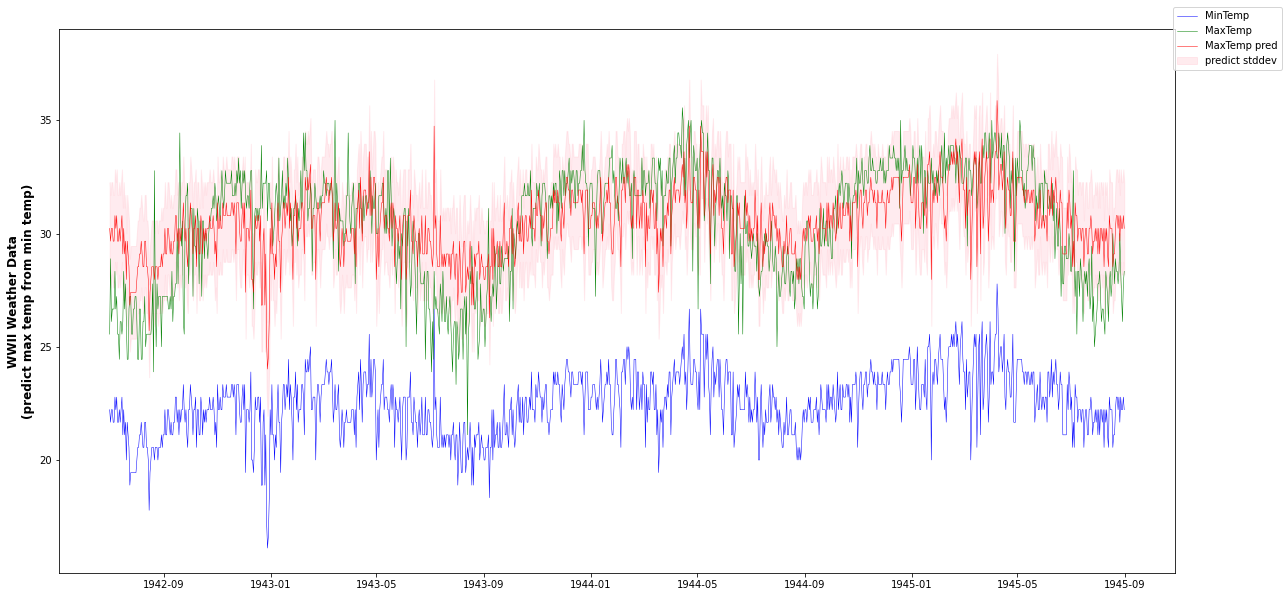

In [6]:
plots = 1

fig, ax = plt.subplots(plots, 1, figsize=(20,10), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i['MinTemp'],linewidth=0.5,color='blue',label='MinTemp')
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i['MaxTemp'],linewidth=0.5,color='green',label='MaxTemp')
ax[cnt,0].plot(df_i.unstack(level=0).index, df_i['predicted_MaxTemp'],linewidth=0.5,color='red',label='MaxTemp pred')
ax[cnt,0].fill_between(df_i.unstack(level=0).index, df_i['predicted_MaxTemp'] - df_i['stddev_MaxTemp'],
                df_i['predicted_MaxTemp'] + df_i['stddev_MaxTemp'], color="pink", alpha=0.3, label="predict stddev")
ax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt,0].set_ylabel('WWII Weather Data\n(predict max temp from min temp)',fontsize=12,weight="bold")
cnt = 1